# obsolete  data

In [79]:
u1_csv=r'..\data\haptic_data\flexible-haptic\user1_flexible-haptic_2025-03-27T16-04-54_112135.csv'
u2_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-10-40_456602.csv'
u3_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-45-29_971081.csv'
u4_csv=r'..\data\haptic_data\flexible-haptic\user4_flexible-haptic_2025-03-27T16-57-32_536460.csv'

u1_wav=r'../data/haptic_data/flexible-haptic/user1_flexible-haptic_2025-03-27T16-04-54_112135.wav'
u2_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-10-40_456602.wav'
u3_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-45-29_971081.wav'
u4_wav=r'../data/haptic_data/flexible-haptic/user4_flexible-haptic_2025-03-27T16-57-32_536460.wav'

## -obsolete  Pending for image 

## datastruct

- *audio_haptic # 200ms  150 play +50 buffer
- audio_haptic_spec 
- *audio_press  # 60 ms 
- audio_press_spec
- audio_press_mfcc
- *Inertial_press  # 60  fixed stgart  point 
- *Inertial_haptic  # 40   dynamic start point
- *Inertial_whole # can overlap 150 ?
- Audio_whole  # can overlap   300ms? 


- Rule
- Find the highest power 150ms, and extend to the left + 50ms , which is 200ms for the 
    - audio_haptic
    - Mark the start time  T1
- Find the left start from T1 boundary of the none,none,none,none,cross,cross,cross 
    - Mark the start time T2 
    - Based on the T2 at CSV go to left + 10 records ,mark the time T3
- From T3 go to right +60 records mark the inertial_press data( 60 records)
    - Inertial _press

- From T1 find the csv time +60 records 
    - inertial_haptic

- From T3 +150 records
    - Inertial_whole

- From T3 + 200 ms and then within 200ms find the average highest power 60ms 
    - Audio_press

- From T3 - end of the audio_haptic 
    - Audio_whole

ineritl_press 
inertial_press + press mfcc
inertial_press + hatpcic spec
inertial_whole + press mfcc + hatpci spec

In [76]:
import os
import re
import numpy as np
import librosa
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta

def extract_start_timestamp_from_filename(filename):
    match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', filename)
    if match:
        timestamp = match.group(0)
        date_part, time_part = timestamp.split('T')
        return f"{date_part}T{time_part.replace('-', ':')}"
    return None

def find_cross_start(df, start_idx):
    # Look to the left of the start index
    lookback_range = df.loc[:start_idx-1, 'button_press'][::-1]
    pattern = ['none', 'none', 'cross']
    buffer = []

    for idx, value in lookback_range.items():
        buffer.insert(0, value)
        if len(buffer) > len(pattern):
            buffer.pop()
        if buffer == pattern:
            return idx + len(buffer) - pattern[::-1].index('cross') - 1  # Return first 'cross' index
    return None  # Pattern not found

# align_deplay is the delay between the audio and the inertial data
def prepare_audio_csv_segement(wav_path, csv_path, n_segments=100, segment_duration=0.15, pre_segment_duration=0.05,align_deplay=40,haptic_inertial_length=40):
    audio, sr = librosa.load(wav_path, sr=None)

    segment_length = int(segment_duration * sr)
    pre_segment_length = int(pre_segment_duration * sr)
    total_length = segment_length + pre_segment_length
    hop_length = segment_length // 4

    energy = librosa.feature.rms(y=audio, frame_length=segment_length, hop_length=hop_length, center=True)[0]
    peaks, _ = find_peaks(energy, distance=segment_length / hop_length)

    if len(peaks) < n_segments:
        additional = np.linspace(0, len(energy) - 1, n_segments - len(peaks), dtype=int)
        peaks = np.concatenate([peaks, additional])

    peak_samples = peaks * hop_length
    energies, valid_pos = [], []

    for pos in peak_samples:
        if pos + segment_length <= len(audio):
            segment = audio[pos:pos + segment_length]
            energies.append(np.mean(np.abs(segment)))
            valid_pos.append(pos)

    sorted_idx = np.argsort(energies)[::-1]
    audio_haptic, energy_values, selected_positions, used_ranges = [], [], [], []
    haptic_segment_timestamps, inertial_haptic, inertial_haptic_id = [], [], []
    inertial_whole, inertial_whole_id = [], []
    inertial_press, inertial_press_id = [], []
    audio_whole, audio_whole_timestamp = [], []
    audio_press, audio_press_timestamp = [], []

    file_start_timestamp = extract_start_timestamp_from_filename(os.path.basename(wav_path))
    df = pd.read_csv(csv_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    for idx in sorted_idx:
        pos = valid_pos[idx]
        start = max(0, pos - pre_segment_length)
        end = pos + segment_length

        if any(not (end <= u_start or start >= u_end) for u_start, u_end in used_ranges):
            continue

        haptic_segment = audio[start:end]
        if len(haptic_segment) < total_length:
            haptic_segment = np.pad(haptic_segment, (0, total_length - len(haptic_segment)))

        haptic_start_sec = start / sr
        haptic_timestamp = (
            (datetime.fromisoformat(file_start_timestamp) + timedelta(seconds=haptic_start_sec)).isoformat()
            if file_start_timestamp else f"{haptic_start_sec:.6f}"
        )
        audio_haptic.append(haptic_segment)
        energy_values.append(energies[idx])
        selected_positions.append((start, end))
        used_ranges.append((start, end))
        haptic_segment_timestamps.append(haptic_timestamp)

        try:
            target_time = pd.to_datetime(haptic_timestamp)

            closest_idx = (df['timestamp'] - target_time).abs().idxmin() + align_deplay

            end_idx = min(closest_idx + haptic_inertial_length, len(df))
            inertial_sample = df.iloc[closest_idx:end_idx].to_dict(orient='records')
            
            # Print audio and inertial timestamps and their gap
            audio_time = target_time
            inertial_time = df.iloc[closest_idx]['timestamp']
            time_gap = (inertial_time - audio_time).total_seconds()

            
            inertial_haptic.append(inertial_sample)
            inertial_haptic_id.append(closest_idx)

            # Find inertial_whole range
            cross_start_idx = find_cross_start(df, closest_idx) -10 # extend 10 records from the left
            if cross_start_idx is not None:
                inertial_whole_data = df.iloc[cross_start_idx:end_idx].to_dict(orient='records')
                
                # Print whole segment start time and gap with audio
                whole_start_time = df.iloc[cross_start_idx]['timestamp']
                whole_time_gap = (whole_start_time - audio_time).total_seconds()
                inertial_whole.append(inertial_whole_data)
                inertial_whole_id.append(cross_start_idx)
                
                # Extract inertial_press (first 100 records from inertial_whole)
                press_end_idx = min(cross_start_idx + 100, len(df))
                inertial_press_data = df.iloc[cross_start_idx:press_end_idx].to_dict(orient='records')
                inertial_press.append(inertial_press_data)
                inertial_press_id.append(cross_start_idx)
                
                # Extract audio_whole from inertial_whole's first timestamp to the end of audio_haptic
                if len(inertial_whole_data) > 0:
                    whole_start_time = pd.to_datetime(inertial_whole_data[0]['timestamp'])
                    whole_start_sec = (whole_start_time - datetime.fromisoformat(file_start_timestamp)).total_seconds()
                    whole_start_sample = int(whole_start_sec * sr)
                    whole_audio_segment = audio[whole_start_sample:end]
                    audio_whole.append(whole_audio_segment)
                    audio_whole_timestamp.append(whole_start_time.isoformat())
                    
                    # Extract audio_press: find peak in first 300ms of audio_whole and extract 60ms around it
                    search_duration_ms = 300
                    search_samples = min(int(search_duration_ms / 1000 * sr), len(whole_audio_segment))
                    search_segment = whole_audio_segment[:search_samples]
                    
                    if len(search_segment) > 0:
                        # Find the peak amplitude in the search segment
                        peak_idx = np.argmax(np.abs(search_segment))
                        
                        # Extract 60ms around the peak (30ms before, 30ms after)
                        press_duration_ms = 60
                        half_press_samples = int((press_duration_ms / 2) / 1000 * sr)
                        press_start = max(0, peak_idx - half_press_samples)
                        press_end = min(len(whole_audio_segment), peak_idx + half_press_samples)
                        
                        press_segment = whole_audio_segment[press_start:press_end]
                        
                        # Ensure consistent length (60ms)
                        expected_press_samples = int(press_duration_ms / 1000 * sr)
                        if len(press_segment) < expected_press_samples:
                            press_segment = np.pad(press_segment, (0, expected_press_samples - len(press_segment)))
                        
                        # Calculate timestamp for audio_press
                        press_start_sec = whole_start_sec + (press_start / sr)
                        press_timestamp = (datetime.fromisoformat(file_start_timestamp) + 
                                          timedelta(seconds=press_start_sec)).isoformat()
                        
                        audio_press.append(press_segment)
                        audio_press_timestamp.append(press_timestamp)
                    else:
                        audio_press.append(np.array([]))
                        audio_press_timestamp.append(None)
                else:
                    audio_whole.append(np.array([]))
                    audio_whole_timestamp.append(None)
                    audio_press.append(np.array([]))
                    audio_press_timestamp.append(None)
            else:
                inertial_whole.append([])
                inertial_whole_id.append(None)
                inertial_press.append([])
                inertial_press_id.append(None)
                audio_whole.append(np.array([]))
                audio_whole_timestamp.append(None)
                audio_press.append(np.array([]))
                audio_press_timestamp.append(None)

        except Exception as e:
            inertial_haptic.append([])
            inertial_haptic_id.append(None)
            inertial_whole.append([])
            inertial_whole_id.append(None)
            inertial_press.append([])
            inertial_press_id.append(None)
            audio_whole.append(np.array([]))
            audio_whole_timestamp.append(None)
            audio_press.append(np.array([]))
            audio_press_timestamp.append(None)

        if len(audio_haptic) >= n_segments:
            break

    return {
        'audio_haptic': audio_haptic, # 200ms  
        'hap_timestamp': haptic_segment_timestamps,
        'energy_values': energy_values,
        'sampling_rate': sr,
        'file_start_timestamp': file_start_timestamp,
        'selected_positions': selected_positions,
        'full_audio': audio,
        'inertial_haptic': inertial_haptic, # 40 records  
        'inertial_haptic_id': inertial_haptic_id,
        'inertial_whole': inertial_whole, # dyanmaic range  
        'inertial_whole_id': inertial_whole_id,
        'inertial_press': inertial_press, # 100 records 
        'inertial_press_id': inertial_press_id,
        'audio_whole': audio_whole,  # dynamic range 
        'audio_whole_timestamp': audio_whole_timestamp,
        'audio_press': audio_press, # 60ms 
        'audio_press_timestamp': audio_press_timestamp,
    }


In [214]:
import matplotlib.pyplot as plt
import librosa.display

def plot_audio_haptic_segments(audio_haptic_data, max_plots=10):
    """
    Plot waveform and spectrogram of each audio_haptic segment, audio_press segment, and audio_whole segment.

    Args:
        audio_haptic_data (dict): Output from find_high_amplitude_segments_simple
        max_plots (int): Max number of segments to plot
    """
    audio_haptic = audio_haptic_data['audio_haptic']
    audio_press = audio_haptic_data['audio_press']
    audio_whole = audio_haptic_data['audio_whole']
    sr = audio_haptic_data['sampling_rate']
    energy_values = audio_haptic_data['energy_values']

    n_segments = len(audio_haptic)
    max_plots = min(max_plots or n_segments, n_segments)

    segments_per_row = 5
    n_rows = (max_plots + segments_per_row - 1) // segments_per_row

    # 6 rows per segment: haptic waveform, haptic spectrogram, press waveform, press spectrogram, whole waveform, whole spectrogram
    fig, axs = plt.subplots(n_rows * 6, segments_per_row, figsize=(20, 18 * n_rows))

    for i in range(max_plots):
        row_base = (i // segments_per_row) * 6
        col = i % segments_per_row

        # Plot haptic waveform
        axs[row_base, col].plot(audio_haptic[i], color='gray')
        axs[row_base, col].set_title(f"Haptic Waveform {i+1} (Energy: {energy_values[i]:.4f})")
        axs[row_base, col].set_xlabel("Samples")
        axs[row_base, col].set_ylabel("Amplitude")

        # Plot haptic spectrogram
        S_haptic = librosa.stft(audio_haptic[i])
        D_haptic = librosa.amplitude_to_db(np.abs(S_haptic), ref=np.max)
        img_haptic = librosa.display.specshow(D_haptic, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 1, col])
        axs[row_base + 1, col].set_title(f"Haptic Spectrogram {i+1}")
        fig.colorbar(img_haptic, ax=axs[row_base + 1, col], format="%+2.0f dB")

        # Plot press waveform
        if i < len(audio_press) and len(audio_press[i]) > 0:
            axs[row_base + 2, col].plot(audio_press[i], color='blue')
            axs[row_base + 2, col].set_title(f"Press Waveform {i+1}")
            axs[row_base + 2, col].set_xlabel("Samples")
            axs[row_base + 2, col].set_ylabel("Amplitude")

            # Plot press spectrogram
            S_press = librosa.stft(audio_press[i])
            D_press = librosa.amplitude_to_db(np.abs(S_press), ref=np.max)
            img_press = librosa.display.specshow(D_press, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 3, col])
            axs[row_base + 3, col].set_title(f"Press Spectrogram {i+1}")
            fig.colorbar(img_press, ax=axs[row_base + 3, col], format="%+2.0f dB")
        else:
            axs[row_base + 2, col].axis('off')
            axs[row_base + 3, col].axis('off')
            
        # Plot whole waveform
        if i < len(audio_whole) and len(audio_whole[i]) > 0:
            axs[row_base + 4, col].plot(audio_whole[i], color='green')
            axs[row_base + 4, col].set_title(f"Whole Waveform {i+1}")
            axs[row_base + 4, col].set_xlabel("Samples")
            axs[row_base + 4, col].set_ylabel("Amplitude")

            # Plot whole spectrogram
            S_whole = librosa.stft(audio_whole[i])
            D_whole = librosa.amplitude_to_db(np.abs(S_whole), ref=np.max)
            img_whole = librosa.display.specshow(D_whole, sr=sr, y_axis='log', x_axis='time', ax=axs[row_base + 5, col])
            axs[row_base + 5, col].set_title(f"Whole Spectrogram {i+1}")
            fig.colorbar(img_whole, ax=axs[row_base + 5, col], format="%+2.0f dB")
        else:
            axs[row_base + 4, col].axis('off')
            axs[row_base + 5, col].axis('off')

    # Hide unused subplots
    for i in range(max_plots, n_rows * segments_per_row):
        row_base = (i // segments_per_row) * 6
        col = i % segments_per_row
        for j in range(6):
            axs[row_base + j, col].axis('off')

    plt.tight_layout()
    plt.show()

def plot_full_audio_with_segments(audio_haptic_data):
    """
    Plot the full audio waveform with highlighted segments.
    
    Args:
        audio_haptic_data (dict): Output from prepare_audio_csv_segement
    """
    full_audio = audio_haptic_data['full_audio']
    sr = audio_haptic_data['sampling_rate']
    selected_positions = audio_haptic_data['selected_positions']
    energy_values = audio_haptic_data['energy_values']
    
    # Create time axis in seconds
    time = np.arange(len(full_audio)) / sr
    
    plt.figure(figsize=(20, 6))
    plt.plot(time, full_audio, color='gray', alpha=0.7)
    
    # Highlight each selected segment with a different color
    colors = plt.cm.rainbow(np.linspace(0, 1, len(selected_positions)))
    
    for i, ((start, end), color, energy) in enumerate(zip(selected_positions, colors, energy_values)):
        start_time = start / sr
        end_time = end / sr
        segment_time = np.arange(start, end) / sr
        segment_audio = full_audio[start:end]
        
        plt.plot(segment_time, segment_audio, color=color, linewidth=2)
        
        # Add vertical lines to mark segment boundaries
        plt.axvline(x=start_time, color=color, linestyle='--', alpha=0.7)
        plt.axvline(x=end_time, color=color, linestyle='--', alpha=0.7)
        
        # Add segment index and energy directly on the waveform
        mid_time = (start_time + end_time) / 2
        max_amp = np.max(segment_audio)
        plt.text(mid_time, max_amp, f"{i+1}\nE:{energy:.2f}", 
                 color=color, fontweight='bold', ha='center', va='bottom')
        
        # Add color range indicator
        plt.axhspan(min(segment_audio), max(segment_audio), 
                   xmin=(start_time/time[-1]), xmax=(end_time/time[-1]), 
                   color=color, alpha=0.1)
    
    plt.title('Full Audio Waveform with Highlighted Haptic Segments')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()



def plot_inertial_haptic_sequences_grid(result, max_plots=5):
    inertial_haptic = result.get('inertial_haptic', [])
    inertial_whole = result.get('inertial_whole', [])
    timestamps = result.get('hap_timestamp', [])
    
    gyro_fields = ['gyro_pitch', 'gyro_yaw', 'gyro_roll']
    acc_fields = ['acc_x', 'acc_y', 'acc_z']
    
    num_to_plot = min(max_plots, len(inertial_whole))
    
    # Create a figure with one row per segment - each row has gyro and acc plots
    fig, axes = plt.subplots(num_to_plot, 2, figsize=(14, 5 * num_to_plot), squeeze=False)
    fig.suptitle("Inertial Data with Haptic and Button Press Annotations", fontsize=16)
    
    for i in range(num_to_plot):
        if i >= len(inertial_whole) or not inertial_whole[i]:
            continue
            
        whole_sequence = inertial_whole[i]
        if not all(field in whole_sequence[0] for field in gyro_fields + acc_fields):
            print(f"Skipping sequence {i} due to missing fields.")
            continue
        
        # Get the whole sequence data
        whole_time_axis = list(range(len(whole_sequence)))
        whole_gyro_data = {field: [row[field] for row in whole_sequence] for field in gyro_fields}
        whole_acc_data = {field: [row[field] for row in whole_sequence] for field in acc_fields}
        
        # Extract button_press data
        button_press_data = [1 if row.get('button_press') == 'cross' else 0 for row in whole_sequence]
        
        # Find button press ranges
        press_ranges = []
        in_press = False
        start_idx = 0
        
        for j, press in enumerate(button_press_data):
            if press == 1 and not in_press:
                start_idx = j
                in_press = True
            elif press == 0 and in_press:
                press_ranges.append((start_idx, j))
                in_press = False
        
        if in_press:  # Handle case where press extends to the end
            press_ranges.append((start_idx, len(button_press_data)-1))
        
        # Plot gyroscope data
        ax_gyro = axes[i, 0]
        for field in gyro_fields:
            ax_gyro.plot(whole_time_axis, whole_gyro_data[field], label=field)
        
        # Plot accelerometer data
        ax_acc = axes[i, 1]
        for field in acc_fields:
            ax_acc.plot(whole_time_axis, whole_acc_data[field], label=field)
        
        # Mark haptic segment in both plots if available
        if i < len(inertial_whole) and len(whole_sequence) > 40:
            # Haptic is the last 40 records in the whole sequence
            haptic_start = len(whole_sequence) - 40
            haptic_end = len(whole_sequence)
            
            # Mark haptic range in gyro plot
            ax_gyro.axvspan(haptic_start, haptic_end, color='blue', alpha=0.2, label='Haptic Range')
            
            # Mark haptic range in acc plot
            ax_acc.axvspan(haptic_start, haptic_end, color='blue', alpha=0.2, label='Haptic Range')
        
        # Mark button press segment (first 100 records)
        if len(whole_sequence) > 0:
            press_start = 0
            press_end = min(100, len(whole_sequence))
            
            ax_gyro.axvspan(press_start, press_end, color='green', alpha=0.2, label='Button Press Range')
            ax_acc.axvspan(press_start, press_end, color='green', alpha=0.2, label='Button Press Range')
        
        # Add button press binary indicator at the bottom of both plots
        if any(button_press_data):
            # For gyro plot
            min_gyro = min([min(whole_gyro_data[field]) for field in gyro_fields])
            max_gyro = max([max(whole_gyro_data[field]) for field in gyro_fields])
            range_gyro = max_gyro - min_gyro
            base_gyro = min_gyro - range_gyro * 0.1
            
            ax_gyro.plot(whole_time_axis, [base_gyro] * len(button_press_data), 'k-', alpha=0.3)
            ax_gyro.plot(whole_time_axis, 
                        [base_gyro + press * (range_gyro * 0.05) for press in button_press_data], 
                        'r-', linewidth=2, label='Button Press (binary)')
            
            # For acc plot
            min_acc = min([min(whole_acc_data[field]) for field in acc_fields])
            max_acc = max([max(whole_acc_data[field]) for field in acc_fields])
            range_acc = max_acc - min_acc
            base_acc = min_acc - range_acc * 0.1
            
            ax_acc.plot(whole_time_axis, [base_acc] * len(button_press_data), 'k-', alpha=0.3)
            ax_acc.plot(whole_time_axis, 
                       [base_acc + press * (range_acc * 0.05) for press in button_press_data], 
                       'r-', linewidth=2, label='Button Press (binary)')
        
        # Set titles and labels
        ax_gyro.set_title(f"Gyroscope Data (Segment {i+1})\n{timestamps[i]}")
        ax_gyro.set_xlabel("Sample index")
        ax_gyro.set_ylabel("Gyro values")
        ax_gyro.legend()
        ax_gyro.grid(True, alpha=0.3)
        
        ax_acc.set_title(f"Accelerometer Data (Segment {i+1})\n{timestamps[i]}")
        ax_acc.set_xlabel("Sample index")
        ax_acc.set_ylabel("Acceleration values")
        ax_acc.legend()
        ax_acc.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
    plt.show()



def plot_length_distributions(dataset):
    # Audio lengths in seconds
    sr = dataset['sampling_rate']
    audio_lengths = [len(segment) / sr for segment in dataset['audio_whole'] if isinstance(segment, np.ndarray)]

    # Inertial lengths in number of records
    inertial_lengths = [len(entry) for entry in dataset['inertial_whole'] if isinstance(entry, list)]

    # Plotting
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.hist(audio_lengths, bins=20, edgecolor='black')
    plt.title('Audio Whole Length Distribution')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    
    # Mark min and max for audio
    min_audio = min(audio_lengths)
    max_audio = max(audio_lengths)
    plt.axvline(min_audio, color='r', linestyle='--', label=f'Min: {min_audio:.2f}s')
    plt.axvline(max_audio, color='g', linestyle='--', label=f'Max: {max_audio:.2f}s')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(inertial_lengths, bins=20, edgecolor='black')
    plt.title('Inertial Whole Length Distribution')
    plt.xlabel('Number of Records')
    plt.ylabel('Count')
    
    # Mark min and max for inertial
    min_inertial = min(inertial_lengths)
    max_inertial = max(inertial_lengths)
    plt.axvline(min_inertial, color='r', linestyle='--', label=f'Min: {min_inertial}')
    plt.axvline(max_inertial, color='g', linestyle='--', label=f'Max: {max_inertial}')
    plt.legend()

    plt.tight_layout()
    plt.show()



def plot_audio_whole_with_annotations(dataset, max_plots=5):
    sr = dataset['sampling_rate']
    file_start_time = datetime.fromisoformat(dataset['file_start_timestamp'])

    for i in range(min(max_plots, len(dataset['audio_whole']))):
        audio = dataset['audio_whole'][i]
        haptic = dataset['audio_haptic'][i]
        press = dataset['audio_press'][i]

        if len(audio) == 0:
            print(f"Skipping index {i} (empty audio)")
            continue

        time_axis = np.arange(len(audio)) / sr

        try:
            audio_start_time = datetime.fromisoformat(dataset['audio_whole_timestamp'][i])
            haptic_start_time = datetime.fromisoformat(dataset['hap_timestamp'][i])
            press_start_time = datetime.fromisoformat(dataset['audio_press_timestamp'][i])

            haptic_offset_sec = (haptic_start_time - audio_start_time).total_seconds()
            press_offset_sec = (press_start_time - audio_start_time).total_seconds()
        except Exception as e:
            print(f"Skipping index {i} due to timestamp issue: {e}")
            continue

        plt.figure(figsize=(14, 6))

        # Waveform plot
        plt.subplot(2, 1, 1)
        plt.plot(time_axis, audio, label='Audio Waveform', color='gray')

        haptic_duration = len(haptic) / sr
        press_duration = len(press) / sr

        plt.axvspan(haptic_offset_sec, haptic_offset_sec + haptic_duration, color='cyan', alpha=0.3)
        plt.text(haptic_offset_sec, max(audio) * 0.8, 'Haptic Chirp', fontsize=9, color='blue')

        plt.axvspan(press_offset_sec, press_offset_sec + press_duration, color='orange', alpha=0.3)
        plt.text(press_offset_sec, max(audio) * 0.6, 'Press Sound', fontsize=9, color='darkorange')

        plt.title(f'[{i}] Audio Waveform with Haptic and Press Highlights')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Spectrogram plot
        plt.subplot(2, 1, 2)
        S = librosa.stft(audio)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')

        plt.axvspan(haptic_offset_sec, haptic_offset_sec + haptic_duration, color='cyan', alpha=0.3)
        plt.axvspan(press_offset_sec, press_offset_sec + press_duration, color='orange', alpha=0.3)

        plt.text(haptic_offset_sec, sr * 0.6 / 2, 'Haptic Chirp', fontsize=9, color='blue')
        plt.text(press_offset_sec, sr * 0.6 / 2, 'Press Sound', fontsize=9, color='darkorange')

        plt.title('Spectrogram with Haptic and Press Highlights')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

import matplotlib.pyplot as plt

def plot_inertial_sequences(data, field_name='inertial_haptic', index=0):
    assert field_name in ['inertial_haptic', 'inertial_whole', 'inertial_press'], \
        "field_name must be 'inertial_haptic', 'inertial_whole', or 'inertial_press'"
    
    gyro_fields = ['gyro_pitch', 'gyro_yaw', 'gyro_roll']
    acc_fields = ['acc_x', 'acc_y', 'acc_z']

    inertial_data_list = data[field_name]

    if len(inertial_data_list) == 0 or inertial_data_list[index] is None or len(inertial_data_list[index]) == 0:
        print(f"No valid data to plot for {field_name} at index {index}")
        return

    inertial_data = inertial_data_list[index]
    timestamps = list(range(len(inertial_data)))  # Use index as x-axis

    # Extract values per field
    gyro_vals = {field: [record.get(field, 0) for record in inertial_data] for field in gyro_fields}
    acc_vals = {field: [record.get(field, 0) for record in inertial_data] for field in acc_fields}

    # Determine max absolute value for consistent y-limits
    max_gyro = max(abs(val) for field in gyro_fields for val in gyro_vals[field])
    max_acc = max(abs(val) for field in acc_fields for val in acc_vals[field])

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    axs[0].set_title(f'{field_name} - Gyroscope')
    axs[1].set_title(f'{field_name} - Accelerometer')

    for field in gyro_fields:
        axs[0].plot(timestamps, gyro_vals[field], label=field)
    axs[0].legend()
    axs[0].set_ylim([-max_gyro * 1.1, max_gyro * 1.1])
    axs[0].set_ylabel("Gyro")

    for field in acc_fields:
        axs[1].plot(timestamps, acc_vals[field], label=field)
    axs[1].legend()
    axs[1].set_ylim([-max_acc * 1.1, max_acc * 1.1])
    axs[1].set_xlabel("Time (samples)")
    axs[1].set_ylabel("Acc")

    plt.tight_layout()
    plt.show()


def plot_motion_segments(timestamp_list, data_df_csv, wav_path, length_sequence=100, audio_length=1000):
    """
    Plots gyroscope and accelerometer data for each timestamp in the given list.

    Parameters:
    - timestamp_list: List of timestamps (strings or datetime objects)
    - data_df: DataFrame with columns ['timestamp','gyro_pitch','gyro_yaw','gyro_roll','acc_x','acc_y','acc_z']
    - length_sequence: Number of samples to include in each segment
    - wav_path: Path to the audio file to plot corresponding audio segments
    """
    import os
    import pandas as pd
    
    # Check if data_df is a string (file path) and load it if needed
    file_start_timestamp = extract_start_timestamp_from_filename(os.path.basename(wav_path))
    
    # Convert file_start_timestamp to datetime if it's a string
    if isinstance(file_start_timestamp, str):
        file_start_timestamp = pd.to_datetime(file_start_timestamp)
    
    if isinstance(data_df_csv, str):
        data_df = pd.read_csv(data_df_csv)
    else:
        data_df = data_df_csv
    
    # Convert 'timestamp' column to datetime if it's not already
    if 'timestamp' in data_df.columns and not pd.api.types.is_datetime64_any_dtype(data_df['timestamp']):
        data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

    # Load the audio file
    from scipy.io import wavfile
    sample_rate, audio_data = wavfile.read(wav_path)
    
    for ts in timestamp_list:
        # Convert string timestamp to datetime if needed
        if isinstance(ts, str):
            ts = pd.to_datetime(ts)

        # Find the closest index to the timestamp
        closest_idx = data_df['timestamp'].sub(ts).abs().idxmin()

        # Slice records starting from that index
        segment = data_df.iloc[closest_idx:closest_idx+length_sequence]

        if segment.empty:
            print(f"No data found for timestamp: {ts}")
            continue

        # Calculate audio segment position
        time_diff = (ts - file_start_timestamp).total_seconds()
        audio_start_idx = int(time_diff * sample_rate)
        audio_end_idx = audio_start_idx + int((length_sequence / len(data_df)) * len(audio_data))
        
        # Ensure indices are within bounds
        audio_start_idx = max(0, audio_start_idx)
        audio_end_idx = min(len(audio_data), audio_end_idx)
        
        # Create a figure with 3 subplots
        fig, axs = plt.subplots(3, 1, figsize=(14, 6))
        
        # Plot audio waveform
        if len(audio_data.shape) > 1:  # Stereo
            axs[0].plot(audio_data[audio_start_idx:audio_end_idx, 0], label='Left Channel')
            axs[0].plot(audio_data[audio_start_idx:audio_end_idx, 1], label='Right Channel', alpha=0.7)
        else:  # Mono
            axs[0].plot(audio_data[audio_start_idx:audio_end_idx], label='Audio')
        
        axs[0].set_title(f'Audio Waveform from {segment["timestamp"].iloc[0]}')
        axs[0].set_xlabel('Sample')
        axs[0].set_ylabel('Amplitude')
        axs[0].legend()
        axs[0].grid(True)
        
        # Plot gyroscope data
        axs[1].plot(segment['gyro_pitch'], label='gyro_pitch')
        axs[1].plot(segment['gyro_yaw'], label='gyro_yaw')
        axs[1].plot(segment['gyro_roll'], label='gyro_roll')
        axs[1].set_title(f'Gyroscope Data from {segment["timestamp"].iloc[0]}')
        axs[1].set_xlabel('Sample')
        axs[1].set_ylabel('Gyro Values')
        axs[1].legend()
        axs[1].grid(True)

        # Plot accelerometer data
        axs[2].plot(segment['acc_x'], label='acc_x')
        axs[2].plot(segment['acc_y'], label='acc_y')
        axs[2].plot(segment['acc_z'], label='acc_z')
        axs[2].set_title(f'Accelerometer Data from {segment["timestamp"].iloc[0]}')
        axs[2].set_xlabel('Sample')
        axs[2].set_ylabel('Accel Values')
        axs[2].legend()
        axs[2].grid(True)
        
        plt.tight_layout()
        plt.show()



## Exexcut geting the data 

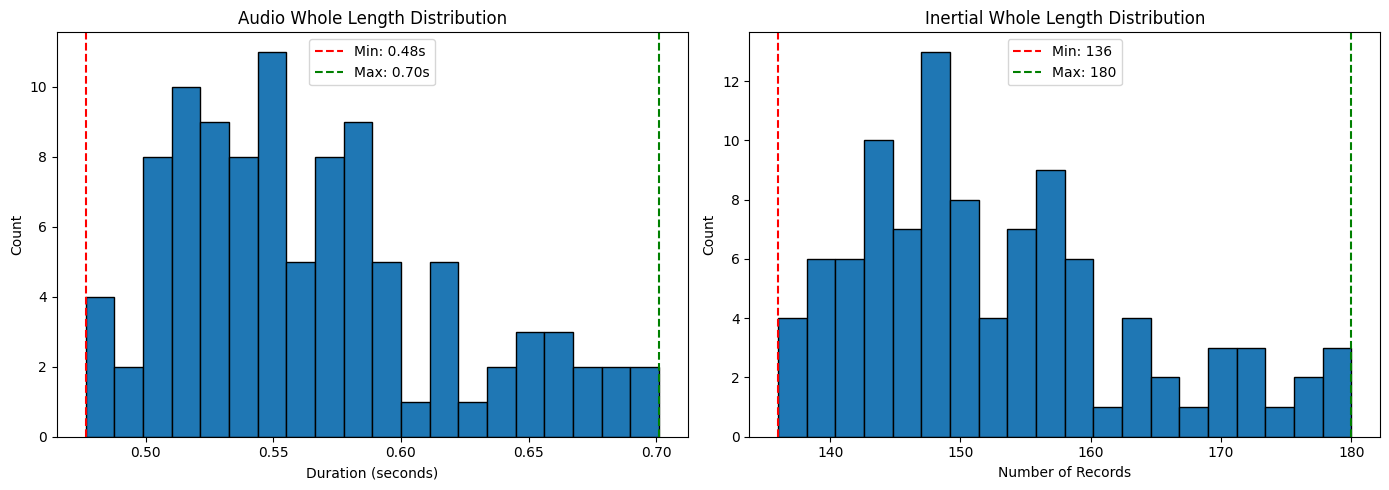

In [78]:
u1_d=prepare_audio_csv_segement(u1_wav,u1_csv)
plot_length_distributions(u1_d)

## Plot examples

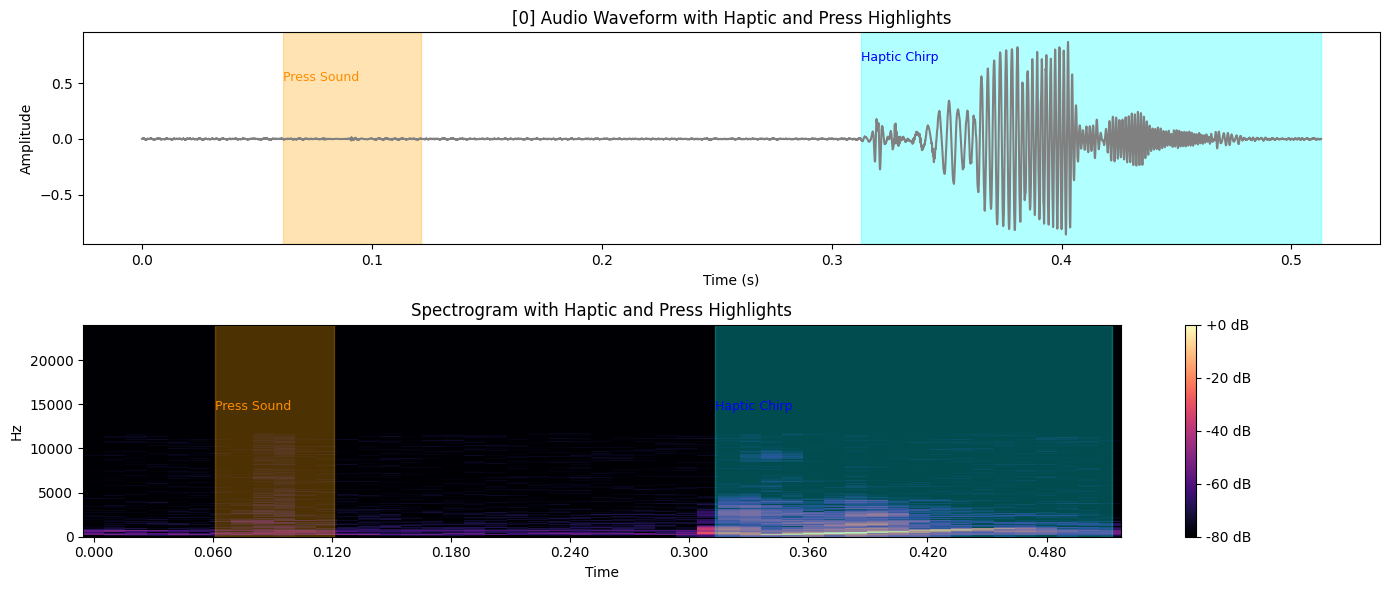

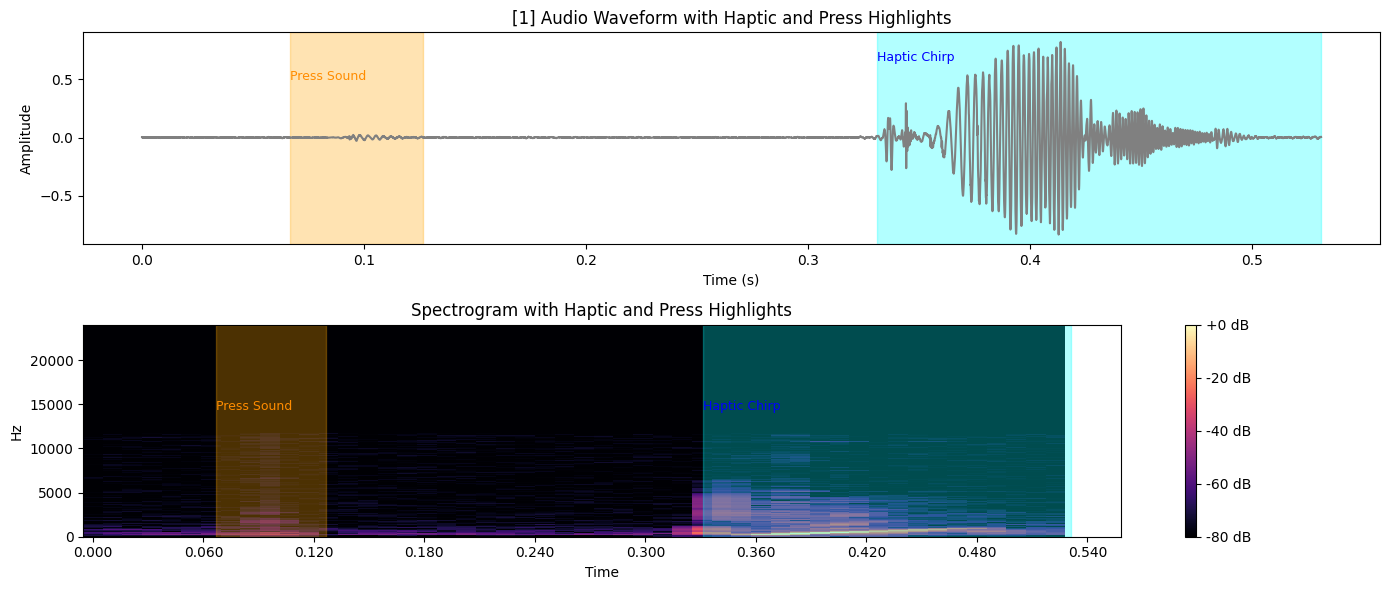

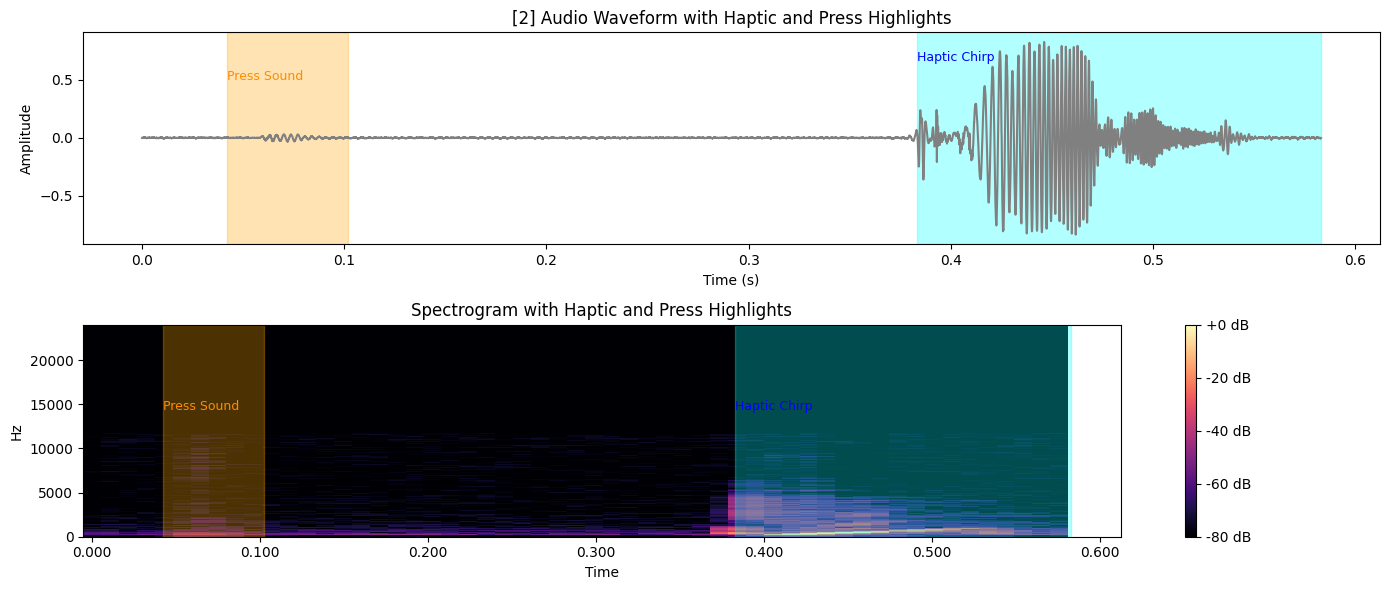

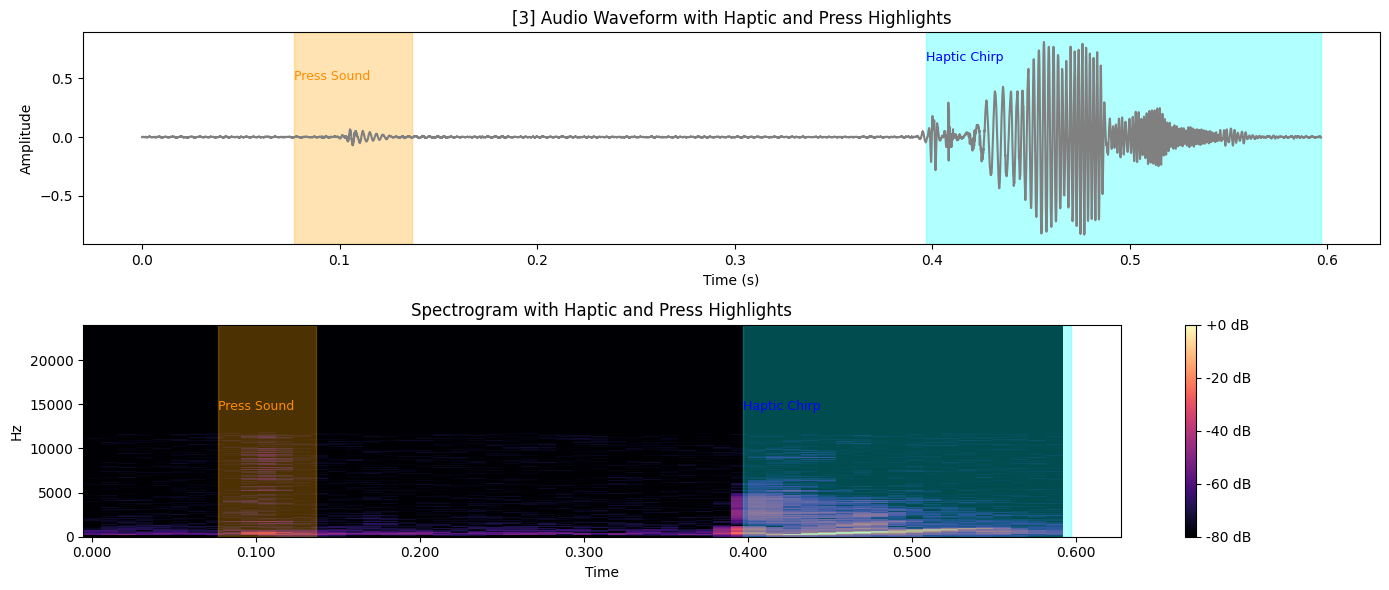

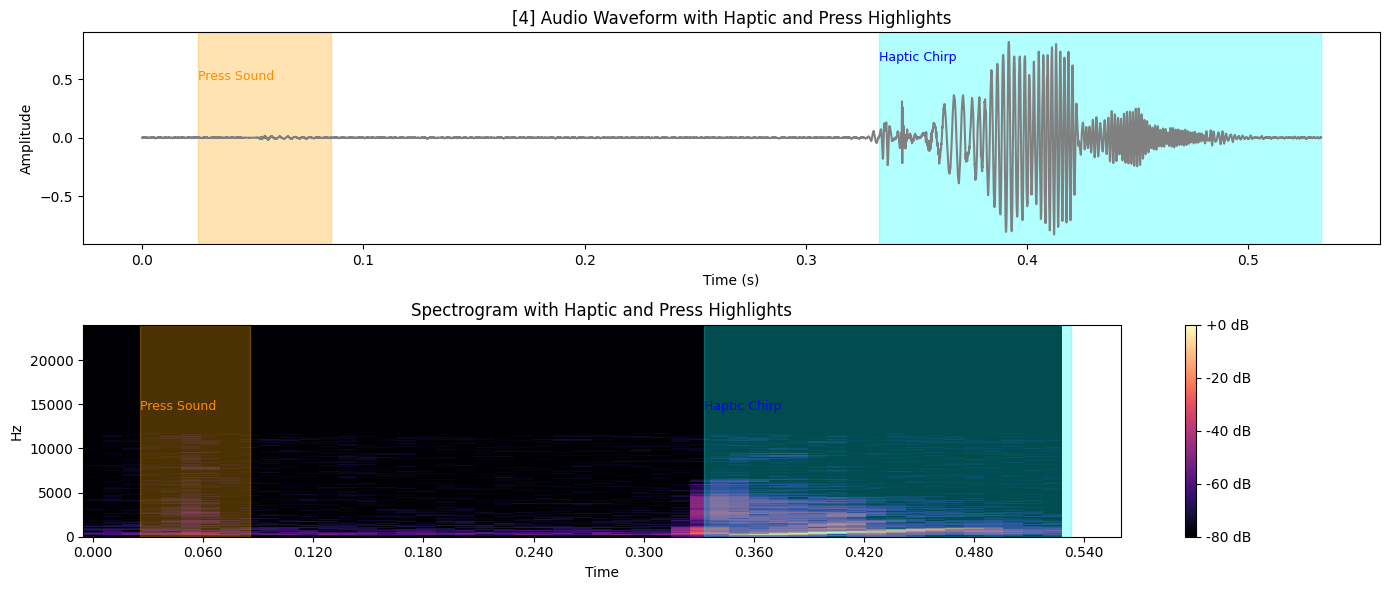

In [49]:
plot_audio_whole_with_annotations(u1_d)

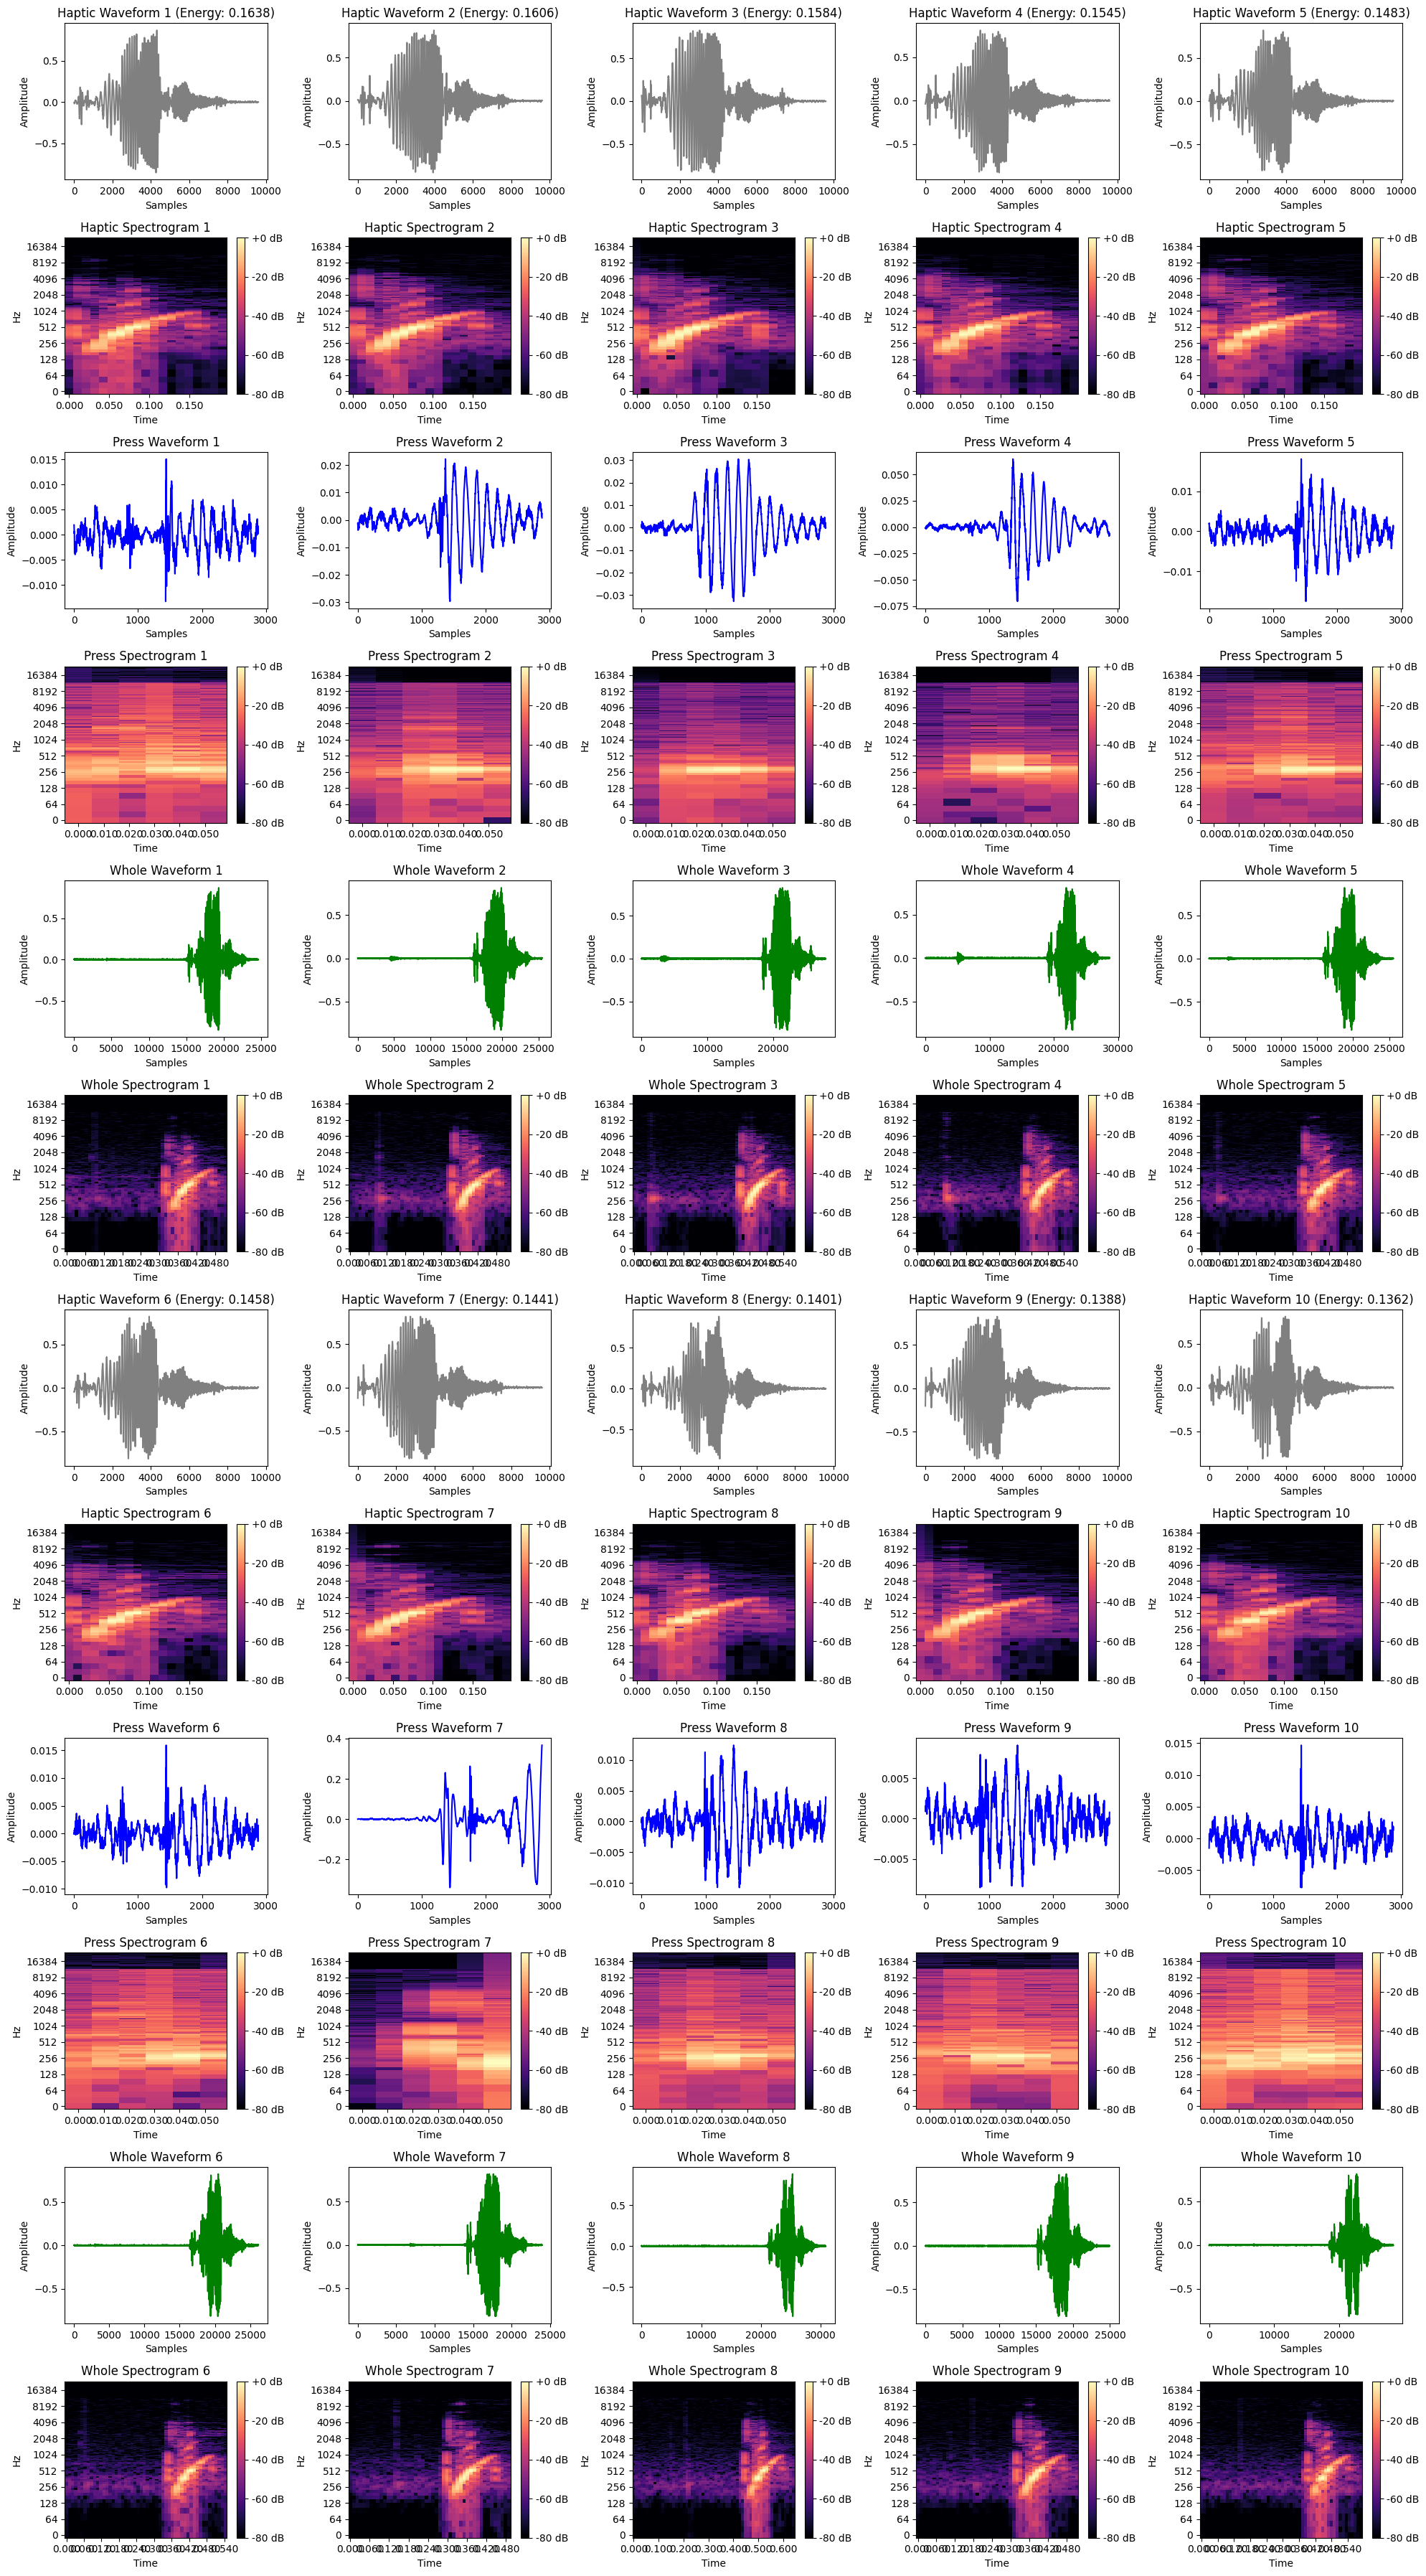

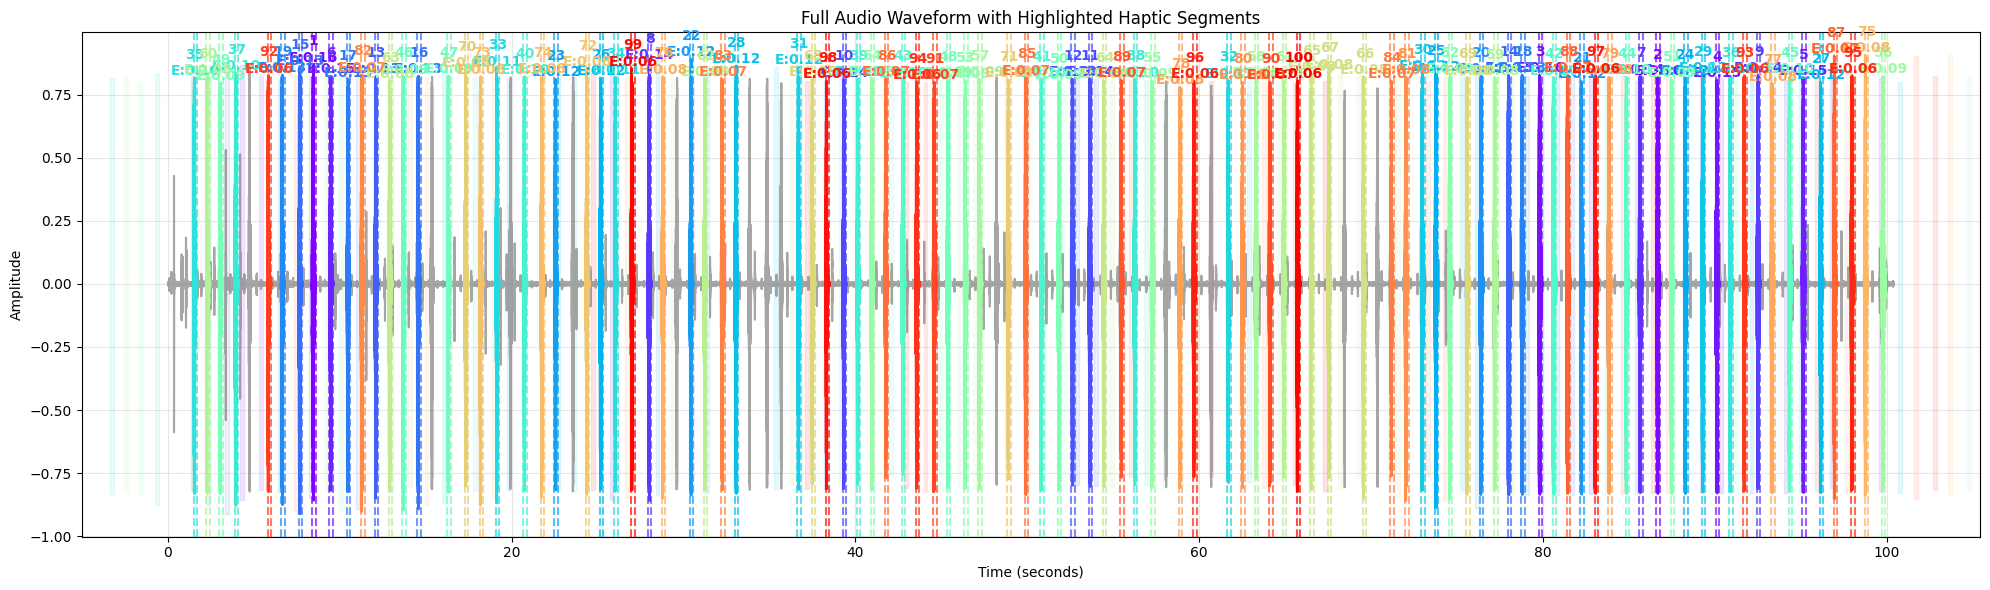

In [43]:
plot_audio_haptic_segments(u1_d)
plot_full_audio_with_segments(u1_d)

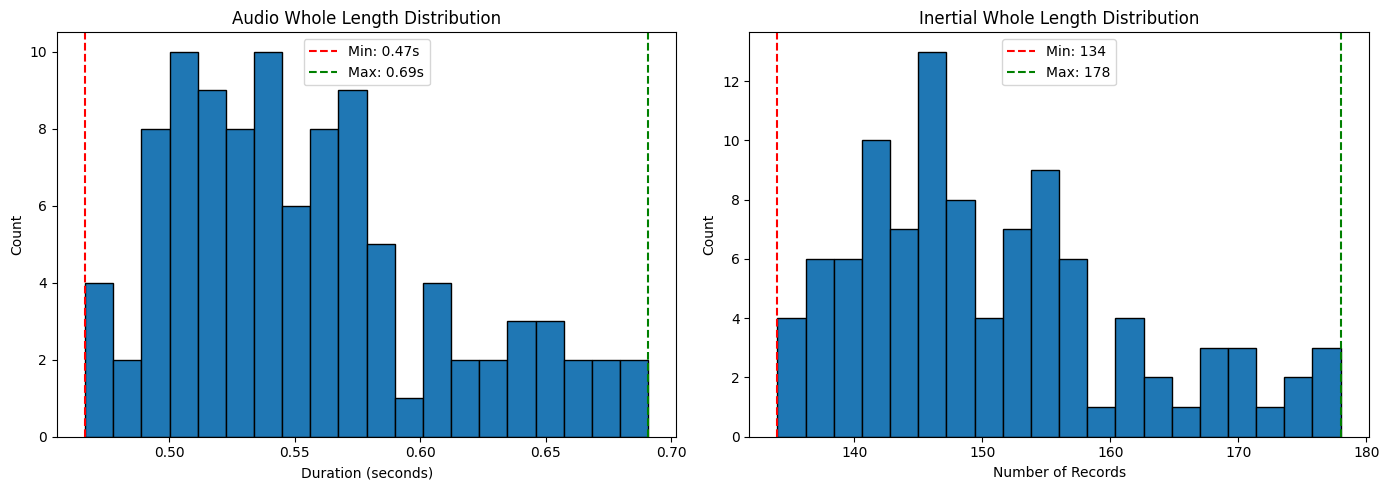

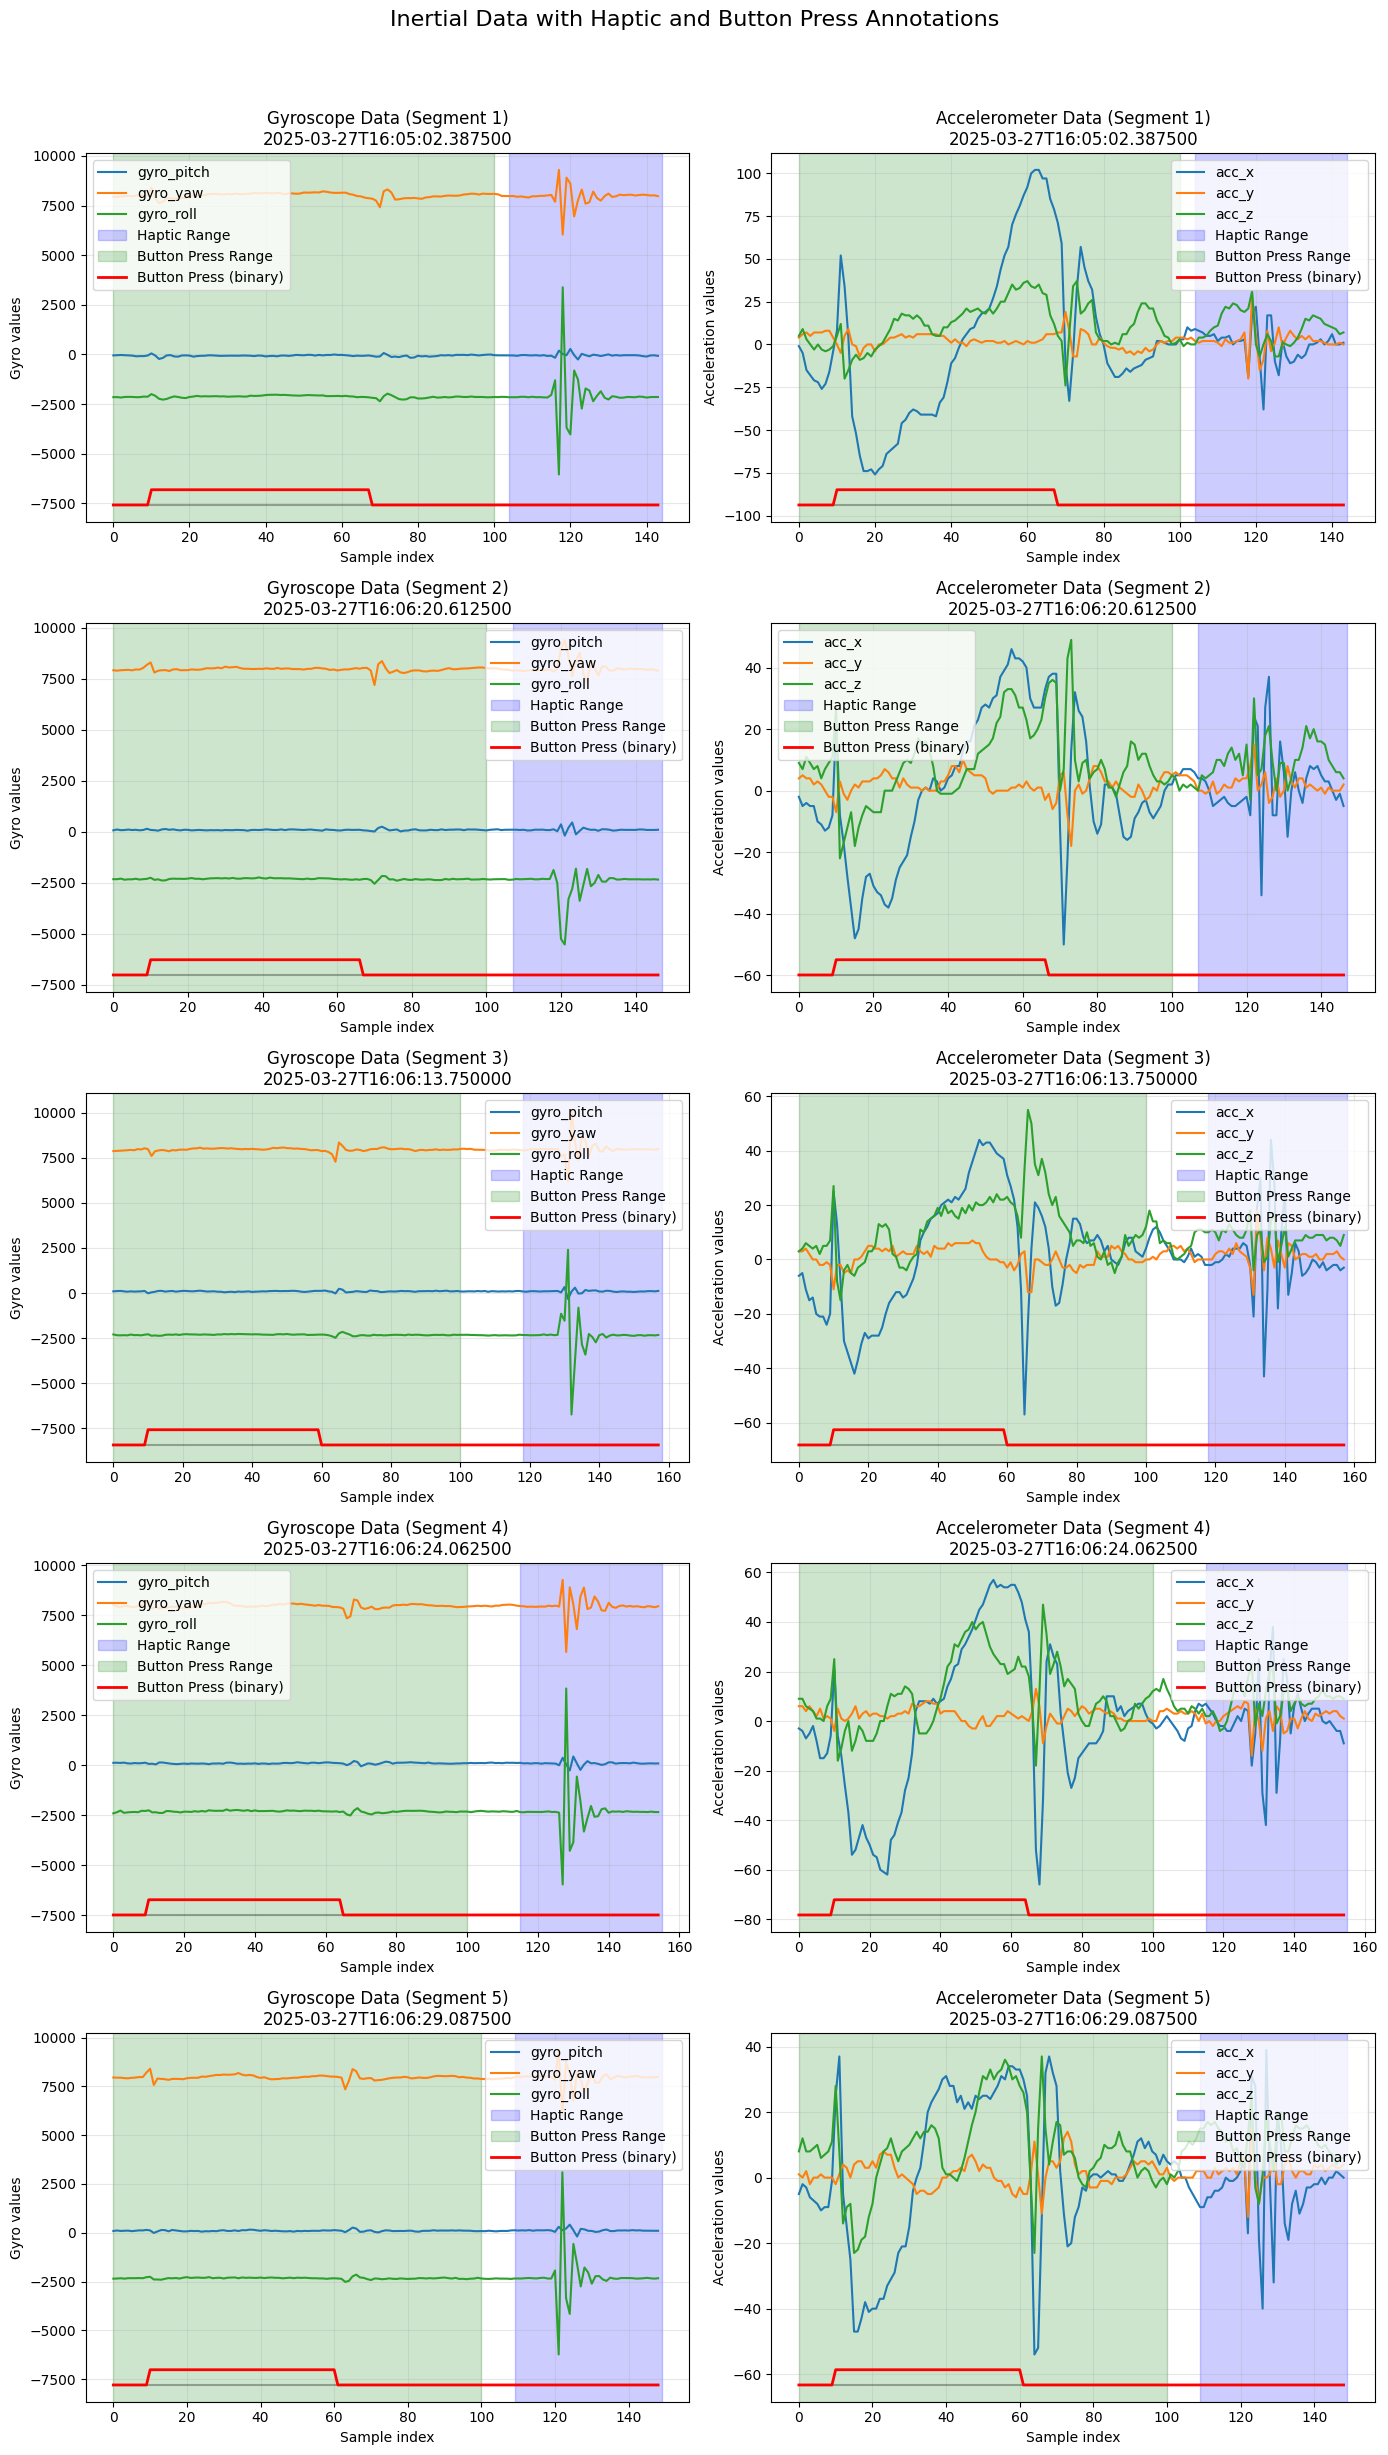

In [15]:
plot_inertial_haptic_sequences_grid(u1_d)

#  Start here Pre Data2 

In [1]:
u1_csv=r'..\data\haptic_data\flexible-haptic\user1_flexible-haptic_2025-03-27T16-04-54_112135.csv'
u2_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-10-40_456602.csv'
u3_csv=r'..\data\haptic_data\flexible-haptic\user3_flexible-haptic_2025-03-27T16-45-29_971081.csv'
u4_csv=r'..\data\haptic_data\flexible-haptic\user4_flexible-haptic_2025-03-27T16-57-32_536460.csv'

u1_wav=r'../data/haptic_data/flexible-haptic/user1_flexible-haptic_2025-03-27T16-04-54_112135.wav'
u2_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-10-40_456602.wav'
u3_wav=r'../data/haptic_data/flexible-haptic/user3_flexible-haptic_2025-03-27T16-45-29_971081.wav'
u4_wav=r'../data/haptic_data/flexible-haptic/user4_flexible-haptic_2025-03-27T16-57-32_536460.wav'

In [2]:
import numpy as np
import librosa
from scipy.signal import find_peaks
import pandas as pd
from datetime import datetime

def dataset_prepare(wav_path, csv_path, haptic_duration=0.15, pre_haptic_duration=0.05, top_k=110, inertial_haptic_length=60, inertial_haptic_windowsize=40):
    """
    Extract top non-overlapping audio segments based on RMS energy using librosa.feature.rms.
    Also extract corresponding inertial data sequences from CSV.
    
    Parameters:
        wav_path: Path to the WAV audio file
        csv_path: Path to the CSV file containing inertial data
        haptic_duration: Duration of haptic segment in seconds
        pre_haptic_duration: Duration of pre-haptic segment in seconds
        top_k: Maximum number of segments to extract
        inertial_haptic_length: Number of records to include in each inertial sequence
        inertial_haptic_windowsize: Size of the centered window around highest RMS point
    
    Returns:
        dict with:
            - 'audio_haptic': list of audio segment waveforms
            - 'audio_haptic_starttime': list of start times (in seconds)
            - 'audio_whole': list of audio segments aligned with inertial_whole sequences
            - 'audio_whole_starttime': list of start times for audio_whole segments (in seconds)
            - 'audio_press': list of 60ms audio segments centered around peak in first 300ms of audio_whole
            - 'audio_press_starttime': list of start times for audio_press segments (in seconds)
            - 'inertial_haptic': list of inertial data sequences with centered highest RMS window
            - 'inertial_haptic_id': list of starting indices of highest RMS windows in the original CSV
            - 'inertial_whole': list of extended inertial sequences including button press patterns
            - 'inertial_whole_id': list of starting indices of whole sequences in the original CSV
            - 'inertial_press': list of first 60 records from inertial_whole sequences
            - 'inertial_press_id': list of starting indices of press sequences in the original CSV
            - 'sampling_rate': sampling rate of the audio file
            - 'energy_values': list of energy values for each audio_haptic segment
    """
    # Load audio file
    audio, sr = librosa.load(wav_path, sr=None)
    
    # Load inertial data from CSV
    inertial_data = pd.read_csv(csv_path)
    
    # Calculate segment length in samples
    segment_length = int(haptic_duration * sr)
    pre_segment_length = int(pre_haptic_duration * sr)
    total_segment_length = segment_length + pre_segment_length
    
    # Calculate energy for sliding windows
    hop_length = segment_length // 4  # 75% overlap
    
    # Calculate RMS energy for each window
    energy = librosa.feature.rms(
        y=audio,
        frame_length=segment_length,
        hop_length=hop_length,
        center=True
    )[0]
    
    # Find peaks in energy
    peaks, _ = find_peaks(energy, distance=segment_length/hop_length)
    
    # If we don't have enough peaks, add more positions
    if len(peaks) < top_k:
        # Create additional positions
        additional_positions = np.linspace(0, len(energy)-1, top_k-len(peaks))
        peaks = np.concatenate([peaks, additional_positions.astype(int)])
    
    # Convert peak positions to sample positions
    peak_samples = peaks * hop_length
    
    # Calculate average energy for each potential segment
    segment_energies = []
    valid_positions = []
    
    for pos in peak_samples:
        pos = int(pos)
        # Ensure we have enough samples for a complete segment
        if pos + segment_length <= len(audio):
            segment = audio[pos:pos + segment_length]
            avg_energy = np.mean(np.abs(segment))
            segment_energies.append(avg_energy)
            valid_positions.append(pos)
    
    # Sort segments by energy and get top N
    sorted_indices = np.argsort(segment_energies)[::-1]  # Sort in descending order
    top_indices = sorted_indices[:top_k]
    
    audio_haptic = []
    audio_haptic_starttime = []
    audio_whole = []
    audio_whole_starttime = []
    audio_press = []
    audio_press_starttime = []
    inertial_haptic = []
    inertial_haptic_id = []
    inertial_whole = []
    inertial_whole_id = []
    inertial_press = []
    inertial_press_id = []
    energy_values = []  # Store energy values for each segment
    
    # Get the first timestamp from CSV to use as reference
    first_timestamp = pd.to_datetime(inertial_data['timestamp'].iloc[0])
    
    for idx in top_indices:
        pos = valid_positions[idx]
        start_with_pre = max(0, pos - pre_segment_length)
        
        # Add audio segment
        audio_haptic.append(audio[start_with_pre:pos + segment_length])
        start_time = start_with_pre / sr
        audio_haptic_starttime.append(start_time)
        
        # Store the energy value for this segment
        energy_values.append(segment_energies[idx])
        
        # Find corresponding inertial data
        # Convert audio start time to timestamp
        segment_timestamp = first_timestamp + pd.Timedelta(seconds=start_time)
        
        # Find the closest timestamp in the CSV
        inertial_data['time_diff'] = abs(pd.to_datetime(inertial_data['timestamp']) - segment_timestamp)
        closest_idx = inertial_data['time_diff'].idxmin()
        
        # Get the sequence of inertial data
        sequence_end = min(closest_idx + inertial_haptic_length, len(inertial_data))
        if sequence_end - closest_idx < inertial_haptic_length:
            # If we don't have enough data points after the start, take some from before
            sequence_start = max(0, sequence_end - inertial_haptic_length)
        else:
            sequence_start = closest_idx
            
        inertial_sequence = inertial_data.iloc[sequence_start:sequence_end].copy()
        
        # Find the point with highest RMS within the sequence based on accelerometer data
        highest_rms = 0
        best_point_idx = 0
        
        # Make sure we have enough data for analysis
        if len(inertial_sequence) >= 1:
            for i in range(len(inertial_sequence)):
                point = inertial_sequence.iloc[i]
                # Calculate RMS of accelerometer data for this single point
                acc_x = point['acc_x']
                acc_y = point['acc_y']
                acc_z = point['acc_z']
                
                # Calculate RMS for this point
                rms_value = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
                
                if rms_value > highest_rms:
                    highest_rms = rms_value
                    best_point_idx = i
            
            # Calculate window boundaries centered around the highest RMS point
            half_window = inertial_haptic_windowsize // 2
            window_start = max(0, best_point_idx - half_window)
            window_end = min(len(inertial_sequence), best_point_idx + half_window)
            
            # If window is too close to the beginning or end, adjust it to maintain window size
            if window_end - window_start < inertial_haptic_windowsize:
                if window_start == 0:
                    window_end = min(inertial_haptic_windowsize, len(inertial_sequence))
                elif window_end == len(inertial_sequence):
                    window_start = max(0, len(inertial_sequence) - inertial_haptic_windowsize)
            
            # Get the centered window
            centered_window = inertial_sequence.iloc[window_start:window_end].copy()
            centered_window = centered_window.drop(columns=['time_diff'] if 'time_diff' in centered_window.columns else [])
            
            haptic_id = sequence_start + window_start
            inertial_haptic.append(centered_window)
            inertial_haptic_id.append(haptic_id)
            
            # Find button press pattern (none,none,cross,cross) to the left of haptic_id
            whole_start_idx = haptic_id
            found_pattern = False
            
            # Search for the pattern to the left
            for i in range(haptic_id, max(0, haptic_id - 500), -1):
                if i < len(inertial_data) and i >= 3:  # Ensure we have enough data to check pattern
                    # Check for pattern: none,none,cross,cross
                    if (inertial_data.iloc[i]['button_press'] == 'cross' and 
                        inertial_data.iloc[i-1]['button_press'] == 'cross' and
                        inertial_data.iloc[i-2]['button_press'] == 'none' and
                        inertial_data.iloc[i-3]['button_press'] == 'none'):
                        # Found the pattern, the first cross is at i-1
                        found_pattern = True
                        # Go 10 records to the left of the first cross
                        whole_start_idx = max(0, i-1-10)
                        break
            
            # If pattern not found, just use haptic_id as starting point
            if not found_pattern:
                whole_start_idx = max(0, haptic_id - 20)  # Default to 20 records before haptic_id
            
            # The end of inertial_whole is the end of inertial_haptic
            haptic_end_idx = sequence_start + window_end
            
            # Extract the whole sequence
            whole_sequence = inertial_data.iloc[whole_start_idx:haptic_end_idx].copy()
            whole_sequence = whole_sequence.drop(columns=['time_diff'] if 'time_diff' in whole_sequence.columns else [])
            
            inertial_whole.append(whole_sequence)
            inertial_whole_id.append(whole_start_idx)
            
            # Extract the first 60 records from inertial_whole for inertial_press
            press_end_idx = min(whole_start_idx + 60, len(inertial_data))
            press_sequence = inertial_data.iloc[whole_start_idx:press_end_idx].copy()
            press_sequence = press_sequence.drop(columns=['time_diff'] if 'time_diff' in press_sequence.columns else [])
            
            inertial_press.append(press_sequence)
            inertial_press_id.append(whole_start_idx)
            
            # Create audio_whole segment aligned with inertial_whole
            # Get timestamp of the first record in inertial_whole
            whole_start_timestamp = pd.to_datetime(inertial_data.iloc[whole_start_idx]['timestamp'])
            
            # Calculate time difference from first CSV timestamp to whole_start_timestamp
            time_diff_seconds = (whole_start_timestamp - first_timestamp).total_seconds()
            
            # Calculate audio sample position for whole_start_timestamp
            whole_audio_start_sample = int(time_diff_seconds * sr)
            
            # End of audio_whole is the end of audio_haptic
            audio_haptic_end_sample = start_with_pre + len(audio_haptic[-1])
            
            # Extract audio_whole segment
            audio_whole_segment = audio[whole_audio_start_sample:audio_haptic_end_sample]
            audio_whole.append(audio_whole_segment)
            audio_whole_starttime.append(whole_audio_start_sample / sr)
            
            # Create audio_press segment (first 300ms of audio_whole with peak detection)
            # Calculate 300ms in samples
            ms_300_samples = int(0.3 * sr)
            # Get the first 300ms of audio_whole or the entire segment if shorter
            first_300ms = audio_whole_segment[:min(ms_300_samples, len(audio_whole_segment))]
            
            if len(first_300ms) > 0:
                # Find the peak in the first 300ms
                peak_idx = np.argmax(np.abs(first_300ms))
                
                # Calculate window boundaries for 60ms segment (30ms before and 30ms after peak)
                ms_30_samples = int(0.03 * sr)
                press_start_idx = max(0, peak_idx - ms_30_samples)
                
                # Calculate the required length for 60ms
                ms_60_samples = int(0.06 * sr)
                
                # Ensure the segment is exactly 60ms by extending to the right
                # This might go beyond the first 300ms if needed
                press_end_idx = press_start_idx + ms_60_samples
                
                # If we need to go beyond the first 300ms, check if we have enough audio in audio_whole_segment
                if press_end_idx > len(first_300ms):
                    # We need to extend beyond the first 300ms
                    if press_start_idx < len(first_300ms) and press_end_idx <= len(audio_whole_segment):
                        # We have enough audio in audio_whole_segment
                        audio_press_segment = audio_whole_segment[press_start_idx:press_end_idx]
                    else:
                        # Not enough audio in audio_whole_segment, take what we can
                        if press_start_idx < len(audio_whole_segment):
                            audio_press_segment = audio_whole_segment[press_start_idx:len(audio_whole_segment)]
                        else:
                            # This shouldn't happen, but just in case
                            audio_press_segment = np.array([])
                else:
                    # We have enough audio in the first 300ms
                    audio_press_segment = first_300ms[press_start_idx:press_end_idx]
                
                audio_press.append(audio_press_segment)
                
                # Calculate the start time of the audio_press segment
                press_start_time = (whole_audio_start_sample + press_start_idx) / sr
                audio_press_starttime.append(press_start_time)
            else:
                # If first_300ms is empty, use an empty array for audio_press
                audio_press.append(np.array([]))
                audio_press_starttime.append(audio_whole_starttime[-1])
        else:
            # If sequence is too short, use what we have
            inertial_sequence = inertial_sequence.drop(columns=['time_diff'] if 'time_diff' in inertial_sequence.columns else [])
            inertial_haptic.append(inertial_sequence)
            inertial_haptic_id.append(sequence_start)
            inertial_whole.append(inertial_sequence)  # Use same sequence for whole
            inertial_whole_id.append(sequence_start)  # Use same start index
            inertial_press.append(inertial_sequence)  # Use same sequence for press
            inertial_press_id.append(sequence_start)  # Use same start index
            
            # For audio_whole, use the same as audio_haptic in this case
            audio_whole.append(audio_haptic[-1])
            audio_whole_starttime.append(audio_haptic_starttime[-1])
            
            # For audio_press, use an empty array
            audio_press.append(np.array([]))
            audio_press_starttime.append(audio_haptic_starttime[-1])
    
    # Clean up temporary column
    if 'time_diff' in inertial_data.columns:
        inertial_data.drop(columns=['time_diff'], inplace=True)
    
    return {
        "audio_haptic": audio_haptic,  # 200ms 
        "audio_haptic_starttime": audio_haptic_starttime,
        "audio_whole": audio_whole,  # dynamic length
        "audio_whole_starttime": audio_whole_starttime,
        "audio_press": audio_press, # 60ms 
        "audio_press_starttime": audio_press_starttime,
        "inertial_haptic": inertial_haptic, # 40 records
        "inertial_haptic_id": inertial_haptic_id,
        "inertial_whole": inertial_whole, # 100-210 records
        "inertial_whole_id": inertial_whole_id,
        "inertial_press": inertial_press,  # 60 records 
        "inertial_press_id": inertial_press_id,
        "sampling_rate": sr,  # Add sampling rate
        "energy_values": energy_values  # Add energy values for each audio_haptic segment
    }


In [3]:
u1_d2=dataset_prepare(u1_wav,u1_csv)
# Prepare the dataset
u2_d = dataset_prepare(u2_wav, u2_csv)
u3_d=dataset_prepare(u3_wav,u3_csv)
u4_d=dataset_prepare(u4_wav,u4_csv)

### Filter the outlier 

In [4]:
def filter_inertial_whole(dataset):
    # Filter out noise data based on inertial_whole sequence length
    filtered_indices = []
    for i, sequence in enumerate(dataset["inertial_whole"]):
        if 100 <= len(sequence) <= 210:  # Keep only sequences with length between 100 and 210
            filtered_indices.append(i)

    # Create a new filtered dataset with only the good data
    dataset_filtered = {
        "audio_haptic": [dataset["audio_haptic"][i] for i in filtered_indices],
        "audio_haptic_starttime": [dataset["audio_haptic_starttime"][i] for i in filtered_indices],
        "inertial_haptic": [dataset["inertial_haptic"][i] for i in filtered_indices],
        "inertial_haptic_id": [dataset["inertial_haptic_id"][i] for i in filtered_indices],
        "inertial_whole": [dataset["inertial_whole"][i] for i in filtered_indices],
        "inertial_whole_id": [dataset["inertial_whole_id"][i] for i in filtered_indices],
        "inertial_press": [dataset["inertial_press"][i] for i in filtered_indices],
        "inertial_press_id": [dataset["inertial_press_id"][i] for i in filtered_indices],
        "audio_whole": [dataset["audio_whole"][i] for i in filtered_indices],
        "audio_whole_starttime": [dataset["audio_whole_starttime"][i] for i in filtered_indices],
        "audio_press": [dataset["audio_press"][i] for i in filtered_indices],
        "audio_press_starttime": [dataset["audio_press_starttime"][i] for i in filtered_indices],
        "energy_values": [dataset["energy_values"][i] for i in filtered_indices],
        "sampling_rate": dataset["sampling_rate"]
    }

    # Replace the original dataset with the filtered one
    print(f"Filtered dataset: kept {len(filtered_indices)} sequences out of {len(dataset['inertial_whole'])}")
    return dataset_filtered



## Data ready 

In [5]:
u1_d2=filter_inertial_whole(u1_d2)
u2_d=filter_inertial_whole(u2_d)
u3_d=filter_inertial_whole(u3_d)
u4_d=filter_inertial_whole(u4_d)



Filtered dataset: kept 110 sequences out of 110
Filtered dataset: kept 109 sequences out of 110
Filtered dataset: kept 106 sequences out of 110
Filtered dataset: kept 98 sequences out of 110


###  Plot 

In [238]:
import matplotlib.pyplot as plt
import librosa.display

def plot_audio_segments(result_dict, sr, max_plots=10, use_whole_audio=False):
    """
    Plot waveform and spectrogram for each audio segment.

    Parameters:
        result_dict (dict): Output of dataset_prepare().
        sr (int): Sample rate of audio.
        max_plots (int): Limit the number of segments to plot.
        use_whole_audio (bool): If True, use audio_whole instead of audio_haptic.
    """
    if use_whole_audio:
        audio_segments = result_dict["audio_whole"]
        start_times = result_dict["audio_whole_starttime"]
    else:
        audio_segments = result_dict["audio_haptic"]
        start_times = result_dict["audio_haptic_starttime"]
    
    num_plots = min(max_plots, len(audio_segments))

    for i in range(num_plots):
        audio = audio_segments[i]
        start_time = start_times[i]

        plt.figure(figsize=(12, 4))

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform (Start: {start_time:.2f}s)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        # Plot spectrogram
        plt.subplot(1, 2, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
        plt.colorbar(format="%+2.0f dB")
        plt.title("Spectrogram")

        plt.tight_layout()
        plt.show()


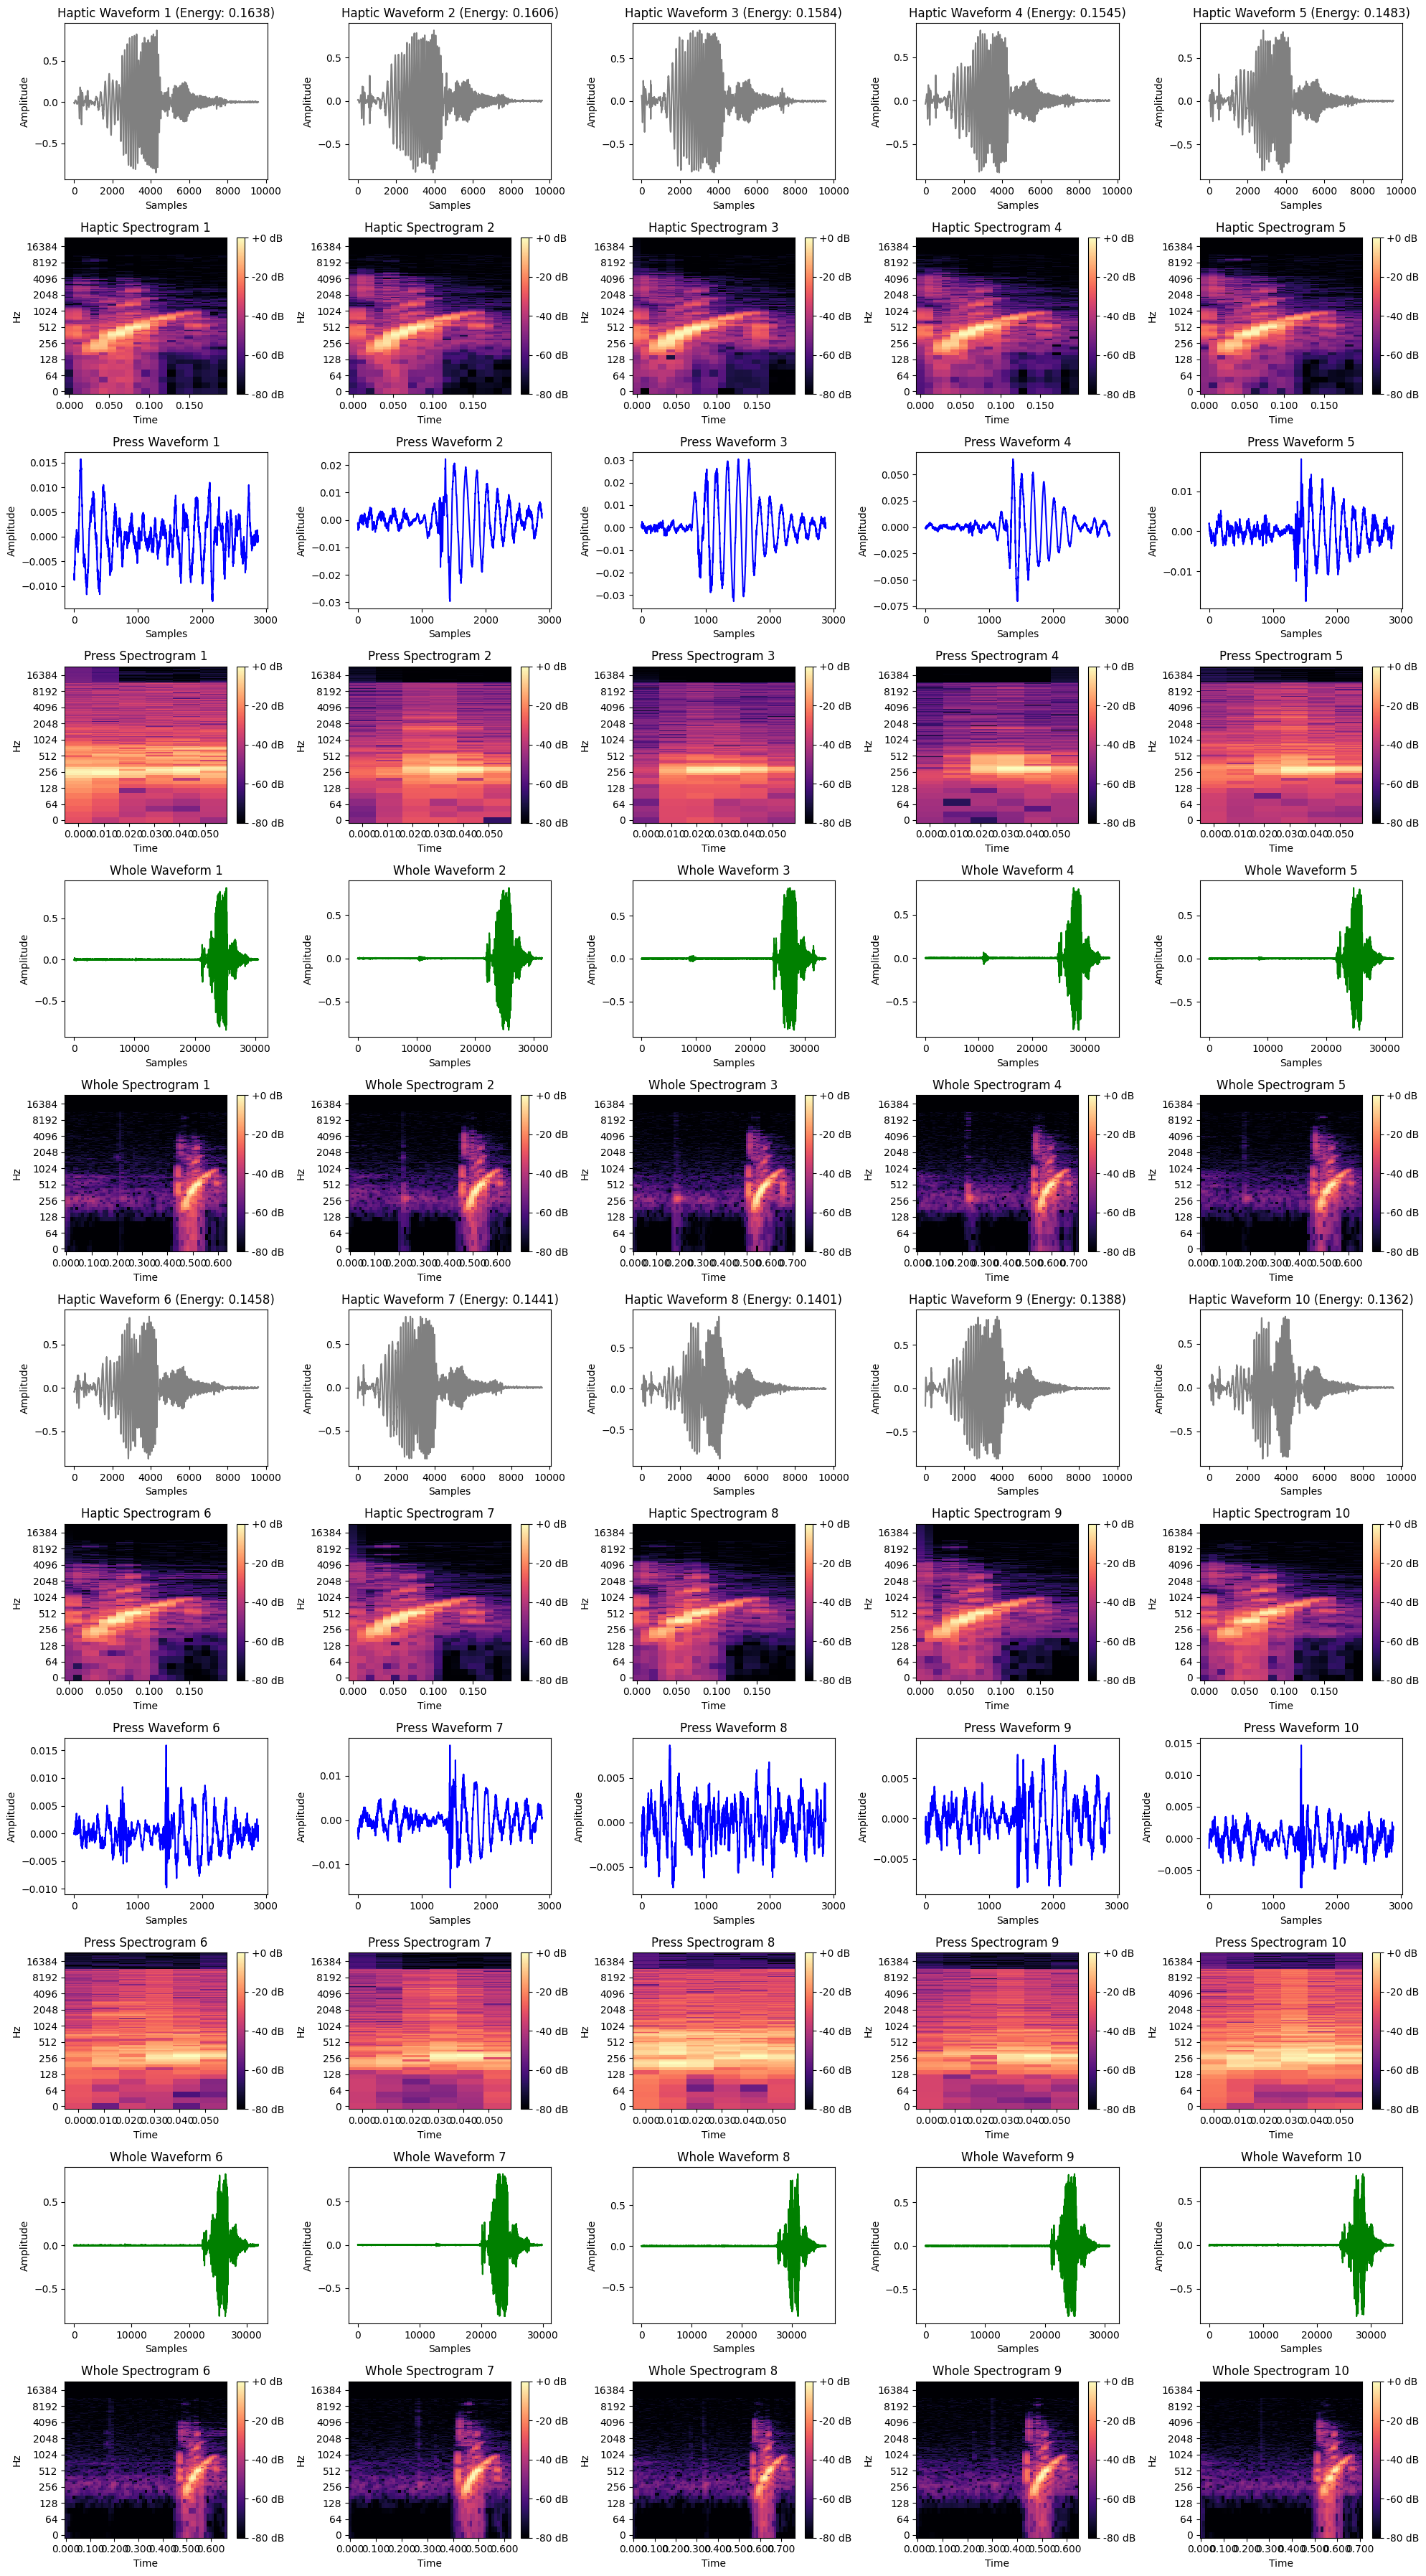

In [239]:
plot_audio_haptic_segments(u1_d2)


In [ ]:
plot_audio_segments(u2_d,48000,max_plots=20,use_whole_audio=True)

In [101]:
def check_overlap(audio_haptic_starttime, duration=0.2):
    """
    Check for any overlaps in the list of audio segment start times.
    Also prints any detected overlaps directly.

    Parameters:
        audio_haptic_starttime (list of float): Start times in seconds.
        duration (float): Duration of each segment in seconds.

    Returns:
        list of (i, j) tuples where segment i overlaps with segment j
    """
    start_times = sorted(audio_haptic_starttime)
    overlaps = []

    print(f"Checking {len(start_times)} segments for overlaps with duration {duration:.3f}s each...")

    for i in range(len(start_times)):
        for j in range(i + 1, len(start_times)):
            if start_times[j] < start_times[i] + duration:
                overlaps.append((i, j))
                print(f"Overlap found: Segment {i} (start={start_times[i]:.3f}s) "
                      f"overlaps with Segment {j} (start={start_times[j]:.3f}s)")
            else:
                break  # since list is sorted, no more overlaps ahead

    if not overlaps:
        print("✅ No overlapping segments found.")

    return overlaps


In [134]:
import matplotlib.pyplot as plt
import numpy as np

def plot_inertial_haptic(inertial_sequence):
    """
    Plot gyro and accelerometer values from a single inertial data sequence.

    Parameters:
        inertial_sequence: A pandas DataFrame containing inertial data with columns
                           ['timestamp', 'button_press', 'gyro_pitch', 'gyro_yaw', 'gyro_roll',
                            'acc_x', 'acc_y', 'acc_z', 'user_id', 'audio_file']
    """
    # Ensure the dataframe has expected columns
    expected_columns = ['gyro_pitch', 'gyro_yaw', 'gyro_roll', 'acc_x', 'acc_y', 'acc_z', 'button_press']
    for col in expected_columns:
        if col not in inertial_sequence.columns:
            raise ValueError(f"Missing expected column: {col}")

    # Create a time index (x-axis), assuming regular sampling
    x = range(len(inertial_sequence))

    plt.figure(figsize=(12, 6))

    # Plot gyro
    plt.subplot(2, 1, 1)
    plt.plot(x, inertial_sequence['gyro_pitch'], label='Gyro Pitch')
    plt.plot(x, inertial_sequence['gyro_yaw'], label='Gyro Yaw')
    plt.plot(x, inertial_sequence['gyro_roll'], label='Gyro Roll')
    
    # Get y-axis limits for gyro plot
    y_min_gyro = min(inertial_sequence['gyro_pitch'].min(), 
                     inertial_sequence['gyro_yaw'].min(), 
                     inertial_sequence['gyro_roll'].min())
    
    # Add button press indicators as colored lines at the bottom
    button_states = inertial_sequence['button_press'].values
    for i in range(len(button_states)):
        if button_states[i] != 'none':
            plt.plot([i, i+1], [y_min_gyro, y_min_gyro], 'r-', linewidth=3)
        else:
            plt.plot([i, i+1], [y_min_gyro, y_min_gyro], 'b-', linewidth=3)
    
    plt.title('Gyroscope Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Gyro Value')
    plt.legend()
    plt.grid(True)

    # Plot accelerometer
    plt.subplot(2, 1, 2)
    plt.plot(x, inertial_sequence['acc_x'], label='Acc X')
    plt.plot(x, inertial_sequence['acc_y'], label='Acc Y')
    plt.plot(x, inertial_sequence['acc_z'], label='Acc Z')
    
    # Get y-axis limits for accelerometer plot
    y_min_acc = min(inertial_sequence['acc_x'].min(), 
                    inertial_sequence['acc_y'].min(), 
                    inertial_sequence['acc_z'].min())
    
    # Add button press indicators as colored lines at the bottom
    for i in range(len(button_states)):
        if button_states[i] != 'none':
            plt.plot([i, i+1], [y_min_acc, y_min_acc], 'r-', linewidth=3, 
                    label='Button Press' if i == 0 and any(s != 'none' for s in button_states) else "")
        else:
            plt.plot([i, i+1], [y_min_acc, y_min_acc], 'b-', linewidth=3,
                    label='No Button Press' if i == 0 else "")
    
    plt.title('Accelerometer Data')
    plt.xlabel('Sample Index')
    plt.ylabel('Acceleration Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [206]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sequence_length_distribution(inertial_whole, audio_whole=None, sample_rate=48000):
    """
    Plot the distribution of sequence lengths from inertial_whole list and mark min/max.
    If audio_whole is provided, also plot the distribution of audio segment durations in seconds.

    Parameters:
        inertial_whole: list of pandas DataFrames or sequences representing inertial data
        audio_whole: list of audio segments (optional)
        sample_rate: audio sample rate in Hz (default: 48000)
    """
    # Get the length of each sequence
    lengths = [len(seq) for seq in inertial_whole]

    # Calculate min and max
    min_len = min(lengths)
    max_len = max(lengths)
    
    # Find the indices of min and max length sequences
    min_idx = lengths.index(min_len)
    max_idx = lengths.index(max_len)
    
    # Print total count of sequences
    total_sequences = len(inertial_whole)
    print(f"Total number of inertial sequences: {total_sequences}")
    print(f"Index of minimum length inertial sequence: {min_idx}")
    print(f"Index of maximum length inertial sequence: {max_idx}")

    # Create figure for inertial data
    plt.figure(figsize=(10, 5))
    # Create histogram and get the counts and bin edges
    counts, bins, patches = plt.hist(lengths, bins=20, edgecolor='black', alpha=0.7)
    
    # Add count labels above each bar
    for i in range(len(counts)):
        if counts[i] > 0:  # Only label bars with non-zero counts
            plt.text(bins[i] + (bins[i+1] - bins[i])/2, counts[i], 
                    int(counts[i]), ha='center', va='bottom')
    
    plt.axvline(min_len, color='red', linestyle='--', label=f'Min length: {min_len}')
    plt.axvline(max_len, color='green', linestyle='--', label=f'Max length: {max_len}')
    plt.title('Distribution of Inertial Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # If audio_whole is provided, plot the distribution of audio segment durations in seconds
    if audio_whole is not None:
        # Get the length of each audio segment
        audio_lengths = [len(seg) for seg in audio_whole]
        
        # Calculate time durations in seconds
        audio_durations = [length / sample_rate for length in audio_lengths]
        audio_min_duration = min(audio_durations)
        audio_max_duration = max(audio_durations)
        
        # Find the indices of min and max duration audio segments
        audio_min_idx = audio_durations.index(audio_min_duration)
        audio_max_idx = audio_durations.index(audio_max_duration)
        
        # Print total count of audio segments and duration info
        total_audio_segments = len(audio_whole)
        print(f"\nTotal number of audio segments: {total_audio_segments}")
        print(f"Index of minimum duration audio segment: {audio_min_idx}")
        print(f"Index of maximum duration audio segment: {audio_max_idx}")
        print(f"Minimum audio duration: {audio_min_duration:.2f} seconds")
        print(f"Maximum audio duration: {audio_max_duration:.2f} seconds")
        
        # Create figure for audio data - time duration only
        plt.figure(figsize=(10, 5))
        # Create histogram and get the counts and bin edges
        duration_counts, duration_bins, duration_patches = plt.hist(audio_durations, bins=20, edgecolor='black', alpha=0.7)
        
        # Add count labels above each bar
        for i in range(len(duration_counts)):
            if duration_counts[i] > 0:  # Only label bars with non-zero counts
                plt.text(duration_bins[i] + (duration_bins[i+1] - duration_bins[i])/2, duration_counts[i], 
                        int(duration_counts[i]), ha='center', va='bottom')
        
        plt.axvline(audio_min_duration, color='red', linestyle='--', 
                   label=f'Min duration: {audio_min_duration:.2f}s')
        plt.axvline(audio_max_duration, color='green', linestyle='--', 
                   label=f'Max duration: {audio_max_duration:.2f}s')
        plt.title('Distribution of Audio Segment Durations')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Total number of inertial sequences: 110
Index of minimum length inertial sequence: 12
Index of maximum length inertial sequence: 102


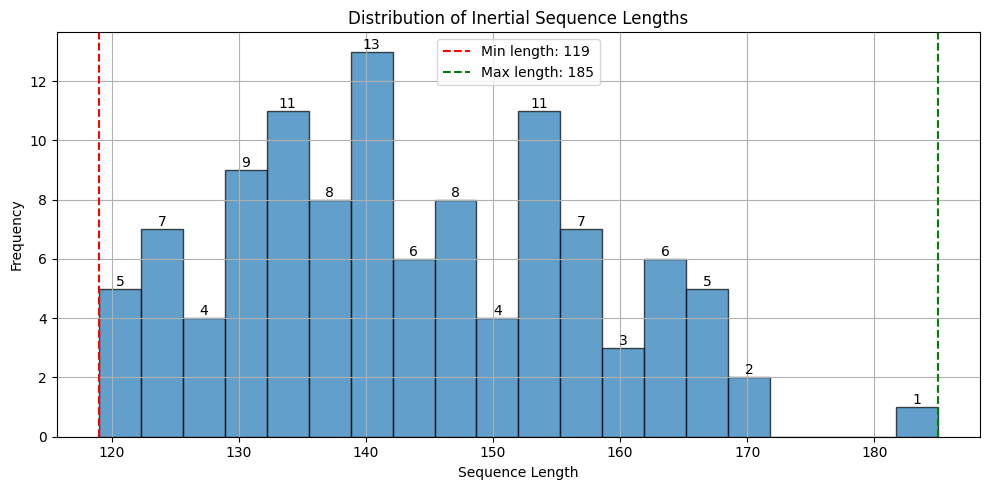


Total number of audio segments: 110
Index of minimum duration audio segment: 17
Index of maximum duration audio segment: 102
Minimum audio duration: 0.59 seconds
Maximum audio duration: 0.82 seconds


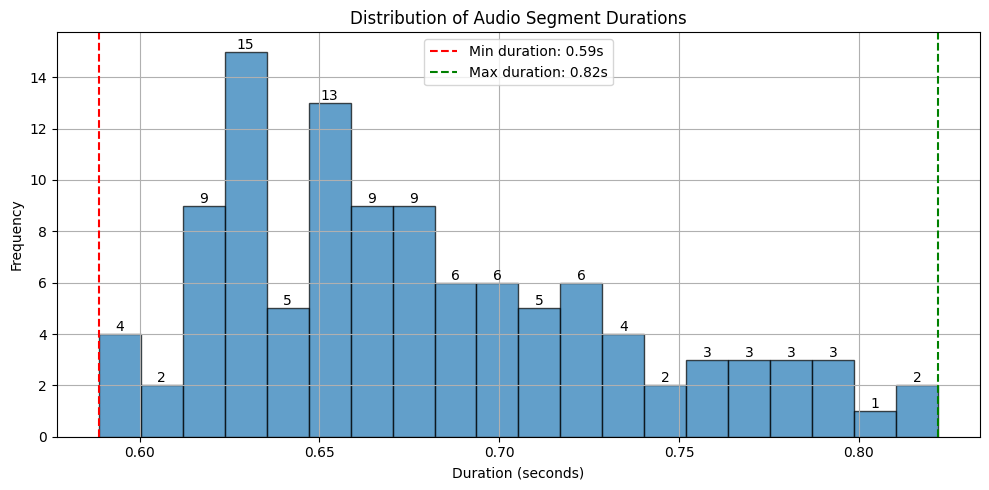

Total number of inertial sequences: 109
Index of minimum length inertial sequence: 27
Index of maximum length inertial sequence: 25


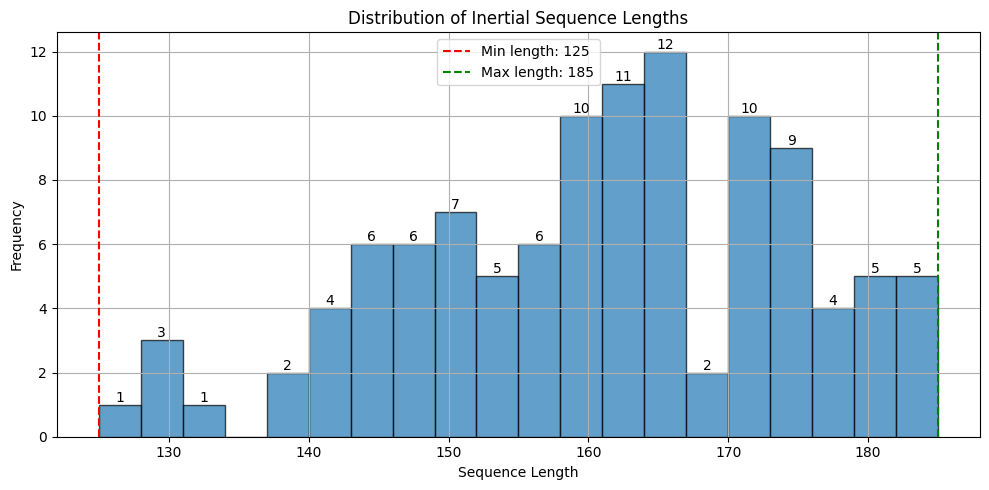


Total number of audio segments: 109
Index of minimum duration audio segment: 11
Index of maximum duration audio segment: 80
Minimum audio duration: 0.57 seconds
Maximum audio duration: 0.88 seconds


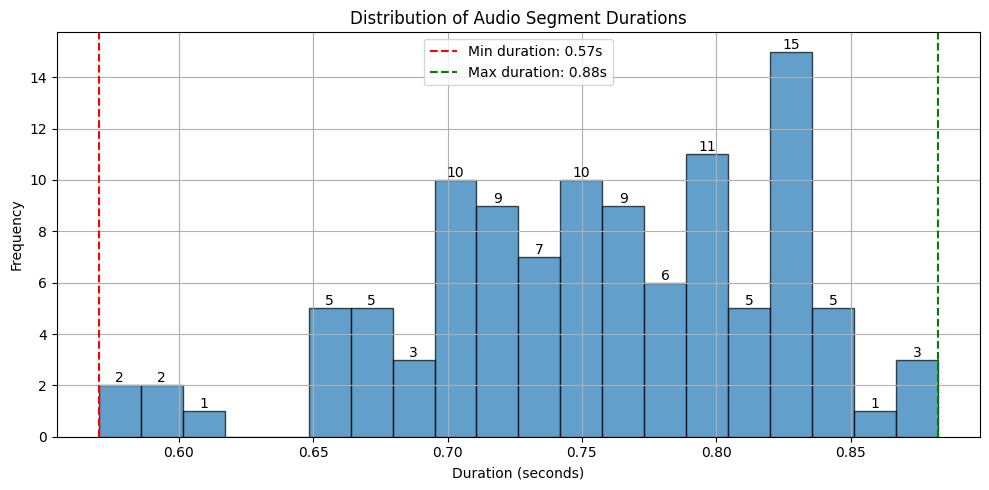

Total number of inertial sequences: 106
Index of minimum length inertial sequence: 6
Index of maximum length inertial sequence: 78


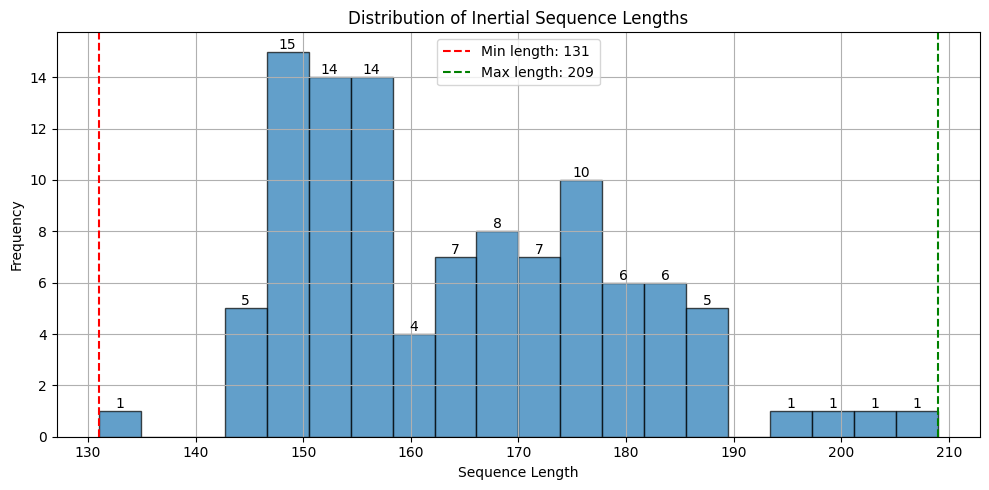


Total number of audio segments: 106
Index of minimum duration audio segment: 6
Index of maximum duration audio segment: 78
Minimum audio duration: 0.62 seconds
Maximum audio duration: 1.03 seconds


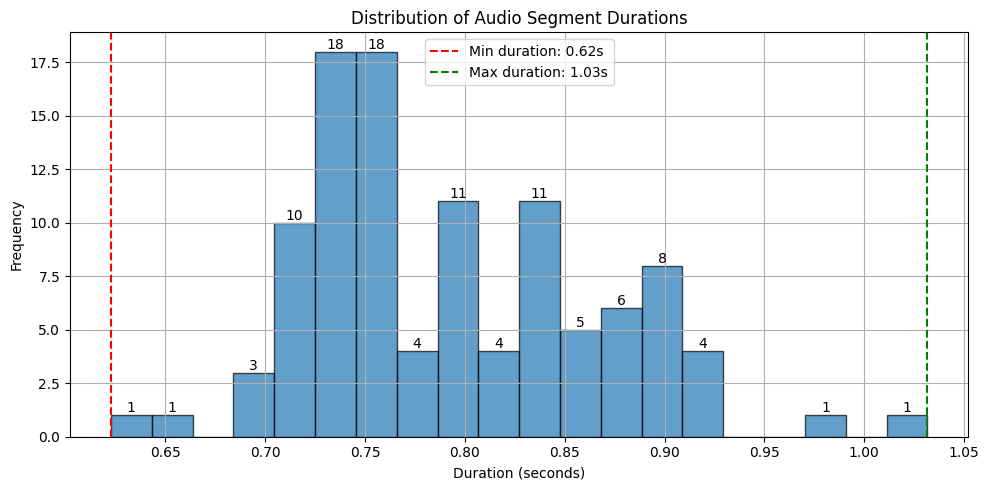

Total number of inertial sequences: 98
Index of minimum length inertial sequence: 75
Index of maximum length inertial sequence: 17


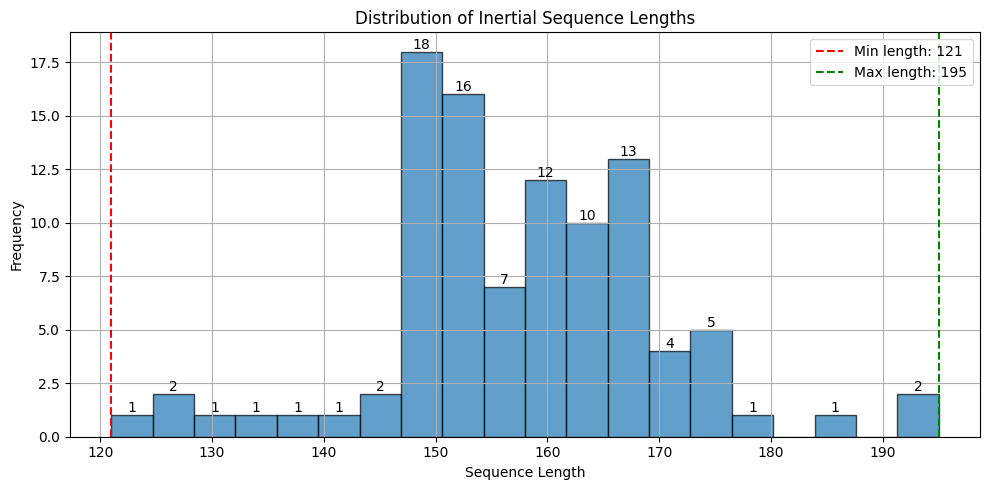


Total number of audio segments: 98
Index of minimum duration audio segment: 75
Index of maximum duration audio segment: 15
Minimum audio duration: 0.60 seconds
Maximum audio duration: 0.89 seconds


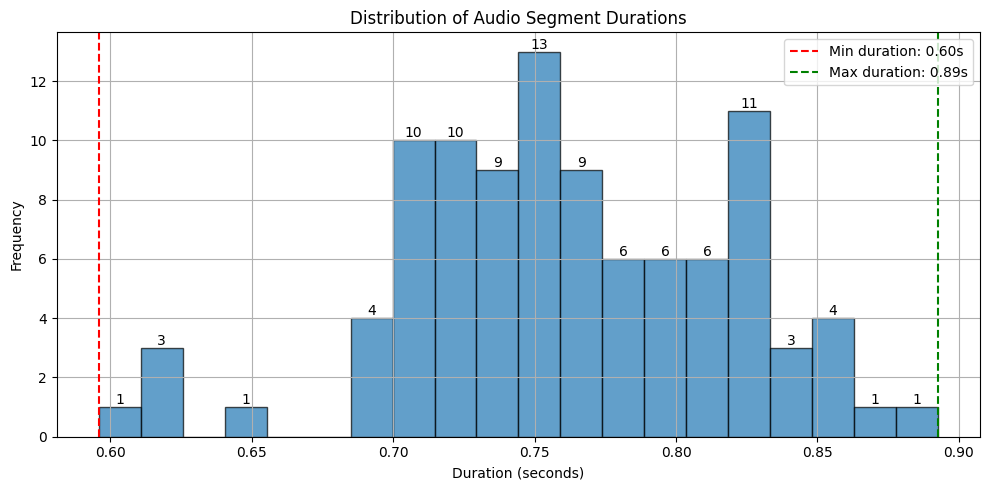

In [240]:
plot_sequence_length_distribution(u1_d2['inertial_whole'],u1_d2['audio_whole'])
plot_sequence_length_distribution(u2_d['inertial_whole'],u2_d['audio_whole'])
plot_sequence_length_distribution(u3_d['inertial_whole'],u3_d['audio_whole'])
plot_sequence_length_distribution(u4_d['inertial_whole'],u4_d['audio_whole'])


In [241]:
def check_dataset_shapes(dataset):
    """
    Checks whether all samples in the selected dataset fields have the same shape or length.
    Also identifies empty data samples in each field.

    Parameters:
        dataset (dict): Dictionary returned by `dataset_prepare`.

    Returns:
        dict: A dictionary containing the shape consistency check for each target field,
              along with the unique shapes/lengths found and empty data information.
    """
    fields_to_check = ['audio_press', 'audio_haptic', 'inertial_haptic', 'inertial_press', 
                      'audio_whole', 'inertial_whole']
    shape_summary = {}

    for field in fields_to_check:
        shapes = []
        empty_samples = []
        
        for i, sample in enumerate(dataset[field]):
            # For numpy arrays (audio)
            if isinstance(sample, np.ndarray):
                shapes.append(sample.shape)
                # Check if array is empty
                if sample.size == 0:
                    empty_samples.append(i)
            # For pandas DataFrame (inertial)
            elif isinstance(sample, pd.DataFrame):
                shapes.append(sample.shape)
                # Check if DataFrame is empty
                if sample.empty:
                    empty_samples.append(i)
            else:
                shapes.append('Unknown')
                empty_samples.append(i)  # Consider unknown types as empty

        unique_shapes = list(set(shapes))
        shape_summary[field] = {
            "all_same_shape": len(unique_shapes) == 1,
            "unique_shapes": unique_shapes,
            "empty_samples_count": len(empty_samples),
            "empty_samples_indices": empty_samples if empty_samples else None,
            "total_samples": len(dataset[field])
        }

    return shape_summary


### Data List ready

In [ ]:
userdata_list = [u1_d2,u2_d,u3_d,u4_d]
for userdata in userdata_list:
    shape_results = check_dataset_shapes(userdata)

    for field, info in shape_results.items():
        print(f"{field}:")
        print(f"  All same shape? {info['all_same_shape']}")
        print(f"  Unique shapes: {info['unique_shapes']}")

In [ ]:
shape_results = check_dataset_shapes(u2_d)

for field, info in shape_results.items():
    print(f"{field}:")
    print(f"  All same shape? {info['all_same_shape']}")
    print(f"  Unique shapes: {info['unique_shapes']}")

In [ ]:
for i in range(len(u4_d['inertial_whole'])):
    print(i)
    plot_inertial_haptic(u4_d['inertial_whole'][i])

In [ ]:
for i in range(len(u3_d['inertial_whole'])):
    print(i)
    plot_inertial_haptic(u3_d['inertial_whole'][i])

In [ ]:
for i in range(100):
    plot_inertial_haptic(u1_d2['inertial_haptic'][i])

In [ ]:
for i in range(100):
    plot_inertial_haptic(u1_d2['inertial_whole'][i])

In [ ]:
for i in range(100):
    plot_inertial_haptic(u2_d['inertial_whole'][i])

# Data set for training 

- original ready data ['audio_press', 'audio_haptic', 'inertial_haptic', 'inertial_press', 】

- press 2-derivea RMS 
- press z-score rms
- haptic  2-Derivetive RMS 
- haptic z-score rms
- a-press mfcc
- a-press spectrogram 
- a-haptic spectrorgam 
- a-haptic mfcc 

In [15]:
import numpy as np
import librosa
from scipy.stats import zscore
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal


def compute_derivative_rms_features(signal, order_list=[1, 2], window=5):
    """
    Compute RMS from 1st and 2nd order derivative over a sliding window.
    
    Args:
        signal (np.ndarray): input array (time, features), like (60, 3)
        order_list (list): which derivatives to compute, default [1,2]
        window (int): window size for sliding RMS

    Returns:
        np.ndarray: output features (time, features * number_of_orders)
    """
    results = []
    original_signal = signal.copy()

    for order in order_list:
        signal = original_signal.copy()
        for _ in range(order):
            signal = np.diff(signal, axis=0)

        if signal.shape[0] < window:
            rms = np.sqrt(np.mean(signal**2, axis=0))
            rms = np.expand_dims(rms, axis=0)  # Make it (1, features)
        else:
            rms = []
            for i in range(signal.shape[0] - window + 1):
                window_data = signal[i:i+window]
                rms.append(np.sqrt(np.mean(window_data**2, axis=0)))
            rms = np.array(rms)  # (time_steps, features)

        results.append(rms)

    # Align time dimension (some might be slightly different length)
    min_len = min(r.shape[0] for r in results)
    results = [r[:min_len] for r in results]

    # Concatenate along features
    output = np.concatenate(results, axis=1)  # (time, features * number of orders)
    return output


def compute_axiswise_zscore_rms(signal, window=5):
    if isinstance(signal, pd.DataFrame):
        acc_data = signal[['acc_x', 'acc_y', 'acc_z', 'gyro_pitch', 'gyro_yaw', 'gyro_roll']].values
    else:
        acc_data = signal

    n_samples, n_axes = acc_data.shape
    z_rms_axes = []

    for axis in range(n_axes):
        axis_data = acc_data[:, axis]
        rms_axis = np.sqrt(pd.Series(axis_data).rolling(window).apply(lambda x: np.mean(x**2)).dropna().values)

        z_rms_axis = []
        for i in range(len(rms_axis) - window + 1):
            segment = rms_axis[i:i+window]

            # Safe z-score and std calculation
            if np.std(segment) < 1e-8:  # very small std -> almost constant
                z_rms_axis.append(0.0)
            else:
                z_rms_axis.append(np.std(zscore(segment)))

        z_rms_axes.append(z_rms_axis)

    return np.array(z_rms_axes).T  # (n_windows, 6)


def denoise_audio_wiener(audio, noise_sample, sr):
    """
    Apply Wiener filter to denoise audio using a noise sample.
    """
    if len(audio) == 0 or len(noise_sample) == 0:
        return audio
    
    # Estimate noise power spectrum
    noise_spec = np.abs(librosa.stft(noise_sample, n_fft=512, hop_length=256)) ** 2
    noise_power = np.mean(noise_spec, axis=1)
    
    # Compute STFT of the signal
    stft_audio = librosa.stft(audio, n_fft=512, hop_length=256)
    spec_audio = np.abs(stft_audio) ** 2
    phase_audio = np.angle(stft_audio)
    
    # Apply Wiener filter
    gain = np.maximum(0, 1 - np.outer(noise_power, np.ones(spec_audio.shape[1])) / (spec_audio + 1e-10))
    spec_denoised = np.sqrt(spec_audio) * gain
    
    # Reconstruct signal
    stft_denoised = spec_denoised * np.exp(1j * phase_audio)
    denoised_audio = librosa.istft(stft_denoised, hop_length=256)
    
    # Ensure same length as original
    if len(denoised_audio) > len(audio):
        denoised_audio = denoised_audio[:len(audio)]
    elif len(denoised_audio) < len(audio):
        denoised_audio = np.pad(denoised_audio, (0, len(audio) - len(denoised_audio)))
    
    return denoised_audio

def plot_spectrograms_comparison(original, denoised, sr, title="Audio Denoising Comparison"):
    """
    Plot spectrograms of original and denoised audio for comparison.
    """
    # First figure: librosa STFT spectrograms
    plt.figure(figsize=(12, 6))
    
    # Original spectrogram
    plt.subplot(1, 2, 1)
    # Use magnitude spectrogram instead of dB scale for smoother visualization
    spec_orig = np.abs(librosa.stft(original, n_fft=512, hop_length=256))
    
    # Calculate time and frequency bins for pcolormesh
    hop_length = 256
    n_fft = 512
    times = np.arange(0, spec_orig.shape[1]) * hop_length / sr
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    
    plt.pcolormesh(times, freqs, spec_orig, shading='auto', cmap='viridis')
    plt.colorbar(format='%.2f')
    plt.title('Original Audio Spectrogram (Magnitude)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    
    # Denoised spectrogram
    plt.subplot(1, 2, 2)
    # Use magnitude spectrogram instead of dB scale for smoother visualization
    spec_denoised = np.abs(librosa.stft(denoised, n_fft=512, hop_length=256))
    
    plt.pcolormesh(times, freqs, spec_denoised, shading='auto', cmap='viridis')
    plt.colorbar(format='%.2f')
    plt.title('Denoised Audio Spectrogram (Magnitude)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    
    plt.suptitle(title + " (librosa STFT)")
    plt.tight_layout()
    plt.show()
    
    # Second figure: signal.spectrogram
    plt.figure(figsize=(12, 6))
    
    # Original spectrogram using signal.spectrogram
    plt.subplot(1, 2, 1)
    f_orig, t_orig, Sxx_orig = signal.spectrogram(original, fs=sr, nperseg=512, noverlap=256)
    plt.pcolormesh(t_orig, f_orig, 10 * np.log10(Sxx_orig + 1e-10), shading='gouraud', cmap='viridis')
    plt.colorbar(format='%.2f')
    plt.title('Original Audio Spectrogram (dB)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    
    # Denoised spectrogram using signal.spectrogram
    plt.subplot(1, 2, 2)
    f_den, t_den, Sxx_den = signal.spectrogram(denoised, fs=sr, nperseg=512, noverlap=256)
    plt.pcolormesh(t_den, f_den, 10 * np.log10(Sxx_den + 1e-10), shading='gouraud', cmap='viridis')
    plt.colorbar(format='%.2f')
    plt.title('Denoised Audio Spectrogram (dB)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    
    plt.suptitle(title + " (scipy.signal.spectrogram)")
    plt.tight_layout()
    plt.show()

def compute_audio_features(audio, sr, noise_sample=None, denoise=False):
    """
    Compute MFCC and Spectrogram for a given audio sample.
    Optional denoising with Wiener filter using provided noise sample.
    """
    if len(audio) == 0:
        return np.zeros((13, 1)), np.zeros((128, 1)), audio
    
    # Apply denoising if requested and noise sample is provided
    if denoise and noise_sample is not None:
        denoised_audio = denoise_audio_wiener(audio, noise_sample, sr)
    else:
        denoised_audio = audio
    
    # Compute spectrogram using STFT
    spectrogram = librosa.amplitude_to_db(
        np.abs(librosa.stft(denoised_audio, n_fft=512, hop_length=256)), ref=np.max)
    
    # Compute MFCCs
    mfcc = librosa.feature.mfcc(
        y=denoised_audio, sr=sr, n_mfcc=13)
    
    # Keep the full 2D arrays with frequency and time dimensions
    # No averaging over time to preserve the time dimension
    
    return mfcc, spectrogram, denoised_audio

def create_feature_dataset(data_dict, plot_denoise_comparison=False):
    """
    Generate feature dataset from multimodal dictionary.
    Returns: List of dicts (one per sample)
    
    Parameters:
    - data_dict: Dictionary containing multimodal data
    - plot_denoise_comparison: If True, plot spectrograms before/after denoising for first 10 samples
    """
    dataset = []
    sr = data_dict['sampling_rate']
    
    for i in range(len(data_dict['audio_haptic'])):
        sample = {}

        # Get noise sample from audio_whole (first 30ms)
        if 'audio_whole' in data_dict and i < len(data_dict['audio_whole']):
            whole_audio = data_dict['audio_whole'][i]
            # Calculate samples for 30ms
            samples_30ms = int(0.03 * sr)
            if len(whole_audio) >= samples_30ms:
                noise_sample = whole_audio[:samples_30ms]
            else:
                noise_sample = whole_audio
        else:
            noise_sample = None

        # Audio Features
        press_audio = data_dict['audio_press'][i]
        haptic_audio = data_dict['audio_haptic'][i]
        
        # Store the raw audio data
        sample['audio_press'] = press_audio
        sample['audio_haptic'] = haptic_audio
        
        # Apply denoising to press_audio only
        press_mfcc, press_spec, denoised_press_audio = compute_audio_features(
            press_audio, sr, noise_sample=noise_sample, denoise=True)
        
        # No denoising for haptic audio
        haptic_mfcc, haptic_spec, _ = compute_audio_features(haptic_audio, sr)
        
        # Plot comparison for first 10 samples if requested
        if plot_denoise_comparison and i < 10:
            plot_spectrograms_comparison(
                press_audio, denoised_press_audio, sr, 
                title=f"Audio Press Denoising Comparison - Sample {i+1}"
            )
        
        # Inertial Features
        press_df = data_dict['inertial_press'][i]
        haptic_df = data_dict['inertial_haptic'][i]
        
        press_acc_gyro = press_df[['acc_x', 'acc_y', 'acc_z','gyro_pitch','gyro_yaw','gyro_roll']].values
        haptic_acc_gyro = haptic_df[['acc_x', 'acc_y', 'acc_z','gyro_pitch','gyro_yaw','gyro_roll']].values
        
        press_deriv_rms = compute_derivative_rms_features(press_acc_gyro)
        press_zscore_rms = compute_axiswise_zscore_rms(press_acc_gyro)
        
        haptic_deriv_rms = compute_derivative_rms_features(haptic_acc_gyro)
        haptic_zscore_rms = compute_axiswise_zscore_rms(haptic_acc_gyro)
        
        # Pad or aggregate to consistent shape (use mean of each for now)
        sample['press_deriv_rms'] = press_deriv_rms
        sample['press_zscore_rms'] = press_zscore_rms
        sample['haptic_deriv_rms'] = haptic_deriv_rms
        sample['haptic_zscore_rms'] = haptic_zscore_rms
        sample['audio_press_mfcc'] = press_mfcc
        sample['audio_press_spec'] = press_spec
        sample['audio_haptic_spec'] = haptic_spec
        sample['audio_haptic_mfcc'] = haptic_mfcc
        
        dataset.append(sample)
    
    return dataset


### Plots and inspect

In [295]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_spectrograms_for_dataset(dataset, max_samples=100):
    """
    Plot spectrograms from the dataset, creating separate figures for press and haptic spectrograms.
    Each figure will display multiple spectrograms arranged in rows of 10.
    Displays results directly in Jupyter Notebook.
    
    Args:
        dataset: List of dictionaries containing 'audio_press_spec' and 'audio_haptic_spec'
        max_samples: Maximum number of samples to plot (default: 100)
    """
    # Limit the number of samples to prevent excessive plotting
    samples_to_plot = min(len(dataset), max_samples)
    
    # Calculate layout dimensions
    n_cols = 10
    n_rows = math.ceil(samples_to_plot / n_cols)
    
    # Create figure for press spectrograms
    plt.figure(figsize=(20, 2 * n_rows))
    plt.suptitle('Press Audio Spectrograms', fontsize=16)
    
    # Plot press spectrograms
    for i in range(samples_to_plot):
        spec = dataset[i]['audio_press_spec']
        
        # Check if the spectrogram is 1D or 2D
        if len(spec.shape) == 1:
            # If 1D, reshape to 2D with a single time frame
            spec = spec.reshape(-1, 1)
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Sample {i}")
        plt.colorbar(shrink=0.6)  # Smaller colorbar to save space
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    plt.show()
    
    # Create figure for haptic spectrograms
    plt.figure(figsize=(20, 2 * n_rows))
    plt.suptitle('Haptic Audio Spectrograms', fontsize=16)
    
    # Plot haptic spectrograms
    for i in range(samples_to_plot):
        spec = dataset[i]['audio_haptic_spec']
        
        # Check if the spectrogram is 1D or 2D
        if len(spec.shape) == 1:
            # If 1D, reshape to 2D with a single time frame
            spec = spec.reshape(-1, 1)
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Sample {i}")
        plt.colorbar(shrink=0.6)  # Smaller colorbar to save space
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    plt.show()
    
    print(f"Displayed {samples_to_plot} spectrograms for both press and haptic audio")

# Example usage:
# plot_spectrograms(dataset)

In [314]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal


def compare_spectrogram_methods(dataset, index=1, sr=48000, field='audio_press'):
    """
    Compare different spectrogram plotting methods for a single sample from the dataset.

    Args:
        dataset (list of dict): List containing your data.
        index (int): Which sample to plot.
        sr (int): Sampling rate of the audio.
        field (str): Which field inside the sample to use (e.g., 'audio_press' or 'audio_haptic').
    """
    # --- Get the audio ---
    audio = dataset[index][field]

    fig, axs = plt.subplots(3, 2, figsize=(18, 14))
    fig.suptitle(f"Spectrogram Comparison for Sample {index} ({field})", fontsize=18)

    n_fft = 512
    hop_length = 256

    # --- 1. Librosa STFT + amplitude_to_db + specshow (standard way) ---
    S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    print(f"STFT Shape: {S.shape} (frequency bins, time frames)")
    img1 = librosa.display.specshow(D, sr=sr, hop_length=hop_length, y_axis='log', x_axis='time', ax=axs[0, 0], cmap='viridis')
    fig.colorbar(img1, ax=axs[0, 0], format="%+2.0f dB")
    axs[0, 0].set_title("Librosa STFT (dB, Log-Frequency)")

    # --- 2. Librosa STFT with pcolormesh (magnitude) ---
    spec_orig = np.abs(S)
    times = np.arange(0, spec_orig.shape[1]) * hop_length / sr
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    pcm = axs[0, 1].pcolormesh(times, freqs, spec_orig, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=axs[0, 1], format='%.2f')
    axs[0, 1].set_title("Librosa STFT (Magnitude)")
    axs[0, 1].set_xlabel("Time (s)")
    axs[0, 1].set_ylabel("Frequency (Hz)")

    # --- 3. Scipy Signal Spectrogram (with dB scale) ---
    f, t, Sxx = signal.spectrogram(audio, fs=sr, nperseg=n_fft, noverlap=hop_length)
    print(f"Scipy Spectrogram Shape: {Sxx.shape} (frequency bins, time frames)")
    pcm2 = axs[1, 0].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    fig.colorbar(pcm2, ax=axs[1, 0], format='%.2f')
    axs[1, 0].set_title("Scipy Signal Spectrogram (dB)")
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Frequency (Hz)")

    # --- 4. Mel-Spectrogram (dB) ---
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=128)
    print(f"Mel-Spectrogram Shape: {mel_spec.shape} (mel bands, time frames)")
    D_mel = librosa.power_to_db(mel_spec, ref=np.max)
    img_mel = librosa.display.specshow(D_mel, sr=sr, hop_length=hop_length, y_axis='mel', x_axis='time', ax=axs[1, 1], cmap='viridis')
    fig.colorbar(img_mel, ax=axs[1, 1], format="%+2.0f dB")
    axs[1, 1].set_title("Mel-Spectrogram (dB)")

    # --- 5. Constant-Q Transform (CQT) ---
    C = np.abs(librosa.cqt(audio, sr=sr))
    print(f"CQT Shape: {C.shape} (frequency bins, time frames)")
    img_cqt = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note', ax=axs[2, 0], cmap='viridis')
    fig.colorbar(img_cqt, ax=axs[2, 0], format="%+2.0f dB")
    axs[2, 0].set_title("Constant-Q Transform (CQT)")

    # --- 6. Raw Imshow of Precomputed Spectrogram if exists ---
    if field + '_spec' in dataset[index]:
        spec = dataset[index][field + '_spec']
        print(f"Precomputed Spectrogram Shape: {spec.shape}")
        if len(spec.shape) == 1:
            spec = spec.reshape(-1, 1)
            print(f"Reshaped to: {spec.shape} (frequency bins, time frames=1)")
        axs[2, 1].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
        axs[2, 1].set_title("Precomputed Spectrogram (Raw)")
    else:
        axs[2, 1].text(0.5, 0.5, 'No precomputed spectrogram found',
                       horizontalalignment='center', verticalalignment='center')
        axs[2, 1].set_title("Precomputed Spectrogram (No Data)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Displayed all spectrogram views for sample index {index} (field: {field})")


### Features Ready

In [16]:
user1=create_feature_dataset(u1_d2)
user2=create_feature_dataset(u2_d)
user3=create_feature_dataset(u3_d)
user4=create_feature_dataset(u4_d)


dataset_list=[user1,user2,user3,user4]
dataset_labels=['1','2','3','4']


In [306]:
print(user1[0].keys())


dict_keys(['audio_press', 'audio_haptic', 'press_deriv_rms', 'press_zscore_rms', 'haptic_deriv_rms', 'haptic_zscore_rms', 'audio_press_mfcc', 'audio_press_spec', 'audio_haptic_spec', 'audio_haptic_mfcc'])


In [ ]:
compare_spectrogram_methods(user1,index=1)

In [ ]:
compare_spectrogram_methods(user1,index=1,field='audio_haptic')

In [17]:
def inspect_feature_dataset(dataset):
    """
    Inspect the structure of the feature dataset:
    - Sample count
    - Feature names and shapes
    """
    print(f"Total samples in dataset: {len(dataset)}")

    if len(dataset) == 0:
        print("Dataset is empty.")
        return

    sample = dataset[0]
    print("\nFeature shapes per sample:")
    for key, value in sample.items():
        if isinstance(value, np.ndarray):
            shape_str = f"{value.shape}"
            if len(value.shape) == 1:
                # For 1D arrays like spectrograms and MFCCs, explain what the dimension represents
                if 'spec' in key:
                    shape_str += f" (frequency bins, time frames not aggregated)"
                elif 'mfcc' in key:
                    shape_str += f" (coefficients, time frames not aggregated)"
            print(f"  {key}: {shape_str}")
        elif isinstance(value, (float, int)):
            # For scalar values, explain they're aggregated from multiple samples
            print(f"  {key}: scalar ({type(value).__name__}) - aggregated from multiple time points")
        else:
            print(f"  {key}: {type(value).__name__}")
    
    # Add summary of dataset structure
    print("\nDataset Structure Summary:")
    print(f"  Number of samples: {len(dataset)}")
    print("  Each sample contains features extracted from audio and inertial data")
    print("  Scalar features are aggregated using mean from time series data")
    print("  Array features preserve frequency information but may be missing time dimension due to aggregation")
    
    # Print detailed information about spectrograms
    print("\nSpectrogram Details:")
    if 'audio_press_spec' in sample:
        print(f"  Press Audio Spectrogram Shape: {sample['audio_press_spec'].shape}")
        print(f"    - Frequency bins: {sample['audio_press_spec'].shape[0]}")
        if len(sample['audio_press_spec'].shape) > 1:
            print(f"    - Time frames: {sample['audio_press_spec'].shape[1]}")
    
    if 'audio_haptic_spec' in sample:
        print(f"  Haptic Audio Spectrogram Shape: {sample['audio_haptic_spec'].shape}")
        print(f"    - Frequency bins: {sample['audio_haptic_spec'].shape[0]}")
        if len(sample['audio_haptic_spec'].shape) > 1:
            print(f"    - Time frames: {sample['audio_haptic_spec'].shape[1]}")


In [18]:
inspect_feature_dataset(user1)
inspect_feature_dataset(user2)
inspect_feature_dataset(user3)
inspect_feature_dataset(user4)





Total samples in dataset: 110

Feature shapes per sample:
  audio_press: (2880,)
  audio_haptic: (9600,)
  press_deriv_rms: (54, 12)
  press_zscore_rms: (52, 6)
  haptic_deriv_rms: (34, 12)
  haptic_zscore_rms: (32, 6)
  audio_press_mfcc: (13, 6)
  audio_press_spec: (257, 12)
  audio_haptic_spec: (257, 38)
  audio_haptic_mfcc: (13, 19)

Dataset Structure Summary:
  Number of samples: 110
  Each sample contains features extracted from audio and inertial data
  Scalar features are aggregated using mean from time series data
  Array features preserve frequency information but may be missing time dimension due to aggregation

Spectrogram Details:
  Press Audio Spectrogram Shape: (257, 12)
    - Frequency bins: 257
    - Time frames: 12
  Haptic Audio Spectrogram Shape: (257, 38)
    - Frequency bins: 257
    - Time frames: 38
Total samples in dataset: 109

Feature shapes per sample:
  audio_press: (2880,)
  audio_haptic: (9600,)
  press_deriv_rms: (54, 12)
  press_zscore_rms: (52, 6)
  hap

# Model for press_spe

## Multi Class-CNN

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. Dataset class
class AudioSpecDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels):
        self.samples = []
        self.labels = []
        
        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                spec = sample['audio_press_spec']  # Shape (257, 12)
                self.samples.append(spec)
                self.labels.append(int(label))
        
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        spec = self.samples[idx]
        label = self.labels[idx]
        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(label - 1, dtype=torch.long)  # Shift to 0-3 classes
        return spec, label

# 2. CNN Model
class AudioCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AudioCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 2))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 2, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# 3. Train function
def train_model(dataset_list, dataset_labels, epochs=20, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # ===== Data Preparation Phase =====
    # Create dataset from the provided data
    full_dataset = AudioSpecDataset(dataset_list, dataset_labels)

    # Split dataset into train and validation sets
    from sklearn.model_selection import train_test_split

    # Stratified split to maintain class distribution
    train_idx, val_idx = train_test_split(np.arange(len(full_dataset)), test_size=0.2, stratify=full_dataset.labels, random_state=42)

    # Create subset datasets for training and validation
    train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
    val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ===== Model Preparation Phase =====
    # Initialize the CNN model
    model = AudioCNN(num_classes=len(set(dataset_labels)))
    model = model.to(device)  # Move model to GPU if available
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Dictionary to store training history
    history = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    # ===== Training Loop =====
    for epoch in range(epochs):
        # ----- Training Phase -----
        model.train()  # Set model to training mode
        train_losses = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            train_losses.append(loss.item())  # Store loss value

        # ----- Evaluation Phase -----
        model.eval()  # Set model to evaluation mode
        val_losses = []
        preds = []
        truths = []

        with torch.no_grad():  # No need to track gradients during evaluation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                val_losses.append(loss.item())  # Store loss value

                # Get predictions
                pred = outputs.argmax(dim=1)
                preds.extend(pred.cpu().numpy())
                truths.extend(labels.cpu().numpy())

        # Calculate metrics
        acc = accuracy_score(truths, preds)
        prec = precision_score(truths, preds, average='weighted', zero_division=0)
        rec = recall_score(truths, preds, average='weighted', zero_division=0)
        f1 = f1_score(truths, preds, average='weighted', zero_division=0)

        # Store metrics in history
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))
        history['accuracy'].append(acc)
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['f1'].append(f1)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | Acc: {acc:.4f}")

    return model, history

# 4. Example usage (in your notebook)
# model, history = train_model(dataset_list, dataset_labels, epochs=30)


In [14]:
result_model,result_histroy=train_model(dataset_list, dataset_labels, epochs=100)


Epoch 1/100 | Train Loss: 1.4228 | Val Loss: 1.3629 | Acc: 0.2471
Epoch 2/100 | Train Loss: 1.3347 | Val Loss: 1.3234 | Acc: 0.3882
Epoch 3/100 | Train Loss: 1.2876 | Val Loss: 1.1873 | Acc: 0.4588
Epoch 4/100 | Train Loss: 1.1452 | Val Loss: 1.0415 | Acc: 0.5294
Epoch 5/100 | Train Loss: 1.0722 | Val Loss: 1.1304 | Acc: 0.5059
Epoch 6/100 | Train Loss: 1.0102 | Val Loss: 0.9678 | Acc: 0.5412
Epoch 7/100 | Train Loss: 0.9192 | Val Loss: 1.0658 | Acc: 0.4824
Epoch 8/100 | Train Loss: 0.9631 | Val Loss: 0.9437 | Acc: 0.5176
Epoch 9/100 | Train Loss: 0.8319 | Val Loss: 0.9165 | Acc: 0.6471
Epoch 10/100 | Train Loss: 0.8416 | Val Loss: 0.8123 | Acc: 0.6941
Epoch 11/100 | Train Loss: 0.8238 | Val Loss: 0.8603 | Acc: 0.6353
Epoch 12/100 | Train Loss: 0.7763 | Val Loss: 0.7644 | Acc: 0.7059
Epoch 13/100 | Train Loss: 0.7584 | Val Loss: 0.8035 | Acc: 0.6588
Epoch 14/100 | Train Loss: 0.7594 | Val Loss: 0.7838 | Acc: 0.7059
Epoch 15/100 | Train Loss: 0.6909 | Val Loss: 0.7762 | Acc: 0.6941
Epoc

## Binary Classifer - CNN

In [20]:
## import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve

# 1. Binary Dataset class
class AudioSpecBinaryDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label):
        self.samples = []
        self.labels = []
        
        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                spec = sample['audio_press_spec']
                self.samples.append(spec)
                self.labels.append(1 if label == target_label else 0)
        
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        spec = self.samples[idx]
        label = self.labels[idx]
        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        return spec, label

# 2. Binary CNN Model
class AudioCNNBinary(nn.Module):
    def __init__(self):
        super(AudioCNNBinary, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 1, 128),  # depends on your pooling, this is for (B, 64, 32, 1) after pooling
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # Binary output
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x.squeeze(1)

# 3. Train function

def train_binary_models(dataset_list, dataset_labels, epochs=20, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    label_metrics = {}

    for target_label in dataset_labels:
        print(f"Training model for label {target_label}")
        
        dataset = AudioSpecBinaryDataset(dataset_list, dataset_labels, target_label)

        from sklearn.model_selection import train_test_split
        train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)

        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = AudioCNNBinary().to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        history = {'train_loss': [], 'val_loss': [], 'acc': [], 'far': [], 'frr': [], 'eer': []}

        for epoch in range(epochs):
            model.train()
            train_losses = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            preds = []
            truths = []

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_losses.append(loss.item())
                    preds.extend(outputs.cpu().numpy())
                    truths.extend(labels.cpu().numpy())

            preds_bin = (np.array(preds) >= 0).astype(int)
            truths = np.array(truths).astype(int)

            acc = accuracy_score(truths, preds_bin)

            fpr, tpr, thresholds = roc_curve(truths, preds)
            fnr = 1 - tpr
            eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
            eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

            far = np.mean(preds_bin[truths == 0])
            frr = 1 - np.mean(preds_bin[truths == 1])

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(np.mean(val_losses))
            history['acc'].append(acc)
            history['far'].append(far)
            history['frr'].append(frr)
            history['eer'].append(eer)

            print(f"Label {target_label} | Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | Acc: {acc:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | EER: {eer:.4f}")

        label_metrics[target_label] = history

    return label_metrics

In [18]:

# 4. After training, summarize all

def summarize_metrics(label_metrics):
    import pandas as pd

    summary = []

    for label, hist in label_metrics.items():
        best_idx = np.argmax(hist['acc'])
        summary.append({
            'Label': label,
            'Acc': hist['acc'][best_idx],
            'FAR': hist['far'][best_idx],
            'FRR': hist['frr'][best_idx],
            'EER': hist['eer'][best_idx]
        })

        # Plot train/val loss and accuracy
        epochs = np.arange(1, len(hist['train_loss']) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, hist['train_loss'], label='Train Loss')
        plt.plot(epochs, hist['val_loss'], label='Val Loss')
        plt.title(f"Loss - Label {label}")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, hist['acc'], label='Accuracy')
        plt.title(f"Accuracy - Label {label}")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    df = pd.DataFrame(summary)
    avg = df[['Acc', 'FAR', 'FRR', 'EER']].mean()
    std = df[['Acc', 'FAR', 'FRR', 'EER']].std()

    print("\nAverage Metrics:")
    print(avg)
    print("\nStd of Metrics:")
    print(std)

    return df


In [17]:
label_metrics = train_binary_models(dataset_list, dataset_labels, epochs=100)



Training model for label 1
Label 1 | Epoch 1/100 | Train Loss: 0.7782 | Val Loss: 0.5886 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.4286
Label 1 | Epoch 2/100 | Train Loss: 0.5776 | Val Loss: 0.5675 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.4286
Label 1 | Epoch 3/100 | Train Loss: 0.5734 | Val Loss: 0.5678 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.4762
Label 1 | Epoch 4/100 | Train Loss: 0.5648 | Val Loss: 0.5570 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3968
Label 1 | Epoch 5/100 | Train Loss: 0.5527 | Val Loss: 0.5474 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3016
Label 1 | Epoch 6/100 | Train Loss: 0.5481 | Val Loss: 0.5379 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3016
Label 1 | Epoch 7/100 | Train Loss: 0.5086 | Val Loss: 0.5449 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3333
Label 1 | Epoch 8/100 | Train Loss: 0.4941 | Val Loss: 0.5216 | Acc: 0.8588 | FAR: 0.0317 | FRR: 0.4545 | EER: 0.3333
Label 1 | Epoch 9/100 | Train

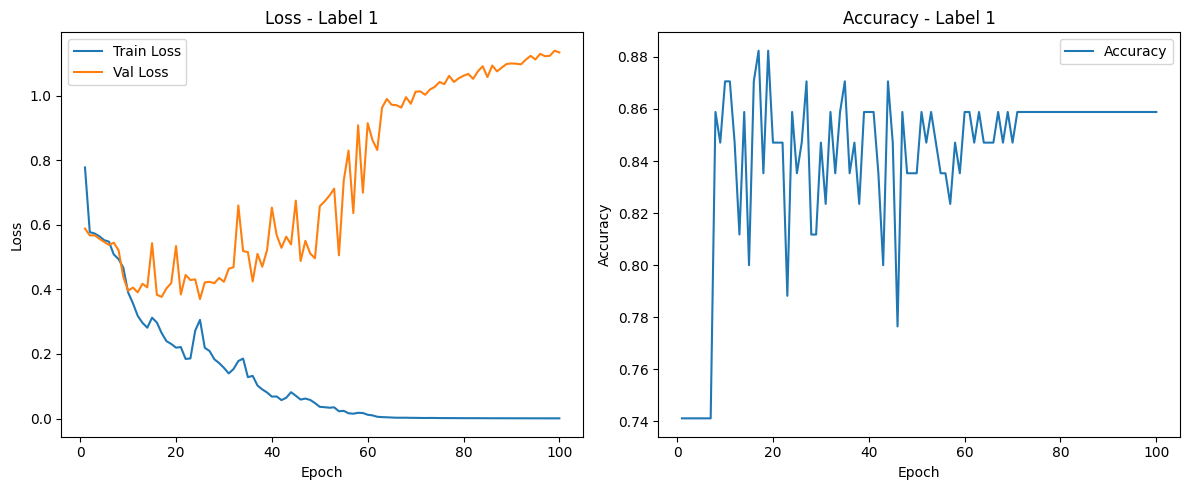

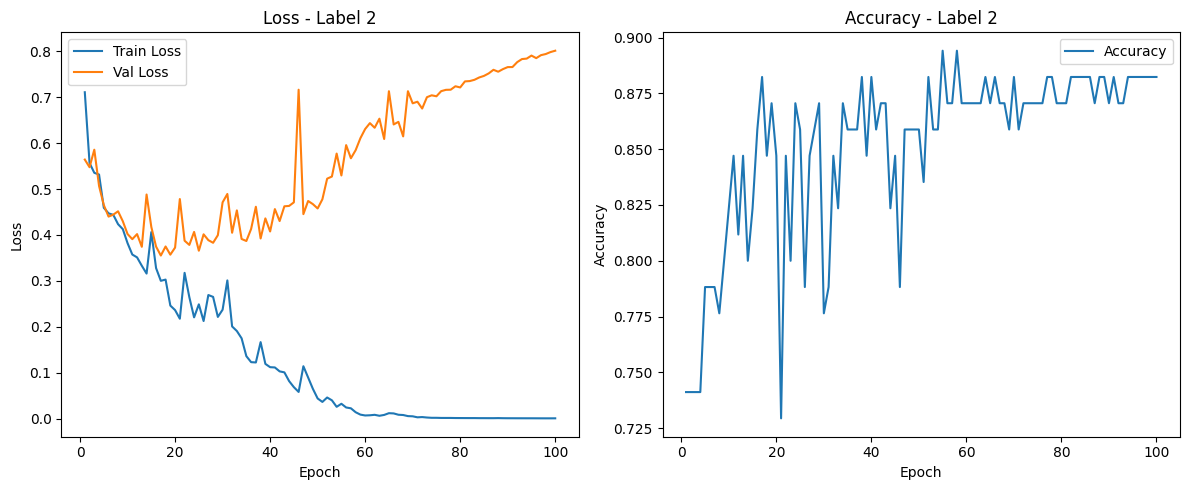

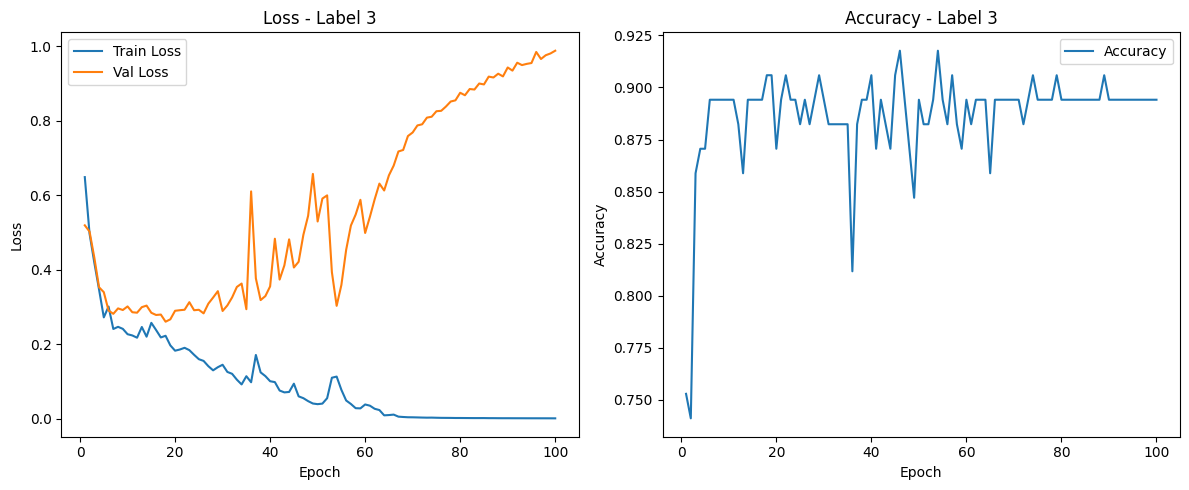

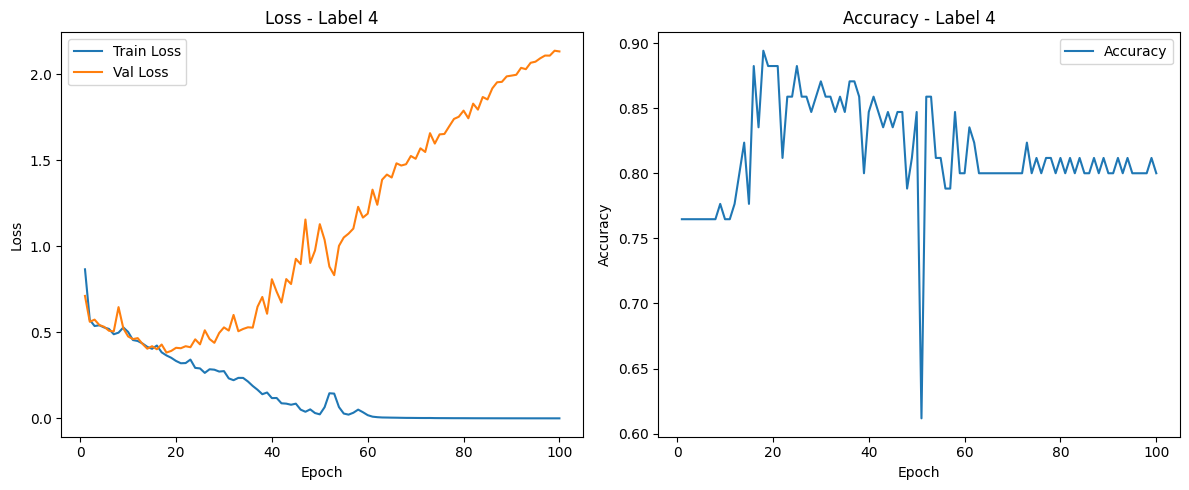


Average Metrics:
Acc    0.897059
FAR    0.035466
FRR    0.307305
EER    0.255427
dtype: float64

Std of Metrics:
Acc    0.014804
FAR    0.032445
FRR    0.146254
EER    0.102121
dtype: float64


Label       Acc       FAR       FRR       EER
0     1  0.882353  0.015873  0.409091  0.317460
1     2  0.894118  0.063492  0.227273  0.333333
2     3  0.917647  0.062500  0.142857  0.109375
3     4  0.894118  0.000000  0.450000  0.261538

In [19]:
summarize_metrics(label_metrics)

Training model for label 1
Label 1 | Epoch 1/20 | Train Loss: 0.6589 | Val Loss: 0.5592 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3492
Label 1 | Epoch 2/20 | Train Loss: 0.5585 | Val Loss: 0.5128 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.3175
Label 1 | Epoch 3/20 | Train Loss: 0.4652 | Val Loss: 0.4229 | Acc: 0.8706 | FAR: 0.0000 | FRR: 0.5000 | EER: 0.2381
Label 1 | Epoch 4/20 | Train Loss: 0.4228 | Val Loss: 0.4052 | Acc: 0.8471 | FAR: 0.0794 | FRR: 0.3636 | EER: 0.2063
Label 1 | Epoch 5/20 | Train Loss: 0.3425 | Val Loss: 0.3660 | Acc: 0.8824 | FAR: 0.0317 | FRR: 0.3636 | EER: 0.3016
Label 1 | Epoch 6/20 | Train Loss: 0.3189 | Val Loss: 0.3679 | Acc: 0.8941 | FAR: 0.0000 | FRR: 0.4091 | EER: 0.2857
Label 1 | Epoch 7/20 | Train Loss: 0.2768 | Val Loss: 0.3661 | Acc: 0.8706 | FAR: 0.0476 | FRR: 0.3636 | EER: 0.2540
Label 1 | Epoch 8/20 | Train Loss: 0.2802 | Val Loss: 0.3698 | Acc: 0.8941 | FAR: 0.0000 | FRR: 0.4091 | EER: 0.2540
Label 1 | Epoch 9/20 | Train Loss: 0.

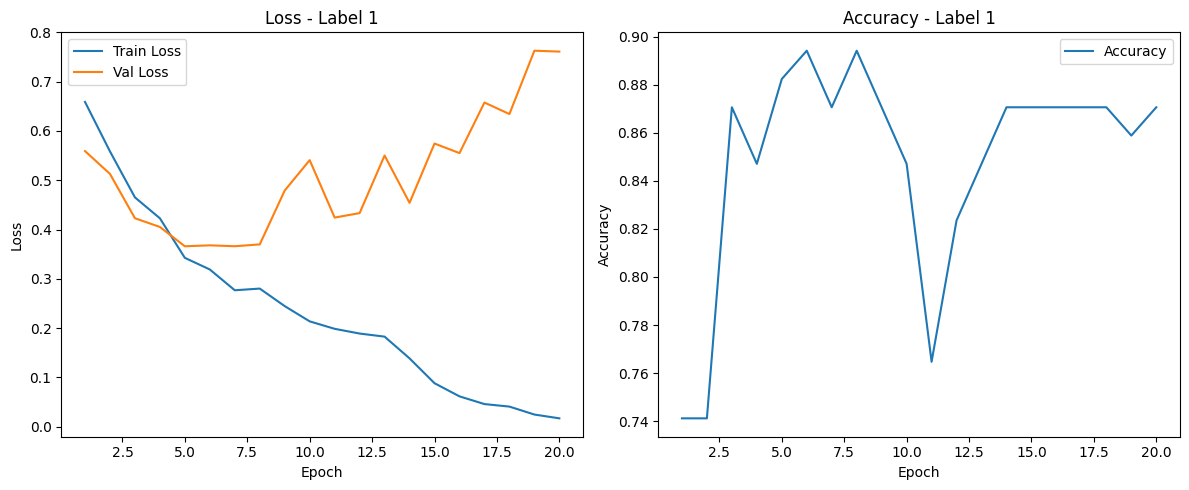

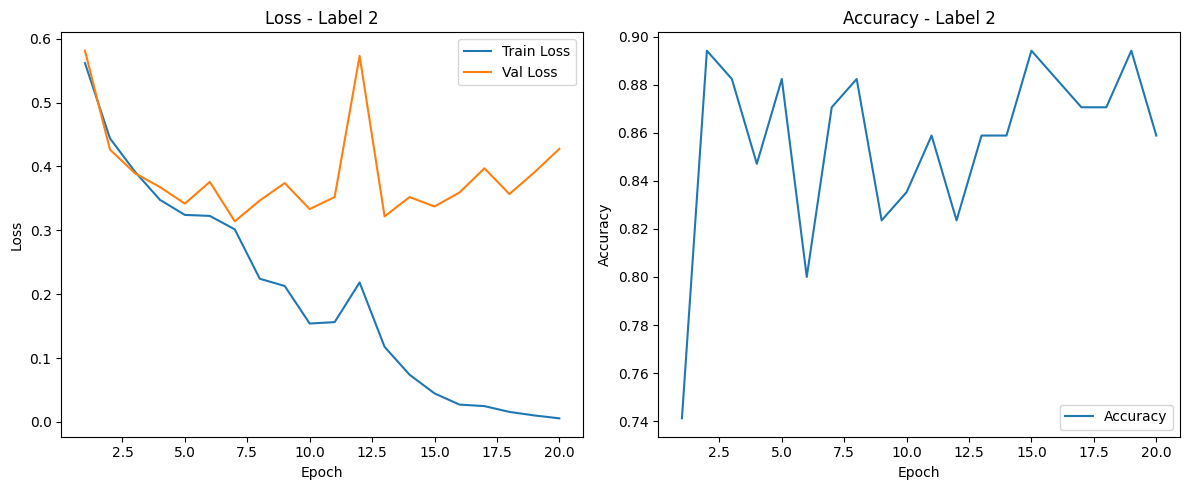

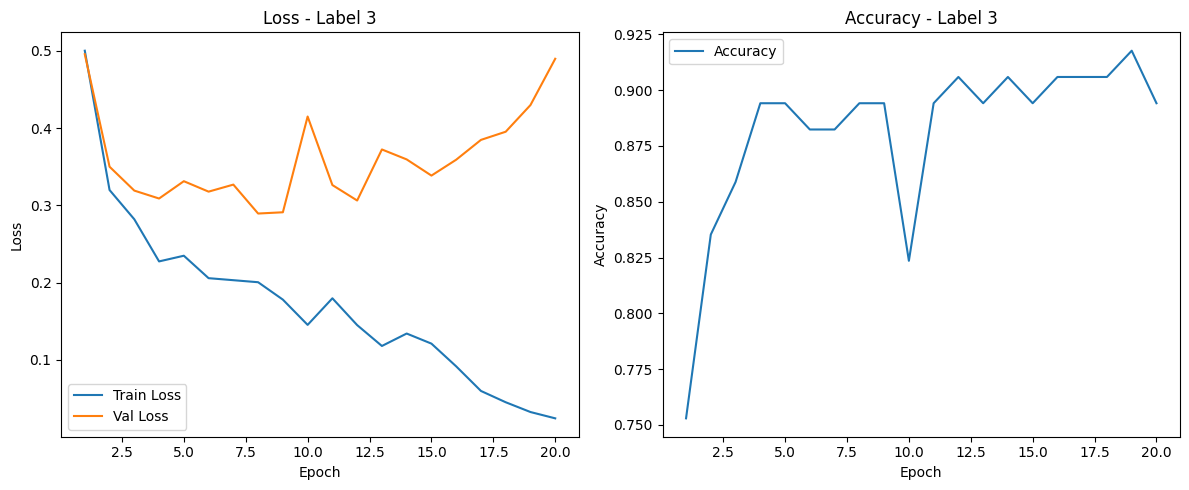

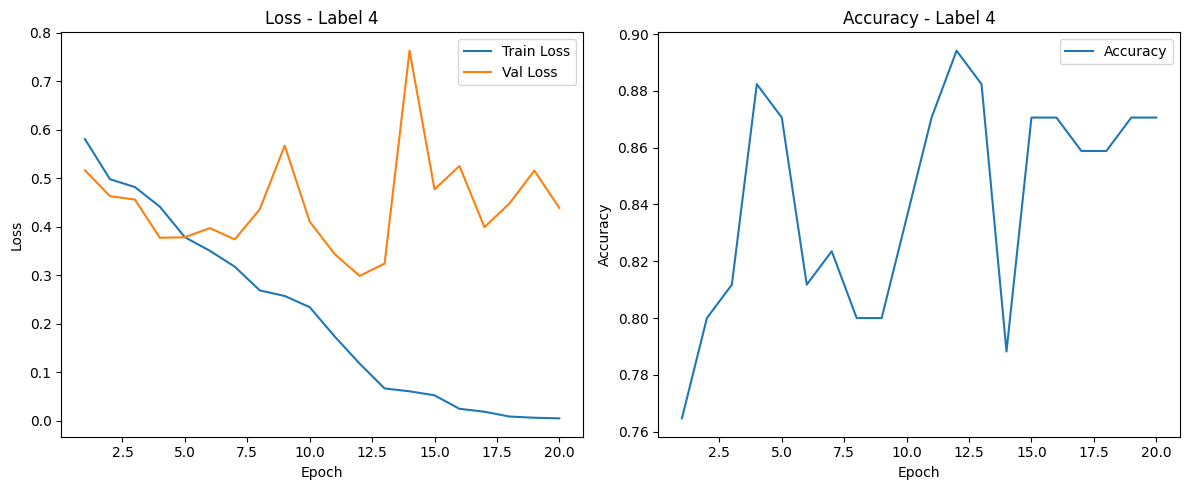


Average Metrics:
Acc    0.900000
FAR    0.035342
FRR    0.294859
EER    0.188761
dtype: float64

Std of Metrics:
Acc    0.011765
FAR    0.044946
FRR    0.181416
EER    0.079829
dtype: float64


Label       Acc       FAR       FRR       EER
0     1  0.894118  0.000000  0.409091  0.285714
1     2  0.894118  0.047619  0.272727  0.206349
2     3  0.917647  0.093750  0.047619  0.093750
3     4  0.894118  0.000000  0.450000  0.169231

In [23]:
label_metrics = train_binary_models(dataset_list, dataset_labels, epochs=20)
summarize_metrics(label_metrics)

# Model for press_mfcc

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix

# 1. Dataset class for MFCC
class AudioMFCCBinaryDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label):
        self.samples = []
        self.labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                mfcc = sample['audio_press_mfcc']  # Shape (13, 6)
                self.samples.append(mfcc)
                self.labels.append(1 if label == target_label else 0)

        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        mfcc = self.samples[idx]
        label = self.labels[idx]
        mfcc = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        return mfcc, label

# 2. CNN Model for MFCC binary classification
class MFCC_CNN_Binary(nn.Module):
    def __init__(self):
        super(MFCC_CNN_Binary, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 1))
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 1, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x.squeeze(1)

# 3. Training function

def train_mfcc_binary_models(dataset_list, dataset_labels, epochs=20, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    label_metrics = {}

    for target_label in dataset_labels:
        print(f"Training MFCC model for label {target_label}")

        dataset = AudioMFCCBinaryDataset(dataset_list, dataset_labels, target_label)

        from sklearn.model_selection import train_test_split
        train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)

        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)

        # Count samples in train and validation sets
        train_labels = [dataset.labels[i] for i in train_idx]
        val_labels = [dataset.labels[i] for i in val_idx]
        
        train_target_count = sum(train_labels)
        train_non_target_count = len(train_labels) - train_target_count
        val_target_count = sum(val_labels)
        val_non_target_count = len(val_labels) - val_target_count
        
        print(f"Training set: {len(train_labels)} samples - Target: {train_target_count}, Non-target: {train_non_target_count}")
        print(f"Validation set: {len(val_labels)} samples - Target: {val_target_count}, Non-target: {val_non_target_count}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = MFCC_CNN_Binary().to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        history = {'train_loss': [], 'val_loss': [], 'acc': [], 'far': [], 'frr': [], 'eer': []}

        for epoch in range(epochs):
            model.train()
            train_losses = []

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            preds = []
            truths = []

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_losses.append(loss.item())
                    preds.extend(outputs.cpu().numpy())
                    truths.extend(labels.cpu().numpy())

            preds_bin = (np.array(preds) >= 0).astype(int)
            truths = np.array(truths).astype(int)

            acc = accuracy_score(truths, preds_bin)

            fpr, tpr, thresholds = roc_curve(truths, preds)
            fnr = 1 - tpr
            eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
            eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

            far = np.mean(preds_bin[truths == 0])
            frr = 1 - np.mean(preds_bin[truths == 1])

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(np.mean(val_losses))
            history['acc'].append(acc)
            history['far'].append(far)
            history['frr'].append(frr)
            history['eer'].append(eer)

            print(f"Label {target_label} | Epoch {epoch+1}/{epochs} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {np.mean(val_losses):.4f} | Acc: {acc:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | EER: {eer:.4f}")

        # After training, compute and print confusion matrix
        model.eval()
        final_preds = []
        final_truths = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                final_preds.extend((outputs.cpu().numpy() >= 0).astype(int))
                final_truths.extend(labels.cpu().numpy().astype(int))
        
        cm = confusion_matrix(final_truths, final_preds)
        print(f"\nConfusion Matrix for Label {target_label}:")
        print("True Negative, False Positive")
        print("False Negative, True Positive")
        print(cm)
        print()

        label_metrics[target_label] = history

    return label_metrics

# Example usage
# mfcc_label_metrics = train_mfcc_binary_models(dataset_list, dataset_labels, epochs=30)


Training MFCC model for label 1
Training set: 338 samples - Target: 88, Non-target: 250
Validation set: 85 samples - Target: 22, Non-target: 63
Label 1 | Epoch 1/100 | Train Loss: 0.5773 | Val Loss: 0.5928 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.2857
Label 1 | Epoch 2/100 | Train Loss: 0.4735 | Val Loss: 0.5130 | Acc: 0.7412 | FAR: 0.0000 | FRR: 1.0000 | EER: 0.2381
Label 1 | Epoch 3/100 | Train Loss: 0.4132 | Val Loss: 0.4263 | Acc: 0.7882 | FAR: 0.0000 | FRR: 0.8182 | EER: 0.2698
Label 1 | Epoch 4/100 | Train Loss: 0.3609 | Val Loss: 0.4235 | Acc: 0.8118 | FAR: 0.1746 | FRR: 0.2273 | EER: 0.2698
Label 1 | Epoch 5/100 | Train Loss: 0.3148 | Val Loss: 0.3751 | Acc: 0.8471 | FAR: 0.0159 | FRR: 0.5455 | EER: 0.2063
Label 1 | Epoch 6/100 | Train Loss: 0.3004 | Val Loss: 0.4240 | Acc: 0.8235 | FAR: 0.0000 | FRR: 0.6818 | EER: 0.1429
Label 1 | Epoch 7/100 | Train Loss: 0.2663 | Val Loss: 0.4046 | Acc: 0.8235 | FAR: 0.0159 | FRR: 0.6364 | EER: 0.1746
Label 1 | Epoch 8/100 | Train 

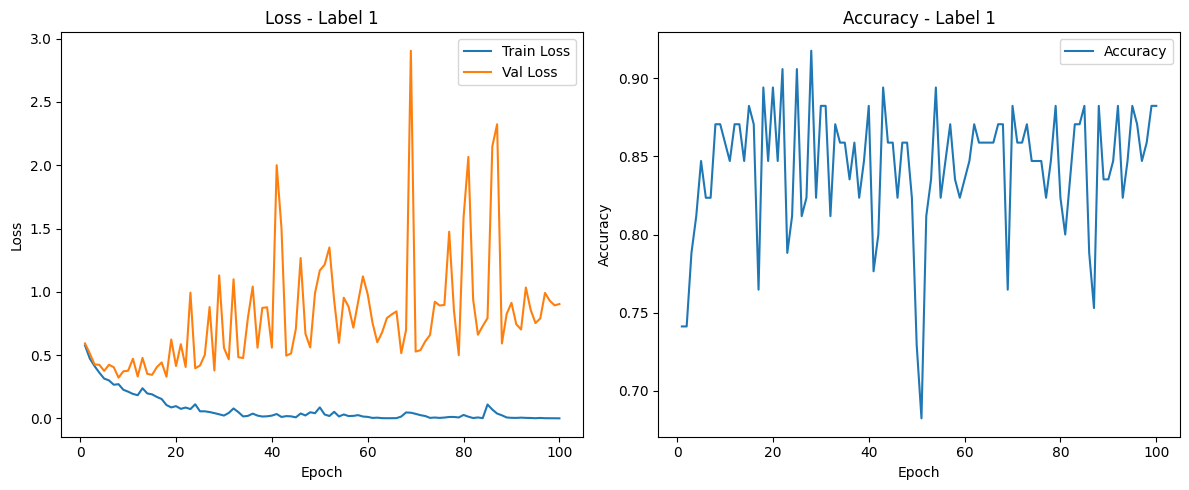

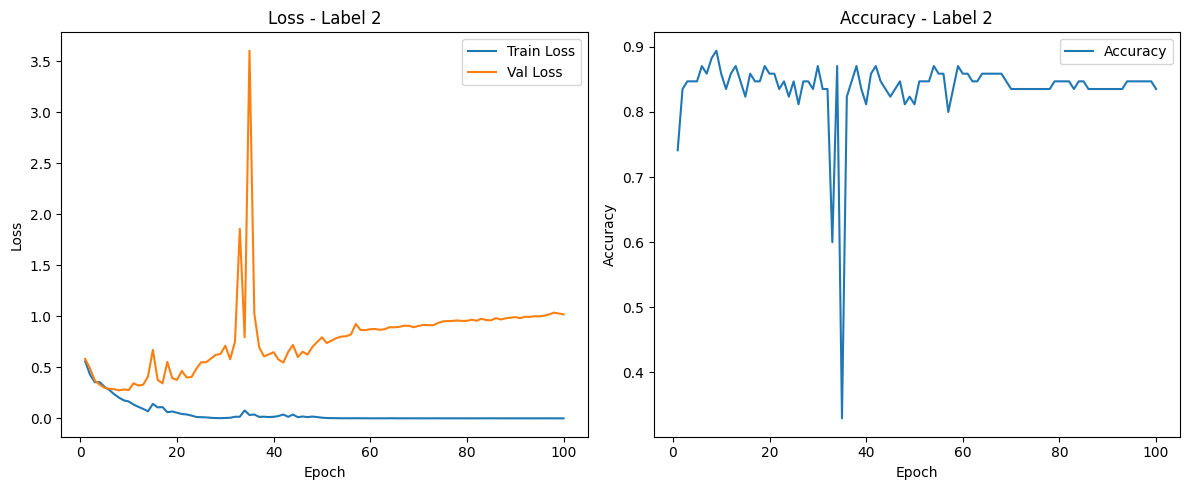

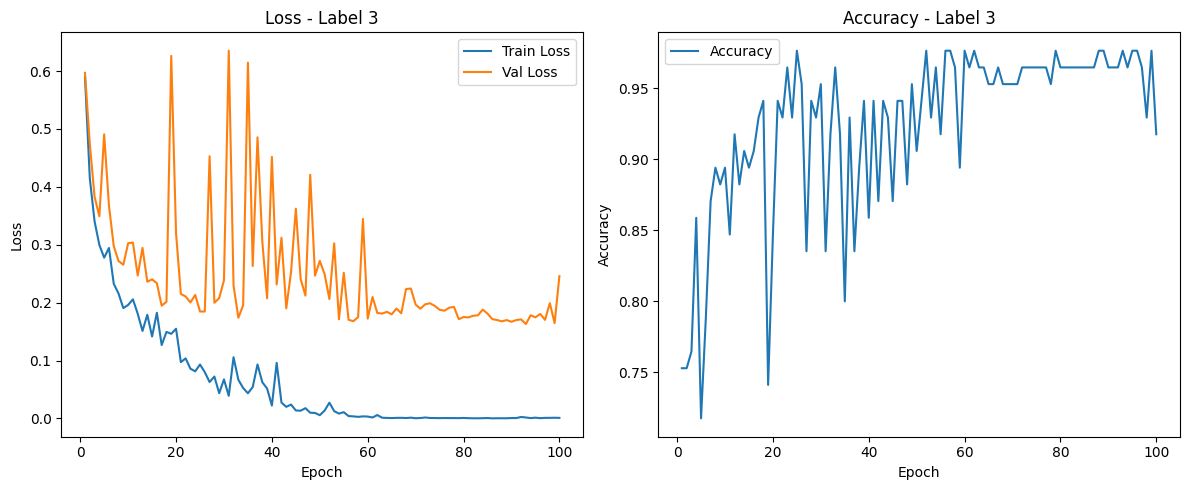

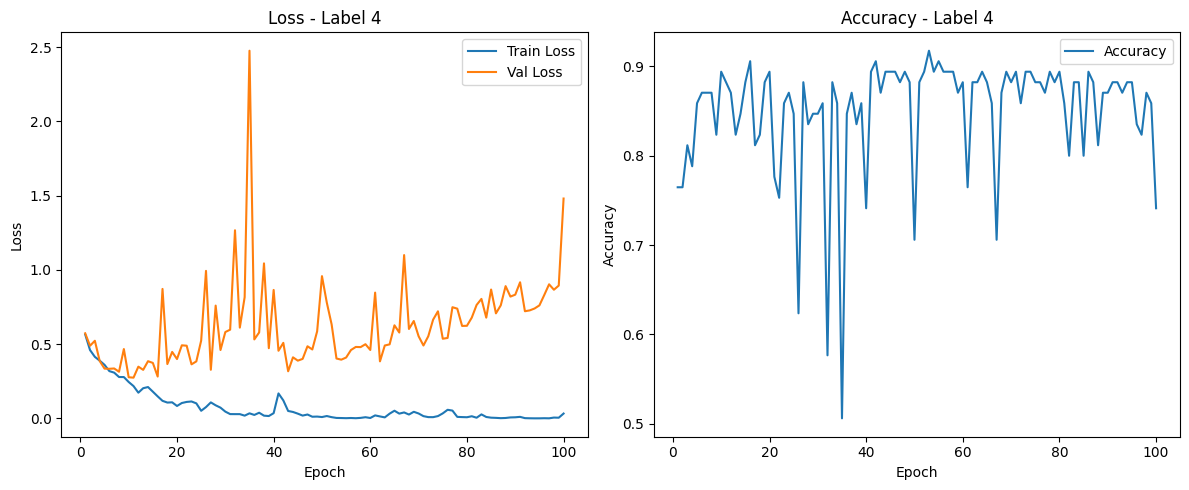


Average Metrics:
Acc    0.926471
FAR    0.043222
FRR    0.164177
EER    0.089987
dtype: float64

Std of Metrics:
Acc    0.035130
FAR    0.027131
FRR    0.079919
EER    0.058214
dtype: float64


Label       Acc       FAR       FRR       EER
0     1  0.917647  0.031746  0.227273  0.079365
1     2  0.894118  0.079365  0.181818  0.111111
2     3  0.976471  0.015625  0.047619  0.015625
3     4  0.917647  0.046154  0.200000  0.153846

In [29]:
mfcc_label_metrics = train_mfcc_binary_models(dataset_list, dataset_labels, epochs=100)
summarize_metrics(mfcc_label_metrics)

# Compare the Cluste of the press_mfcc and spec

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

# New function to cluster and plot MFCC and Spectrogram

def plot_feature_clusters(dataset_list, dataset_labels, random_state=42):
    # Prepare data
    mfcc_features = []
    spec_features = []
    labels = []

    for data, label in zip(dataset_list, dataset_labels):
        for sample in data:
            mfcc = sample['audio_press_mfcc']  # (13, 6)
            spec = sample['audio_press_spec']   # (257, 12)

            mfcc_features.append(mfcc.flatten())
            spec_features.append(spec.flatten())
            labels.append(int(label))

    mfcc_features = np.array(mfcc_features)
    spec_features = np.array(spec_features)
    labels = np.array(labels)

    # Plot MFCC
    _plot_umap_tsne(mfcc_features, labels, title="MFCC Features", random_state=random_state)

    # Plot Spectrogram
    _plot_umap_tsne(spec_features, labels, title="Spectrogram Features", random_state=random_state)


def _plot_umap_tsne(features, labels, title="", random_state=42):
    reducer_umap = umap.UMAP(random_state=random_state)
    embedding_umap = reducer_umap.fit_transform(features)

    reducer_tsne = TSNE(n_components=2, random_state=random_state)
    embedding_tsne = reducer_tsne.fit_transform(features)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    scatter1 = axs[0].scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=labels, cmap='tab10', s=10)
    axs[0].set_title(f"UMAP - {title}")

    scatter2 = axs[1].scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=labels, cmap='tab10', s=10)
    axs[1].set_title(f"t-SNE - {title}")

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    fig.colorbar(scatter1, ax=axs, orientation='horizontal', fraction=0.05)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
# plot_feature_clusters(dataset_list, dataset_labels)


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\lycaz\AppData\Local\Temp\ipykernel_25536\33761298.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


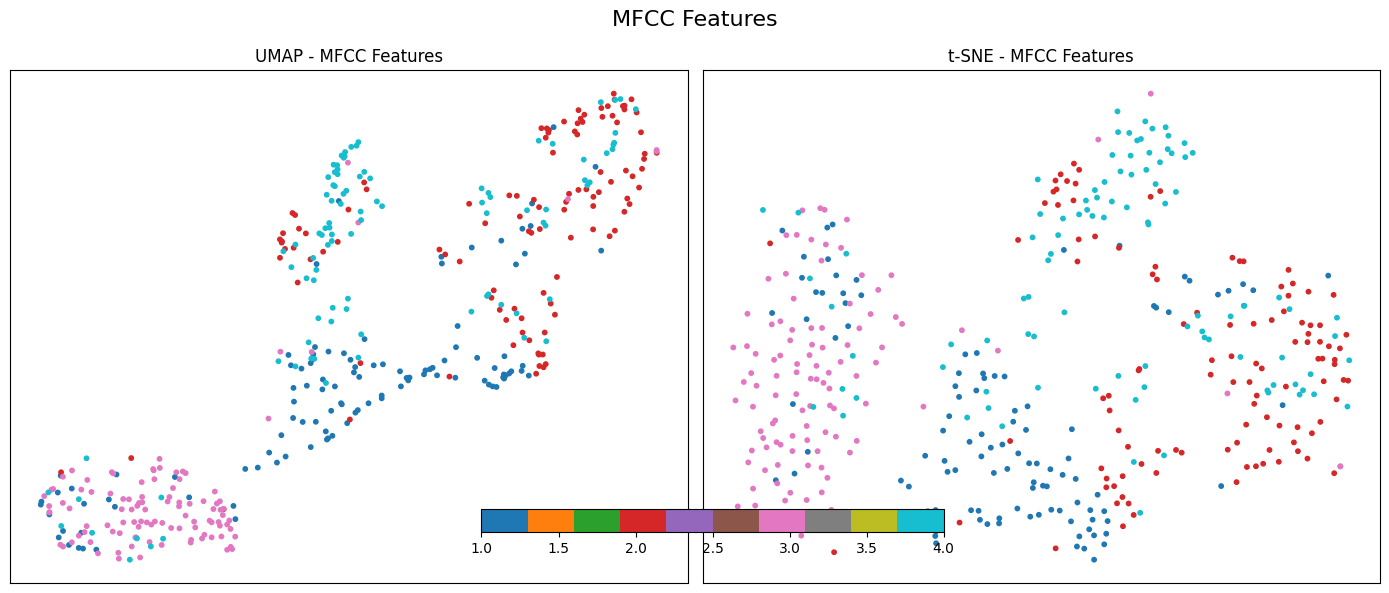

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\lycaz\AppData\Local\Temp\ipykernel_25536\33761298.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


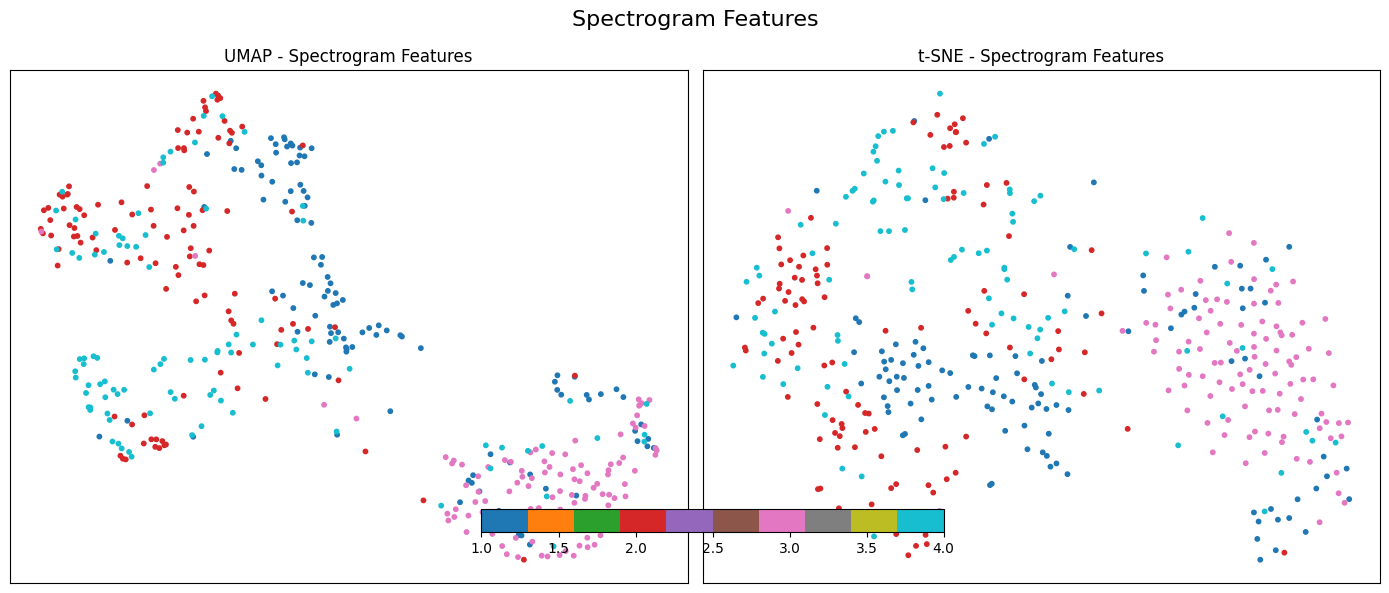

In [31]:
plot_feature_clusters(dataset_list, dataset_labels)

In [32]:
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# New function to evaluate clustering quality for MFCC and Spectrogram

def evaluate_feature_clusters(dataset_list, dataset_labels, random_state=42):
    mfcc_features = []
    spec_features = []
    labels = []

    for data, label in zip(dataset_list, dataset_labels):
        for sample in data:
            mfcc = sample['audio_press_mfcc']
            spec = sample['audio_press_spec']

            mfcc_features.append(mfcc.flatten())
            spec_features.append(spec.flatten())
            labels.append(int(label))

    mfcc_features = np.array(mfcc_features)
    spec_features = np.array(spec_features)
    labels = np.array(labels)

    results = []

    # Evaluate MFCC
    results.append(_evaluate_single_feature(mfcc_features, labels, "MFCC", random_state))

    # Evaluate Spectrogram
    results.append(_evaluate_single_feature(spec_features, labels, "Spectrogram", random_state))

    df = pd.DataFrame(results)
    print(df)
    return df


def _evaluate_single_feature(features, labels, feature_name, random_state=42):
    # UMAP embedding
    reducer_umap = umap.UMAP(random_state=random_state)
    embedding_umap = reducer_umap.fit_transform(features)

    silhouette_umap = silhouette_score(embedding_umap, labels)
    davies_umap = davies_bouldin_score(embedding_umap, labels)
    calinski_umap = calinski_harabasz_score(embedding_umap, labels)

    # t-SNE embedding
    reducer_tsne = TSNE(n_components=2, random_state=random_state)
    embedding_tsne = reducer_tsne.fit_transform(features)

    silhouette_tsne = silhouette_score(embedding_tsne, labels)
    davies_tsne = davies_bouldin_score(embedding_tsne, labels)
    calinski_tsne = calinski_harabasz_score(embedding_tsne, labels)

    return {
        "Feature": feature_name,
        "Silhouette (UMAP)": silhouette_umap,
        "Davies-Bouldin (UMAP)": davies_umap,
        "Calinski-Harabasz (UMAP)": calinski_umap,
        "Silhouette (t-SNE)": silhouette_tsne,
        "Davies-Bouldin (t-SNE)": davies_tsne,
        "Calinski-Harabasz (t-SNE)": calinski_tsne,
    }


In [33]:
metrics_df = evaluate_feature_clusters(dataset_list, dataset_labels)

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


       Feature  Silhouette (UMAP)  Davies-Bouldin (UMAP)  \
0         MFCC           0.143297               1.884585   
1  Spectrogram           0.095636               2.257560   

   Calinski-Harabasz (UMAP)  Silhouette (t-SNE)  Davies-Bouldin (t-SNE)  \
0                151.582428            0.132019                1.924956   
1                145.917084            0.067611                2.546394   

   Calinski-Harabasz (t-SNE)  
0                 159.700073  
1                 128.063919  


1. Silhouette Score
Measures how similar a sample is to its own cluster compared to other clusters.

- Range: -1 to 1

 - Closer to 1 → better, well-separated clusters.

 - Around 0 → clusters overlap.

 - Negative → samples assigned to the wrong cluster.

Higher Silhouette Score means better clustering.

2. Davies-Bouldin Score
Measures the average similarity between each cluster and its most similar cluster.

Lower Davies-Bouldin Score indicates better clustering (smaller is better).

It captures how compact and well-separated the clusters are.

3. Calinski-Harabasz Score (also called Variance Ratio Criterion)
Measures the ratio of between-cluster dispersion to within-cluster dispersion.

Higher Calinski-Harabasz Score indicates better clustering.

A high score means clusters are dense and well-separated.

# Tables for the press_spe and press_mfcc

## Clusert 
| Feature      | Silhouette (UMAP) | Davies-Bouldin (UMAP) | Calinski-Harabasz (UMAP) | Silhouette (t-SNE) | Davies-Bouldin (t-SNE) | Calinski-Harabasz (t-SNE) |
|--------------|-------------------|-----------------------|--------------------------|--------------------|-------------------------|---------------------------|
| MFCC         | 0.143297           | 1.884585              | 151.582428               | 0.132019           | 1.924956                | 159.700073                |
| Spectrogram  | 0.095636           | 2.257560              | 145.917084               | 0.067611           | 2.546394                | 128.063919                |


### Binary Classifier Metrics Comparison

#### Average Metrics
| Feature      | Acc      | FAR      | FRR      | EER      |
|:------------:|:--------:|:--------:|:--------:|:--------:|
| Spectrogram  | 0.900000 | 0.035342 | 0.294859 | 0.188761 |
| MFCC         | 0.926471 | 0.043222 | 0.164177 | 0.089987 |

#### Standard Deviation of Metrics
| Feature      | Acc      | FAR      | FRR      | EER      |
|:------------:|:--------:|:--------:|:--------:|:--------:|
| Spectrogram  | 0.011765 | 0.044946 | 0.181416 | 0.079829 |
| MFCC         | 0.035130 | 0.027131 | 0.079919 | 0.058214 |

# Model Haptic spec VS MFCC

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import pandas as pd

# Dataset class
class HapticFeatureDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label, feature_key):
        self.samples = []
        self.labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                feature = sample[feature_key]
                self.samples.append(feature)
                self.labels.append(1 if label == target_label else 0)

        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        feature = self.samples[idx]
        label = self.labels[idx]
        feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        return feature, label

# CNN model class that adapts to input shape
class HapticCNNBinary(nn.Module):
    def __init__(self, input_shape):
        super(HapticCNNBinary, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2))
        )

        # Compute flatten size dynamically
        dummy_input = torch.zeros(1, 1, *input_shape)
        dummy_out = self.conv_block(dummy_input)
        flatten_size = dummy_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x.squeeze(1)

# Training function

def train_haptic_features(dataset_list, dataset_labels, feature_keys, epochs=20, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    feature_results = {}

    for feature_key in feature_keys:
        print(f"\nTraining models for feature: {feature_key}")
        label_metrics = {}

        for target_label in dataset_labels:
            print(f"\nLabel {target_label} - Training")

            dataset = HapticFeatureDataset(dataset_list, dataset_labels, target_label, feature_key)

            from sklearn.model_selection import train_test_split
            train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)

            train_dataset = torch.utils.data.Subset(dataset, train_idx)
            val_dataset = torch.utils.data.Subset(dataset, val_idx)

            train_labels = np.array([dataset.labels[i] for i in train_idx])
            val_labels = np.array([dataset.labels[i] for i in val_idx])

            print(f"Train Samples - Target: {np.sum(train_labels == 1)}, Non-target: {np.sum(train_labels == 0)}")
            print(f"Validation Samples - Target: {np.sum(val_labels == 1)}, Non-target: {np.sum(val_labels == 0)}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            input_shape = dataset.samples[0].shape
            model = HapticCNNBinary(input_shape=input_shape).to(device)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            history = {'train_loss': [], 'val_loss': [], 'acc': [], 'far': [], 'frr': [], 'eer': []}

            for epoch in range(epochs):
                model.train()
                train_losses = []

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                model.eval()
                val_losses = []
                preds = []
                truths = []

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_losses.append(loss.item())
                        preds.extend(outputs.cpu().numpy())
                        truths.extend(labels.cpu().numpy())

                preds_bin = (np.array(preds) >= 0).astype(int)
                truths = np.array(truths).astype(int)

                acc = accuracy_score(truths, preds_bin)

                fpr, tpr, thresholds = roc_curve(truths, preds)
                fnr = 1 - tpr
                eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

                far = np.mean(preds_bin[truths == 0])
                frr = 1 - np.mean(preds_bin[truths == 1])

                history['train_loss'].append(np.mean(train_losses))
                history['val_loss'].append(np.mean(val_losses))
                history['acc'].append(acc)
                history['far'].append(far)
                history['frr'].append(frr)
                history['eer'].append(eer)

            # Final Metrics
            best_idx = np.argmax(history['acc'])
            print(f"Model for Label {target_label} - Best Acc: {history['acc'][best_idx]:.4f}, FAR: {history['far'][best_idx]:.4f}, FRR: {history['frr'][best_idx]:.4f}, EER: {history['eer'][best_idx]:.4f}")

            cm = confusion_matrix(truths, preds_bin)
            print("Confusion Matrix:")
            print(cm)

            label_metrics[target_label] = history

        feature_results[feature_key] = label_metrics

    # Compare features
    summary_table = []

    for feature_key, label_metrics in feature_results.items():
        accs, fars, frrs, eers = [], [], [], []

        for label, hist in label_metrics.items():
            best_idx = np.argmax(hist['acc'])
            accs.append(hist['acc'][best_idx])
            fars.append(hist['far'][best_idx])
            frrs.append(hist['frr'][best_idx])
            eers.append(hist['eer'][best_idx])

        summary_table.append({
            'Feature': feature_key,
            'Acc-Mean': np.mean(accs), 'Acc-Std': np.std(accs),
            'FAR-Mean': np.mean(fars), 'FAR-Std': np.std(fars),
            'FRR-Mean': np.mean(frrs), 'FRR-Std': np.std(frrs),
            'EER-Mean': np.mean(eers), 'EER-Std': np.std(eers)
        })

    df_summary = pd.DataFrame(summary_table)
    print("\nFeature Comparison Table:")
    print(df_summary)

    return feature_results, df_summary


In [10]:
feature_results, summary_df = train_haptic_features(dataset_list, dataset_labels, feature_keys=['audio_haptic_spec', 'audio_haptic_mfcc'],epochs=200)


Training models for feature: audio_haptic_spec

Label 1 - Training
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Model for Label 1 - Best Acc: 0.9765, FAR: 0.0159, FRR: 0.0455, EER: 0.0159
Confusion Matrix:
[[62  1]
 [ 3 19]]

Label 2 - Training
Train Samples - Target: 87, Non-target: 251
Validation Samples - Target: 22, Non-target: 63
Model for Label 2 - Best Acc: 1.0000, FAR: 0.0000, FRR: 0.0000, EER: 0.0000
Confusion Matrix:
[[62  1]
 [ 1 21]]

Label 3 - Training
Train Samples - Target: 85, Non-target: 253
Validation Samples - Target: 21, Non-target: 64
Model for Label 3 - Best Acc: 0.9176, FAR: 0.0312, FRR: 0.2381, EER: 0.0781
Confusion Matrix:
[[61  3]
 [ 5 16]]

Label 4 - Training
Train Samples - Target: 78, Non-target: 260
Validation Samples - Target: 20, Non-target: 65
Model for Label 4 - Best Acc: 0.9765, FAR: 0.0154, FRR: 0.0500, EER: 0.0769
Confusion Matrix:
[[64  1]
 [11  9]]

Training models for feature: audio_haptic_mfcc

Lab

In [22]:
def plot_feature_training(feature_results):
    for feature_name, label_histories in feature_results.items():
        print(f"\nPlotting for feature: {feature_name}")

        fig, axs = plt.subplots(1, 2, figsize=(16, 6))

        # Plot Loss (Train and Validation)
        for label, history in label_histories.items():
            epochs = np.arange(1, len(history['train_loss']) + 1)
            axs[0].plot(epochs, history['train_loss'], label=f'Train Loss - Label {label}')
            axs[0].plot(epochs, history['val_loss'], linestyle='--', label=f'Val Loss - Label {label}')

        axs[0].set_title(f"Loss Curves for Feature: {feature_name}")
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[0].grid(True)

        # Plot Accuracy
        for label, history in label_histories.items():
            epochs = np.arange(1, len(history['acc']) + 1)
            axs[1].plot(epochs, history['acc'], label=f'Acc - Label {label}')

        axs[1].set_title(f"Accuracy Curves for Feature: {feature_name}")
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        axs[1].grid(True)

        plt.suptitle(f"Training Curves for {feature_name}", fontsize=18)
        plt.tight_layout()
        plt.show()



In [ ]:
# Example usage
plot_feature_training(feature_results)

## Cluster of the Haptic_Spec and Haptic_mfcc

In [13]:
import numpy as np
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import pandas as pd

# New function to cluster and evaluate haptic features

def cluster_haptic_features(dataset_list, dataset_labels, random_state=42):
    feature_keys = ['audio_haptic_spec', 'audio_haptic_mfcc']
    all_results = []

    for feature_key in feature_keys:
        print(f"\nClustering feature: {feature_key}")
        features = []
        labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                feat = sample[feature_key]
                features.append(feat.flatten())
                labels.append(int(label))

        features = np.array(features)
        labels = np.array(labels)

        # UMAP
        reducer_umap = umap.UMAP(random_state=random_state)
        embedding_umap = reducer_umap.fit_transform(features)

        silhouette_umap = silhouette_score(embedding_umap, labels)
        davies_umap = davies_bouldin_score(embedding_umap, labels)
        calinski_umap = calinski_harabasz_score(embedding_umap, labels)

        # t-SNE
        reducer_tsne = TSNE(n_components=2, random_state=random_state)
        embedding_tsne = reducer_tsne.fit_transform(features)

        silhouette_tsne = silhouette_score(embedding_tsne, labels)
        davies_tsne = davies_bouldin_score(embedding_tsne, labels)
        calinski_tsne = calinski_harabasz_score(embedding_tsne, labels)

        all_results.append({
            "Feature": feature_key,
            "Silhouette (UMAP)": silhouette_umap,
            "Davies-Bouldin (UMAP)": davies_umap,
            "Calinski-Harabasz (UMAP)": calinski_umap,
            "Silhouette (t-SNE)": silhouette_tsne,
            "Davies-Bouldin (t-SNE)": davies_tsne,
            "Calinski-Harabasz (t-SNE)": calinski_tsne,
        })

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        scatter1 = axs[0].scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=labels, cmap='tab10', s=10)
        axs[0].set_title(f"UMAP - {feature_key}")

        scatter2 = axs[1].scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=labels, cmap='tab10', s=10)
        axs[1].set_title(f"t-SNE - {feature_key}")

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        fig.colorbar(scatter1, ax=axs, orientation='horizontal', fraction=0.05)
        plt.suptitle(f"Clustering Visualization for {feature_key}", fontsize=16)
        plt.tight_layout()
        plt.show()

    df_results = pd.DataFrame(all_results)
    print("\nClustering Metrics Table:")
    print(df_results)
    return df_results

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Clustering feature: audio_haptic_spec


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\lycaz\AppData\Local\Temp\ipykernel_25940\2776857178.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


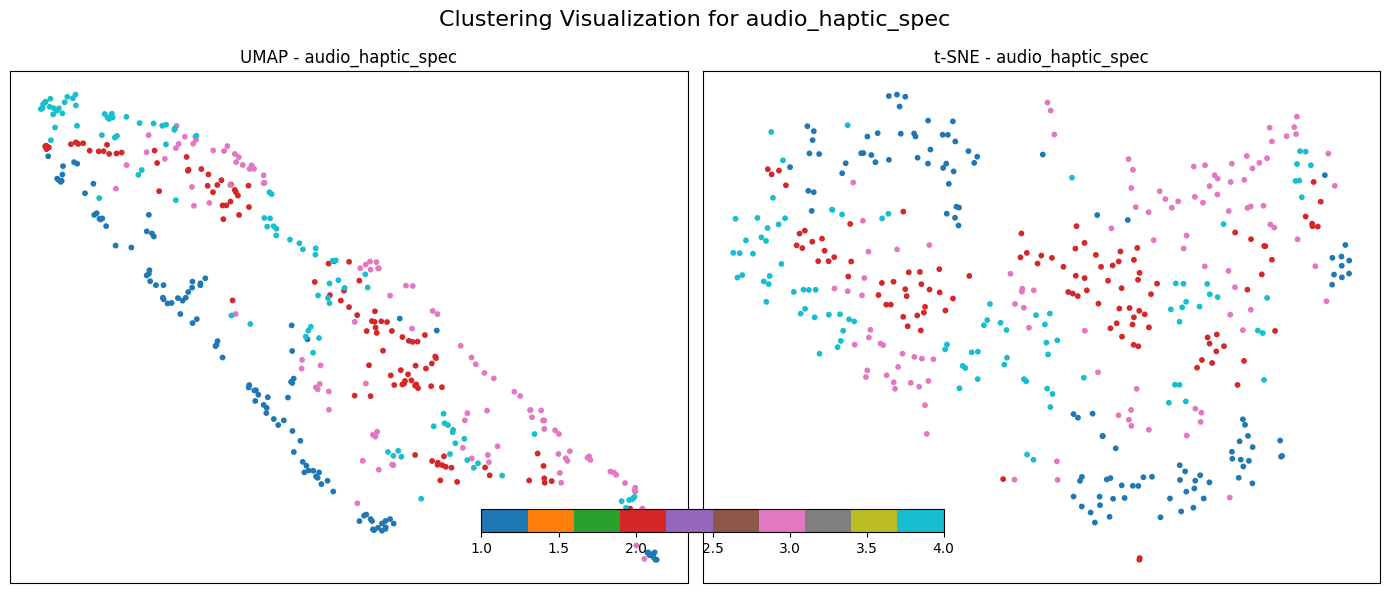

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Clustering feature: audio_haptic_mfcc


C:\Users\lycaz\AppData\Local\Temp\ipykernel_25940\2776857178.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


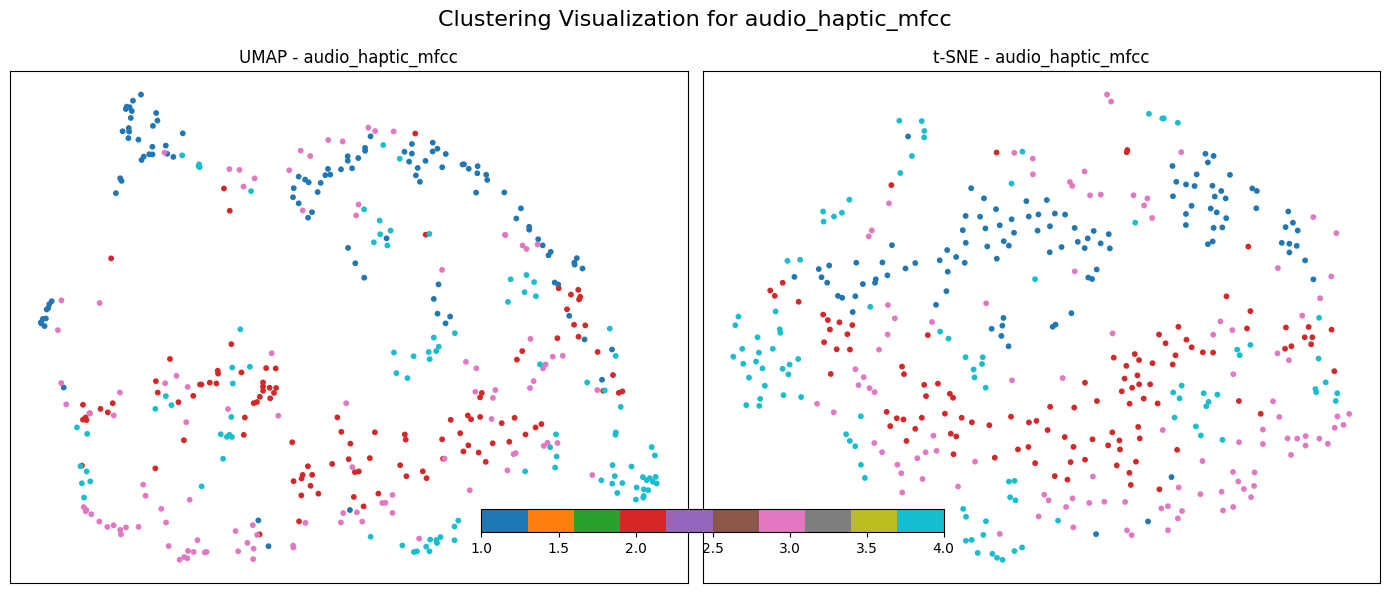


Clustering Metrics Table:
             Feature  Silhouette (UMAP)  Davies-Bouldin (UMAP)  \
0  audio_haptic_spec          -0.017422               4.551609   
1  audio_haptic_mfcc          -0.011865               4.992212   

   Calinski-Harabasz (UMAP)  Silhouette (t-SNE)  Davies-Bouldin (t-SNE)  \
0                 15.525933           -0.046340                9.090995   
1                 22.815908           -0.004499                4.536826   

   Calinski-Harabasz (t-SNE)  
0                   9.520002  
1                  20.260210  


In [14]:
clustering_df = cluster_haptic_features(dataset_list, dataset_labels)

# Table for haptic_spec and haptic_mfcc
## Feature Comparison Table

| Feature            | Acc-Mean | Acc-Std | FAR-Mean | FAR-Std | FRR-Mean | FRR-Std | EER-Mean | EER-Std |
|--------------------|----------|---------|----------|---------|----------|---------|----------|---------|
| audio_haptic_spec  | 0.967647  | 0.030424| 0.015627 | 0.011050| 0.083387 | 0.091435| 0.042730 | 0.035246|
| audio_haptic_mfcc  | 0.988235  | 0.011765| 0.003906 | 0.006766| 0.034632 | 0.037863| 0.015811 | 0.019441|


# Model for inertial press

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import pandas as pd

# Dataset class
class InertialFeatureDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label, feature_key):
        self.samples = []
        self.labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                feature = sample[feature_key]
                self.samples.append(feature)
                self.labels.append(1 if label == target_label else 0)

        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        feature = self.samples[idx]
        label = self.labels[idx]
        feature = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)
        return feature, label

# CNN model class that adapts to input shape
class InertialCNNBinary(nn.Module):
    def __init__(self, input_shape):
        super(InertialCNNBinary, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2))
        )

        dummy_input = torch.zeros(1, 1, *input_shape)
        dummy_out = self.conv_block(dummy_input)
        flatten_size = dummy_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc(x)
        return x.squeeze(1)
    

class InertialLSTMBinary(nn.Module):
    def __init__(self, input_shape, hidden_dim=64, num_layers=2, dropout_rate=0.3):
        super(InertialLSTMBinary, self).__init__()
        self.input_size = input_shape[1]  # (seq_len, feature_dim)
        self.seq_len = input_shape[0]

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.layer_norm = nn.LayerNorm(hidden_dim * 2)  # Normalize LSTM outputs

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.SiLU(),  # smoother activation than ReLU
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (B, 1, seq_len, feature_dim)
        x = x.squeeze(1)  # (B, seq_len, feature_dim)
        out, _ = self.lstm(x)  # (B, seq_len, hidden_dim*2)
        out = self.layer_norm(out)
        out = out.mean(dim=1)  # mean pooling over all timesteps
        out = self.fc(out)
        return out.squeeze(1)


# Training function
def train_inertial_models(dataset_list, dataset_labels, feature_keys, model_type='cnn', epochs=50, patience=10, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    feature_results = {}

    for feature_key in feature_keys:
        print(f"\nTraining models for feature: {feature_key} using {model_type.upper()}")
        label_metrics = {}
        label_best_metrics = {}

        for target_label in dataset_labels:
            print(f"\nLabel {target_label} - Training")

            dataset = InertialFeatureDataset(dataset_list, dataset_labels, target_label, feature_key)
            from sklearn.model_selection import train_test_split
            train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)

            train_dataset = torch.utils.data.Subset(dataset, train_idx)
            val_dataset = torch.utils.data.Subset(dataset, val_idx)

            train_labels = np.array([dataset.labels[i] for i in train_idx])
            val_labels = np.array([dataset.labels[i] for i in val_idx])

            print(f"Train Samples - Target: {np.sum(train_labels == 1)}, Non-target: {np.sum(train_labels == 0)}")
            print(f"Validation Samples - Target: {np.sum(val_labels == 1)}, Non-target: {np.sum(val_labels == 0)}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            input_shape = dataset.samples[0].shape

            # choose model
            if model_type.lower() == 'cnn':
                model = InertialCNNBinary(input_shape=input_shape).to(device)
            elif model_type.lower() == 'lstm':
                model = InertialLSTMBinary(input_shape=input_shape).to(device)
            else:
                raise ValueError("Unsupported model type: choose 'cnn' or 'lstm'")

            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            history = {'train_loss': [], 'val_loss': [], 'acc': [], 'far': [], 'frr': [], 'eer': []}

            best_acc = 0
            early_stop_counter = 0
            best_model_state = None

            for epoch in range(epochs):
                model.train()
                train_losses = []

                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                model.eval()
                val_losses = []
                preds = []
                truths = []

                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        val_losses.append(loss.item())
                        preds.extend(outputs.cpu().numpy())
                        truths.extend(labels.cpu().numpy())

                preds_bin = (np.array(preds) >= 0).astype(int)
                truths = np.array(truths).astype(int)

                acc = accuracy_score(truths, preds_bin)
                fpr, tpr, thresholds = roc_curve(truths, preds)
                fnr = 1 - tpr
                eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
                far = np.mean(preds_bin[truths == 0])
                frr = 1 - np.mean(preds_bin[truths == 1])

                history['train_loss'].append(np.mean(train_losses))
                history['val_loss'].append(np.mean(val_losses))
                history['acc'].append(acc)
                history['far'].append(far)
                history['frr'].append(frr)
                history['eer'].append(eer)

                print(f"Epoch {epoch+1}: Train Loss: {np.mean(train_losses):.4f}, Val Loss: {np.mean(val_losses):.4f}, Acc: {acc:.4f}, FAR: {far:.4f}, FRR: {frr:.4f}, EER: {eer:.4f}")

                if acc > best_acc:
                    best_acc = acc
                    best_model_state = model.state_dict()
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                if early_stop_counter >= patience:
                    print("Early stopping!")
                    break

            # Load best model
            model.load_state_dict(best_model_state)

            # Evaluate confusion matrix
            model.eval()
            val_preds = []
            val_truths = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    val_preds.extend(outputs.cpu().numpy())
                    val_truths.extend(labels.cpu().numpy())

            val_preds_bin = (np.array(val_preds) >= 0).astype(int)
            val_truths = np.array(val_truths).astype(int)

            cm = confusion_matrix(val_truths, val_preds_bin)
            print("Confusion Matrix for Best Model:")
            print(cm)

            tn, fp, fn, tp = cm.ravel()
            acc = (tp + tn) / (tn + fp + fn + tp)
            far = fp / (fp + tn) if (fp + tn) > 0 else 0
            frr = fn / (fn + tp) if (fn + tp) > 0 else 0
            fpr, tpr, thresholds = roc_curve(val_truths, val_preds)
            fnr = 1 - tpr
            eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

            best_metrics = {
                'acc': acc,
                'far': far,
                'frr': frr,
                'eer': eer
            }

            label_metrics[target_label] = history
            label_best_metrics[target_label] = best_metrics

        feature_results[feature_key] = {
            'metrics': label_metrics,
            'best_metrics': label_best_metrics.copy()
        }

        # Print feature summary
        print(f"\nSummary for feature: {feature_key} - Model: {model_type.upper()}")
        print("Label\tAcc\tFAR\tFRR\tEER")
        for label, metrics in label_best_metrics.items():
            print(f"{label}\t{metrics['acc']:.6f}\t{metrics['far']:.6f}\t{metrics['frr']:.6f}\t{metrics['eer']:.6f}")

    # Compare features
    summary_table = []

    for feature_key, results in feature_results.items():
        feature_best_metrics = results['best_metrics']
        accs, fars, frrs, eers = [], [], [], []

        for label, best_metrics in feature_best_metrics.items():
            accs.append(best_metrics['acc'])
            fars.append(best_metrics['far'])
            frrs.append(best_metrics['frr'])
            eers.append(best_metrics['eer'])

        summary_table.append({
            'Feature': feature_key,
            'Acc-Mean': np.mean(accs), 'Acc-Std': np.std(accs),
            'FAR-Mean': np.mean(fars), 'FAR-Std': np.std(fars),
            'FRR-Mean': np.mean(frrs), 'FRR-Std': np.std(frrs),
            'EER-Mean': np.mean(eers), 'EER-Std': np.std(eers)
        })

    df_summary = pd.DataFrame(summary_table)
    print("\nFeature Comparison Table:")
    print(df_summary)

    return feature_results, df_summary


In [43]:
feature_results_inert_press, summary_df_inert_press = train_inertial_models(dataset_list, dataset_labels, feature_keys=['press_deriv_rms', 'press_zscore_rms'], model_type='cnn')


Training models for feature: press_deriv_rms using CNN

Label 1 - Training
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss: 0.5702, Val Loss: 0.5310, Acc: 0.7412, FAR: 0.0000, FRR: 1.0000, EER: 0.2540
Epoch 2: Train Loss: 0.4582, Val Loss: 0.4675, Acc: 0.7412, FAR: 0.0000, FRR: 1.0000, EER: 0.2063
Epoch 3: Train Loss: 0.3911, Val Loss: 0.4598, Acc: 0.7412, FAR: 0.0000, FRR: 1.0000, EER: 0.1587
Epoch 4: Train Loss: 0.3332, Val Loss: 0.4460, Acc: 0.8118, FAR: 0.0476, FRR: 0.5909, EER: 0.1746
Epoch 5: Train Loss: 0.3134, Val Loss: 0.4799, Acc: 0.8118, FAR: 0.0000, FRR: 0.7273, EER: 0.0952
Epoch 6: Train Loss: 0.2254, Val Loss: 0.3658, Acc: 0.8353, FAR: 0.1746, FRR: 0.1364, EER: 0.1111
Epoch 7: Train Loss: 0.1683, Val Loss: 0.5057, Acc: 0.7176, FAR: 0.3492, FRR: 0.0909, EER: 0.2063
Epoch 8: Train Loss: 0.1218, Val Loss: 0.6902, Acc: 0.6941, FAR: 0.4127, FRR: 0.0000, EER: 0.2222
Epoch 9: Train Loss: 0.1184, Val Loss: 1.3310, A

In [51]:
feature_results_inert_press, summary_df_inert_press = train_inertial_models(dataset_list, dataset_labels, epochs=100, feature_keys=['press_deriv_rms', 'press_zscore_rms'], model_type='lstm')


Training models for feature: press_deriv_rms using LSTM

Label 1 - Training
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss: 0.6271, Val Loss: 0.6754, Acc: 0.5529, FAR: 0.5873, FRR: 0.0455, EER: 0.2381
Epoch 2: Train Loss: 0.4974, Val Loss: 0.5422, Acc: 0.9176, FAR: 0.0000, FRR: 0.3182, EER: 0.1905
Epoch 3: Train Loss: 0.4175, Val Loss: 0.3867, Acc: 0.8353, FAR: 0.0000, FRR: 0.6364, EER: 0.1270
Epoch 4: Train Loss: 0.3181, Val Loss: 0.2753, Acc: 0.8824, FAR: 0.0000, FRR: 0.4545, EER: 0.1429
Epoch 5: Train Loss: 0.2333, Val Loss: 0.2425, Acc: 0.9412, FAR: 0.0000, FRR: 0.2273, EER: 0.1905
Epoch 6: Train Loss: 0.1655, Val Loss: 0.2258, Acc: 0.9294, FAR: 0.0635, FRR: 0.0909, EER: 0.0794
Epoch 7: Train Loss: 0.1449, Val Loss: 0.2684, Acc: 0.9176, FAR: 0.0794, FRR: 0.0909, EER: 0.0159
Epoch 8: Train Loss: 0.1090, Val Loss: 0.3817, Acc: 0.8353, FAR: 0.0159, FRR: 0.5909, EER: 0.0952
Epoch 9: Train Loss: 0.1211, Val Loss: 0.2249, 

# Model for inertial haptic 

In [47]:
feature_results_inertial_haptic, summary_df__inertial_haptic = train_inertial_models(
    dataset_list, dataset_labels, 
    feature_keys=['haptic_deriv_rms', 'haptic_zscore_rms'],model_type='cnn'
)


Training models for feature: haptic_deriv_rms using CNN

Label 1 - Training
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss: 0.5745, Val Loss: 0.5765, Acc: 0.7412, FAR: 0.0000, FRR: 1.0000, EER: 0.4444
Epoch 2: Train Loss: 0.4872, Val Loss: 0.4788, Acc: 0.7765, FAR: 0.0000, FRR: 0.8636, EER: 0.1111
Epoch 3: Train Loss: 0.3221, Val Loss: 0.4430, Acc: 0.7529, FAR: 0.0000, FRR: 0.9545, EER: 0.0476
Epoch 4: Train Loss: 0.1623, Val Loss: 0.3504, Acc: 0.8353, FAR: 0.0000, FRR: 0.6364, EER: 0.0794
Epoch 5: Train Loss: 0.0867, Val Loss: 0.2012, Acc: 0.9176, FAR: 0.0000, FRR: 0.3182, EER: 0.0000
Epoch 6: Train Loss: 0.0658, Val Loss: 0.3999, Acc: 0.8588, FAR: 0.0000, FRR: 0.5455, EER: 0.0317
Epoch 7: Train Loss: 0.0499, Val Loss: 0.1350, Acc: 0.9529, FAR: 0.0000, FRR: 0.1818, EER: 0.0159
Epoch 8: Train Loss: 0.0552, Val Loss: 0.0663, Acc: 0.9765, FAR: 0.0159, FRR: 0.0455, EER: 0.0794
Epoch 9: Train Loss: 0.0480, Val Loss: 0.8864, 

In [52]:
feature_results_inertial_haptic, summary_df__inertial_haptic = train_inertial_models(
    dataset_list, dataset_labels, 
    feature_keys=['haptic_deriv_rms', 'haptic_zscore_rms'],model_type='lstm'
)


Training models for feature: haptic_deriv_rms using LSTM

Label 1 - Training
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss: 0.3618, Val Loss: 0.4746, Acc: 0.8941, FAR: 0.0635, FRR: 0.2273, EER: 0.1746
Epoch 2: Train Loss: 0.2861, Val Loss: 0.3476, Acc: 0.8941, FAR: 0.0476, FRR: 0.2727, EER: 0.1111
Epoch 3: Train Loss: 0.2088, Val Loss: 0.2664, Acc: 0.8941, FAR: 0.0159, FRR: 0.3636, EER: 0.0794
Epoch 4: Train Loss: 0.1098, Val Loss: 0.2867, Acc: 0.9059, FAR: 0.0476, FRR: 0.2273, EER: 0.1270
Epoch 5: Train Loss: 0.1038, Val Loss: 0.2976, Acc: 0.8941, FAR: 0.0476, FRR: 0.2727, EER: 0.1270
Epoch 6: Train Loss: 0.0629, Val Loss: 0.3745, Acc: 0.8941, FAR: 0.0476, FRR: 0.2727, EER: 0.1270
Epoch 7: Train Loss: 0.0585, Val Loss: 0.4375, Acc: 0.8941, FAR: 0.0476, FRR: 0.2727, EER: 0.0794
Epoch 8: Train Loss: 0.0471, Val Loss: 0.3870, Acc: 0.9059, FAR: 0.0794, FRR: 0.1364, EER: 0.0952
Epoch 9: Train Loss: 0.0302, Val Loss: 0.3186,

# Model for fuse 1 inertial_press audio_press

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split


# Dataset class for fusion
class FuseFeatureDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label, feature_keys):
        self.samples1 = []
        self.samples2 = []
        self.labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                self.samples1.append(sample[feature_keys[0]])
                self.samples2.append(sample[feature_keys[1]])
                self.labels.append(1 if label == target_label else 0)

        self.samples1 = np.array(self.samples1)
        self.samples2 = np.array(self.samples2)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples1)

    def __getitem__(self, idx):
        feature1 = torch.tensor(self.samples1[idx], dtype=torch.float32).unsqueeze(0)
        feature2 = torch.tensor(self.samples2[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature1, feature2, label

# CNN Fusion Model
class FuseCNN(nn.Module):
    def __init__(self, input_shape1, input_shape2):
        super(FuseCNN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 2)),
            nn.Flatten()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 2)),
            nn.Flatten()
        )
        dummy1 = self.branch1(torch.zeros(1, 1, *input_shape1))
        dummy2 = self.branch2(torch.zeros(1, 1, *input_shape2))
        fusion_dim = dummy1.shape[1] + dummy2.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        fused = torch.cat([x1, x2], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)



# Dataset class for fusion
class FuseFeatureDataset(Dataset):
    def __init__(self, dataset_list, dataset_labels, target_label, feature_keys):
        self.samples1 = []
        self.samples2 = []
        self.labels = []

        for data, label in zip(dataset_list, dataset_labels):
            for sample in data:
                self.samples1.append(sample[feature_keys[0]])
                self.samples2.append(sample[feature_keys[1]])
                self.labels.append(1 if label == target_label else 0)

        self.samples1 = np.array(self.samples1)
        self.samples2 = np.array(self.samples2)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.samples1)

    def __getitem__(self, idx):
        feature1 = torch.tensor(self.samples1[idx], dtype=torch.float32).unsqueeze(0)
        feature2 = torch.tensor(self.samples2[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return feature1, feature2, label

# CNN Fusion Model
class FuseCNN(nn.Module):
    def __init__(self, input_shape1, input_shape2):
        super(FuseCNN, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 2)),
            nn.Flatten()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 2)),
            nn.Flatten()
        )
        dummy1 = self.branch1(torch.zeros(1, 1, *input_shape1))
        dummy2 = self.branch2(torch.zeros(1, 1, *input_shape2))
        fusion_dim = dummy1.shape[1] + dummy2.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        fused = torch.cat([x1, x2], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)

# LSTM Fusion Model
class FuseLSTM(nn.Module):
    def __init__(self, input_shape1, input_shape2, hidden_dim=64):
        super(FuseLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape1[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=input_shape2[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim*4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = x1.squeeze(1)
        x2 = x2.squeeze(1)
        _, (h1, _) = self.lstm1(x1)
        _, (h2, _) = self.lstm2(x2)
        h1 = torch.cat([h1[-2], h1[-1]], dim=1)
        h2 = torch.cat([h2[-2], h2[-1]], dim=1)
        fused = torch.cat([h1, h2], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)

# Transformer Fusion Model
class FuseTransformer(nn.Module):
    def __init__(self, input_shape1, input_shape2, emb_dim=64, num_heads=4, num_layers=2):
        super(FuseTransformer, self).__init__()
        self.flatten1 = nn.Flatten(start_dim=2)
        self.flatten2 = nn.Flatten(start_dim=2)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(emb_dim*2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
        self.project1 = nn.Linear(input_shape1[1], emb_dim)
        self.project2 = nn.Linear(input_shape2[1], emb_dim)

    def forward(self, x1, x2):
        x1 = self.project1(x1.squeeze(1))
        x2 = self.project2(x2.squeeze(1))
        fusion = torch.stack([x1.mean(dim=1), x2.mean(dim=1)], dim=1)
        out = self.transformer(fusion)
        out = out.flatten(start_dim=1)
        out = self.fc(out)
        return out.squeeze(1)

In [73]:
class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        weights = torch.softmax(self.attention(x).squeeze(-1), dim=1)
        context = torch.bmm(weights.unsqueeze(1), x).squeeze(1)
        return context

class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttentionBlock, self).__init__()
        self.query_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.key_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.value_fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, query_seq, key_value_seq):
        Q = self.query_fc(query_seq)
        K = self.key_fc(key_value_seq)
        V = self.value_fc(key_value_seq)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        attended = torch.bmm(attn_weights, V)
        return attended.mean(dim=1)

class FuseLSTMImproved(nn.Module):
    def __init__(self, input_shape1, input_shape2, hidden_dim=128, num_layers=2):
        super(FuseLSTMImproved, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape1[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)
        self.lstm2 = nn.LSTM(input_size=input_shape2[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)

        self.self_attn1 = AttentionBlock(hidden_dim)
        self.self_attn2 = AttentionBlock(hidden_dim)
        self.cross_attn = CrossAttentionBlock(hidden_dim)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 5, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = x1.squeeze(1)  # (B, seq_len, feature_dim)
        x2 = x2.squeeze(1)

        out1, _ = self.lstm1(x1)  # (B, seq_len, hidden_dim*2)
        out2, _ = self.lstm2(x2)

        context1 = self.self_attn1(out1)
        context2 = self.self_attn2(out2)
        cross_context = self.cross_attn(out1, out2)

        fused = torch.cat([context1, context2, cross_context], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)


In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        weights = torch.softmax(self.attention(x).squeeze(-1), dim=1)
        context = torch.bmm(weights.unsqueeze(1), x).squeeze(1)
        return context

class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttentionBlock, self).__init__()
        self.query_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.key_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.value_fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, query_seq, key_value_seq):
        Q = self.query_fc(query_seq)
        K = self.key_fc(key_value_seq)
        V = self.value_fc(key_value_seq)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        attended = torch.bmm(attn_weights, V)
        return attended.mean(dim=1)

class FuseLSTMImprovedV2(nn.Module):
    def __init__(self, input_shape1, input_shape2, hidden_dim=128, num_layers=2):
        super(FuseLSTMImprovedV2, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM for each feature
        self.lstm1 = nn.LSTM(input_size=input_shape1[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)
        self.lstm2 = nn.LSTM(input_size=input_shape2[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)

        # Self-Attention for each feature
        self.self_attn1 = AttentionBlock(hidden_dim)
        self.self_attn2 = AttentionBlock(hidden_dim)

        # Cross Attention between features
        self.cross_attn = CrossAttentionBlock(hidden_dim)

        # Fusion gate (dynamic weighting)
        self.gate_fc = nn.Sequential(
            nn.Linear(hidden_dim * 5, 2),
            nn.Softmax(dim=1)
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = x1.squeeze(1)  # (B, seq_len, feature_dim)
        x2 = x2.squeeze(1)

        # LSTM outputs
        out1, _ = self.lstm1(x1)  # (B, seq_len, hidden_dim*2)
        out2, _ = self.lstm2(x2)

        # Self-Attention outputs
        context1 = self.self_attn1(out1)
        context2 = self.self_attn2(out2)

        # Cross-Attention output
        cross_context = self.cross_attn(out1, out2)

        # Dynamic gating fusion between context1 and context2
        gate_input = torch.cat([context1, context2, cross_context], dim=1)  # (B, hidden_dim*6)

        gates = self.gate_fc(gate_input)  # (B, 2)
        w1 = gates[:, 0].unsqueeze(-1)
        w2 = gates[:, 1].unsqueeze(-1)

        fused_context = w1 * context1 + w2 * context2  # (B, hidden_dim*2)

        final_fused = torch.cat([fused_context, cross_context], dim=1)  # (B, hidden_dim*3)

        out = self.fc(final_fused)
        return out.squeeze(1)


In [140]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        weights = torch.softmax(self.attention(x).squeeze(-1), dim=1)
        context = torch.bmm(weights.unsqueeze(1), x).squeeze(1)
        return context

class CrossAttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(CrossAttentionBlock, self).__init__()
        self.query_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.key_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.value_fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, query_seq, key_value_seq):
        Q = self.query_fc(query_seq)
        K = self.key_fc(key_value_seq)
        V = self.value_fc(key_value_seq)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)

        attended = torch.bmm(attn_weights, V)
        return attended.mean(dim=1)

class FuseLSTMImprovedV3(nn.Module):
    def __init__(self, input_shape1, input_shape2, hidden_dim=128, num_layers=2):
        super(FuseLSTMImprovedV3, self).__init__()
        self.hidden_dim = hidden_dim

        # LSTM per feature
        self.lstm1 = nn.LSTM(input_size=input_shape1[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)
        self.lstm2 = nn.LSTM(input_size=input_shape2[1], hidden_size=hidden_dim, batch_first=True, bidirectional=True, num_layers=num_layers)

        # Self attention
        self.self_attn1 = AttentionBlock(hidden_dim)
        self.self_attn2 = AttentionBlock(hidden_dim)

        # Cross attention
        self.cross_attn = CrossAttentionBlock(hidden_dim)

        # Confidence predictor
        self.confidence_fc1 = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # output between 0 and 1
        )
        self.confidence_fc2 = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        # Final classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 3, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        x1 = x1.squeeze(1)  # (B, seq_len, feature_dim)
        x2 = x2.squeeze(1)

        # LSTM outputs
        out1, _ = self.lstm1(x1)  # (B, seq_len, hidden_dim*2)
        out2, _ = self.lstm2(x2)

        # Self attention
        context1 = self.self_attn1(out1)  # (B, hidden_dim*2)
        context2 = self.self_attn2(out2)

        # Cross attention
        cross_context = self.cross_attn(out1, out2)  # (B, hidden_dim)

        # Predict confidence
        conf1 = self.confidence_fc1(context1)  # (B, 1)
        conf2 = self.confidence_fc2(context2)  # (B, 1)

        # Normalize confidence
        conf_sum = conf1 + conf2 + 1e-6
        w1 = conf1 / conf_sum
        w2 = conf2 / conf_sum

        # Weighted fusion
        fused_context = w1 * context1 + w2 * context2  # (B, hidden_dim*2)

        # Final fused representation
        final_fused = torch.cat([fused_context, cross_context], dim=1)  # (B, hidden_dim*3)

        # Classification
        out = self.fc(final_fused)
        return out.squeeze(1)


In [85]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x




class FuseTransformerImproved(nn.Module):
    def __init__(self, input_shape1, input_shape2, emb_dim=128, num_heads=4, num_layers=2):
        super(FuseTransformerImproved, self).__init__()

        # Inertial Branch (press_deriv_rms)
        self.project1 = nn.Linear(input_shape1[1], emb_dim)
        self.positional_encoding = PositionalEncoding(emb_dim)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Audio Branch (audio_press_mfcc)
        self.audio_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape2[0] * input_shape2[1], 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, emb_dim)  # output embedding same dimension
        )

        # Fusion and Final Classifier
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        # x1: (B, 1, seq_len1, features)
        # x2: (B, 1, 13, 6)

        B = x1.size(0)
        x1 = x1.squeeze(1)  # (B, seq_len1, features)
        x2 = x2.squeeze(1)

        # Inertial Branch
        x1 = self.project1(x1)  # (B, seq_len1, emb_dim)
        x1 = self.positional_encoding(x1)
        x1 = self.transformer_encoder(x1)  # (B, seq_len1, emb_dim)
        inertial_embedding = x1.mean(dim=1)  # global average pooling over sequence

        # Audio Branch
        audio_embedding = self.audio_branch(x2)  # (B, emb_dim)

        # Fusion
        fused = torch.cat([inertial_embedding, audio_embedding], dim=1)  # (B, emb_dim*2)

        # Classify
        out = self.classifier(fused)
        return out.squeeze(1)

In [119]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PreNormTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(PreNormTransformerEncoderLayer, self).__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.norm1(src)
        src = src + self.dropout(self.attn(src2, src2, src2)[0])
        src2 = self.norm2(src)
        src = src + self.dropout(self.ff(src2))
        return src

class AttentionPooling(nn.Module):
    def __init__(self, emb_dim):
        super(AttentionPooling, self).__init__()
        self.query = nn.Parameter(torch.randn(1, emb_dim))

    def forward(self, x):
        # x: (B, seq_len, emb_dim)
        weights = torch.softmax(torch.matmul(x, self.query.t()), dim=1)  # (B, seq_len, 1)
        pooled = torch.sum(x * weights, dim=1)  # (B, emb_dim)
        return pooled

class CrossAttentionFusion(nn.Module):
    def __init__(self, emb_dim):
        super(CrossAttentionFusion, self).__init__()
        self.query_proj = nn.Linear(emb_dim, emb_dim)
        self.key_proj = nn.Linear(emb_dim, emb_dim)
        self.value_proj = nn.Linear(emb_dim, emb_dim)

    def forward(self, inertial_emb, audio_emb):
        # inertial_emb: (B, emb_dim)
        # audio_emb: (B, emb_dim)
        Q = self.query_proj(inertial_emb).unsqueeze(1)  # (B, 1, emb_dim)
        K = self.key_proj(audio_emb).unsqueeze(1)
        V = self.value_proj(audio_emb).unsqueeze(1)
        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / (Q.size(-1) ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        fused = torch.bmm(attn_weights, V).squeeze(1)
        return fused

class NewFuseTransformerV2(nn.Module):
    def __init__(self, input_shape1, input_shape2, emb_dim=128, num_heads=4, num_layers=3):
        super(NewFuseTransformerV2, self).__init__()
        self.emb_dim = emb_dim

        # Inertial branch (press_deriv_rms)
        self.project1 = nn.Linear(input_shape1[1], emb_dim)
        self.transformer_layers = nn.ModuleList(
            [PreNormTransformerEncoderLayer(d_model=emb_dim, nhead=num_heads) for _ in range(num_layers)]
        )

        self.attn_pool = AttentionPooling(emb_dim)

        # Audio branch (audio_press_mfcc)
        self.audio_branch = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape2[0] * input_shape2[1], 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, emb_dim)
        )

        # Cross Attention Fusion
        self.cross_attn = CrossAttentionFusion(emb_dim)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim * 3, 128),  # inertial pooled + audio + cross attention
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2):
        B = x1.size(0)
        x1 = x1.squeeze(1)  # (B, seq_len1, features)
        x2 = x2.squeeze(1)  # (B, 13, 6)

        # Inertial branch
        x1 = self.project1(x1)  # (B, seq_len1, emb_dim)
        for layer in self.transformer_layers:
            x1 = layer(x1)  # (B, seq_len1, emb_dim)

        inertial_mean = x1.mean(dim=1)  # (B, emb_dim)
        inertial_max = x1.max(dim=1)[0]  # (B, emb_dim)
        inertial_attn = self.attn_pool(x1)  # (B, emb_dim)

        inertial_emb = torch.cat([inertial_mean, inertial_max, inertial_attn], dim=-1)
        inertial_emb = nn.Linear(self.emb_dim * 3, self.emb_dim).to(x1.device)(inertial_emb)  # compress back

        # Audio branch
        audio_emb = self.audio_branch(x2)  # (B, emb_dim)

        # Cross Attention
        fused_emb = self.cross_attn(inertial_emb, audio_emb)  # (B, emb_dim)

        # Final fusion
        combined = torch.cat([inertial_emb, audio_emb, fused_emb], dim=-1)  # (B, emb_dim*3)
        out = self.classifier(combined)
        return out.squeeze(1)


In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import get_cosine_schedule_with_warmup

# Updated Train function

def train_fuse_model(model_type, dataset_list, dataset_labels, feature_keys, epochs=50, patience=10, lr=1e-3, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
    results = {}
    histories = {}

    for target_label in dataset_labels:
        print(f"\nTraining for Label {target_label} with model type: {model_type.upper()}")

        dataset = FuseFeatureDataset(dataset_list, dataset_labels, target_label, feature_keys)
        train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels, random_state=42)

        train_dataset = torch.utils.data.Subset(dataset, train_idx)
        val_dataset = torch.utils.data.Subset(dataset, val_idx)

        train_labels = np.array([dataset.labels[i] for i in train_idx])
        val_labels = np.array([dataset.labels[i] for i in val_idx])

        print(f"Train Samples - Target: {np.sum(train_labels == 1)}, Non-target: {np.sum(train_labels == 0)}")
        print(f"Validation Samples - Target: {np.sum(val_labels == 1)}, Non-target: {np.sum(val_labels == 0)}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        input_shape1 = dataset.samples1[0].shape
        input_shape2 = dataset.samples2[0].shape

        if model_type.lower() == 'cnn':
            model = FuseCNN(input_shape1, input_shape2).to(device)
        elif model_type.lower() == 'lstm':
            model = FuseLSTM(input_shape1, input_shape2).to(device)
        elif model_type.lower() == 'transformer':
            model = FuseTransformer(input_shape1, input_shape2).to(device)
        elif model_type.lower() == 'lstm_improved':
            model = FuseLSTMImproved(input_shape1, input_shape2).to(device)
        elif model_type.lower()=='transformer_improved':
            model = FuseTransformerImproved(input_shape1, input_shape2).to(device)
        elif model_type.lower() == 'lstm_improvedv2':
            model = FuseLSTMImprovedV2(input_shape1, input_shape2).to(device)
        elif model_type.lower()=='transformer_improvedv2':
            model = NewFuseTransformerV2(input_shape1, input_shape2).to(device)

        elif model_type.lower() == 'lstm_improvedv3':
            model = FuseLSTMImprovedV3(input_shape1, input_shape2).to(device)

        else:
            raise ValueError("Unsupported model type")

        criterion = nn.BCEWithLogitsLoss()

        if model_type.lower()=='lstm_improvedv3':
            optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
            total_steps = len(train_loader) * epochs
            warmup_steps = int(0.1 * total_steps)  # 10% warmup

            scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=warmup_steps,
                num_training_steps=total_steps
            )
        else:
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = None  # no scheduler for other models


        history = {'train_loss': [], 'val_loss': [], 'acc': []}

        best_acc = 0
        early_stop_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            train_losses = []

            for feat1, feat2, labels in train_loader:
                feat1, feat2, labels = feat1.to(device), feat2.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(feat1, feat2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            preds = []
            truths = []

            with torch.no_grad():
                for feat1, feat2, labels in val_loader:
                    feat1, feat2, labels = feat1.to(device), feat2.to(device), labels.to(device)
                    outputs = model(feat1, feat2)
                    loss = criterion(outputs, labels)
                    val_losses.append(loss.item())
                    preds.extend(outputs.cpu().numpy())
                    truths.extend(labels.cpu().numpy())

            preds_bin = (np.array(preds) >= 0).astype(int)
            truths = np.array(truths).astype(int)

            acc = accuracy_score(truths, preds_bin)

            history['train_loss'].append(np.mean(train_losses))
            history['val_loss'].append(np.mean(val_losses))
            history['acc'].append(acc)

            print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}, Val Loss {np.mean(val_losses):.4f}, Acc {acc:.4f}")

            if acc > best_acc:
                best_acc = acc
                best_model_state = model.state_dict()
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print("Early stopping!")
                break

        model.load_state_dict(best_model_state)

        # Final confusion matrix
        model.eval()
        val_preds = []
        val_truths = []

        with torch.no_grad():
            for feat1, feat2, labels in val_loader:
                feat1, feat2, labels = feat1.to(device), feat2.to(device), labels.to(device)
                outputs = model(feat1, feat2)
                val_preds.extend(outputs.cpu().numpy())
                val_truths.extend(labels.cpu().numpy())

        val_preds_bin = (np.array(val_preds) >= 0).astype(int)
        val_truths = np.array(val_truths).astype(int)

        cm = confusion_matrix(val_truths, val_preds_bin)
        print("Confusion Matrix for Best Model:")
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        acc = (tp + tn) / (tn + fp + fn + tp)
        far = fp / (fp + tn) if (fp + tn) > 0 else 0
        frr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr, tpr, thresholds = roc_curve(val_truths, val_preds)
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]

        best_metrics = {
            'acc': acc,
            'far': far,
            'frr': frr,
            'eer': eer
        }

        results[target_label] = best_metrics
        histories[target_label] = history

    print("\nFinal Summary:")
    for label, metrics in results.items():
        print(f"Label {label}: Acc {metrics['acc']:.4f}, FAR {metrics['far']:.4f}, FRR {metrics['frr']:.4f}, EER {metrics['eer']:.4f}")
    
    # Calculate mean and std of metrics across all labels
    all_acc = [metrics['acc'] for metrics in results.values()]
    all_far = [metrics['far'] for metrics in results.values()]
    all_frr = [metrics['frr'] for metrics in results.values()]
    all_eer = [metrics['eer'] for metrics in results.values()]
    
    print("\nOverall Performance Statistics:")
    print(f"Accuracy: Mean = {np.mean(all_acc):.4f}, Std = {np.std(all_acc):.4f}")
    print(f"FAR: Mean = {np.mean(all_far):.4f}, Std = {np.std(all_far):.4f}")
    print(f"FRR: Mean = {np.mean(all_frr):.4f}, Std = {np.std(all_frr):.4f}")
    print(f"EER: Mean = {np.mean(all_eer):.4f}, Std = {np.std(all_eer):.4f}")

    return results, histories

# Example usage:
# results_cnn, history_cnn = train_fuse_model('cnn', dataset_list, dataset_labels, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


In [57]:
import matplotlib.pyplot as plt

def plot_training_history_for_fuse1(histories, title_prefix=""):
    for label, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)

        plt.figure(figsize=(14, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], label='Train Loss')
        plt.plot(epochs, history['val_loss'], label='Validation Loss')
        plt.title(f'{title_prefix} Loss Curve (Label {label})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['acc'], label='Validation Accuracy', color='green')
        plt.title(f'{title_prefix} Accuracy Curve (Label {label})')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [62]:
results_cnn, history_cnn = train_fuse_model('cnn', dataset_list, dataset_labels, epochs=100, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: CNN
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 1.8567, Val Loss 0.7260, Acc 0.7529
Epoch 2: Train Loss 1.0838, Val Loss 0.6613, Acc 0.7059
Epoch 3: Train Loss 0.8881, Val Loss 0.5710, Acc 0.7647
Epoch 4: Train Loss 0.6442, Val Loss 0.6971, Acc 0.7882
Epoch 5: Train Loss 0.4927, Val Loss 0.6481, Acc 0.7882
Epoch 6: Train Loss 0.5207, Val Loss 0.4500, Acc 0.7882
Epoch 7: Train Loss 0.3835, Val Loss 0.4610, Acc 0.7882
Epoch 8: Train Loss 0.3501, Val Loss 0.4949, Acc 0.7882
Epoch 9: Train Loss 0.3310, Val Loss 0.4874, Acc 0.7882
Epoch 10: Train Loss 0.3104, Val Loss 0.4466, Acc 0.8235
Epoch 11: Train Loss 0.2877, Val Loss 0.4131, Acc 0.8118
Epoch 12: Train Loss 0.2755, Val Loss 0.3997, Acc 0.8235
Epoch 13: Train Loss 0.2751, Val Loss 0.4513, Acc 0.8235
Epoch 14: Train Loss 0.2919, Val Loss 0.4675, Acc 0.8353
Epoch 15: Train Loss 0.2661, Val Loss 0.4403, Acc 0.8235
Epoch 16: Train Los

In [ ]:
plot_training_history_for_fuse1(history_cnn)

In [64]:
results_lstm, history_lstm = train_fuse_model('lstm', dataset_list, dataset_labels, epochs=100, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: LSTM
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 0.5999, Val Loss 0.5725, Acc 0.7412
Epoch 2: Train Loss 0.5436, Val Loss 0.5463, Acc 0.7412
Epoch 3: Train Loss 0.5034, Val Loss 0.5059, Acc 0.7529
Epoch 4: Train Loss 0.4392, Val Loss 0.4734, Acc 0.7529
Epoch 5: Train Loss 0.3739, Val Loss 0.4323, Acc 0.8353
Epoch 6: Train Loss 0.3071, Val Loss 0.3815, Acc 0.8941
Epoch 7: Train Loss 0.2306, Val Loss 0.3391, Acc 0.8941
Epoch 8: Train Loss 0.1708, Val Loss 0.3669, Acc 0.8353
Epoch 9: Train Loss 0.1381, Val Loss 0.5480, Acc 0.7882
Epoch 10: Train Loss 0.1232, Val Loss 0.5218, Acc 0.7765
Epoch 11: Train Loss 0.0874, Val Loss 0.5224, Acc 0.8235
Epoch 12: Train Loss 0.0559, Val Loss 0.3726, Acc 0.8941
Epoch 13: Train Loss 0.0376, Val Loss 0.4843, Acc 0.8471
Epoch 14: Train Loss 0.0377, Val Loss 0.4488, Acc 0.8706
Epoch 15: Train Loss 0.0200, Val Loss 0.3837, Acc 0.8941
Epoch 16: Train Lo

In [74]:
results_lstm_im, history_lstm_im = train_fuse_model('lstm_improved', dataset_list, dataset_labels, epochs=100, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: LSTM_IMPROVED
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 0.5983, Val Loss 0.5538, Acc 0.7412
Epoch 2: Train Loss 0.4839, Val Loss 0.6072, Acc 0.7412
Epoch 3: Train Loss 0.4052, Val Loss 0.5320, Acc 0.8000
Epoch 4: Train Loss 0.2607, Val Loss 0.3390, Acc 0.8941
Epoch 5: Train Loss 0.1395, Val Loss 0.3574, Acc 0.8588
Epoch 6: Train Loss 0.1023, Val Loss 0.4294, Acc 0.8824
Epoch 7: Train Loss 0.0494, Val Loss 0.3502, Acc 0.9059
Epoch 8: Train Loss 0.0256, Val Loss 0.8426, Acc 0.7647
Epoch 9: Train Loss 0.1953, Val Loss 0.9770, Acc 0.7647
Epoch 10: Train Loss 0.0877, Val Loss 0.5394, Acc 0.8588
Epoch 11: Train Loss 0.0541, Val Loss 0.4170, Acc 0.8706
Epoch 12: Train Loss 0.0118, Val Loss 0.5107, Acc 0.8824
Epoch 13: Train Loss 0.0025, Val Loss 0.5244, Acc 0.8941
Epoch 14: Train Loss 0.0028, Val Loss 1.0045, Acc 0.8471
Epoch 15: Train Loss 0.0169, Val Loss 1.6831, Acc 0.7765
Epoch 16:

## LSTMV3 Best Fuse

In [148]:
results_lstmv2, history_lstmv2 = train_fuse_model('lstm_improvedv2', dataset_list, dataset_labels, epochs=100, patience=40, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])



Training for Label 1 with model type: LSTM_IMPROVEDV2
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 0.5933, Val Loss 0.5572, Acc 0.7412
Epoch 2: Train Loss 0.5707, Val Loss 0.4906, Acc 0.7412
Epoch 3: Train Loss 0.4553, Val Loss 0.6032, Acc 0.7529
Epoch 4: Train Loss 0.3314, Val Loss 0.4822, Acc 0.7882
Epoch 5: Train Loss 0.2327, Val Loss 0.3932, Acc 0.8235
Epoch 6: Train Loss 0.1397, Val Loss 0.4866, Acc 0.8353
Epoch 7: Train Loss 0.1619, Val Loss 0.4365, Acc 0.8235
Epoch 8: Train Loss 0.0980, Val Loss 0.3783, Acc 0.8941
Epoch 9: Train Loss 0.0337, Val Loss 0.3377, Acc 0.9059
Epoch 10: Train Loss 0.0144, Val Loss 0.4154, Acc 0.9059
Epoch 11: Train Loss 0.0066, Val Loss 0.3683, Acc 0.8941
Epoch 12: Train Loss 0.0019, Val Loss 0.3277, Acc 0.9176
Epoch 13: Train Loss 0.0012, Val Loss 0.4565, Acc 0.8941
Epoch 14: Train Loss 0.0005, Val Loss 0.5394, Acc 0.8824
Epoch 15: Train Loss 0.0003, Val Loss 0.4372, Acc 0.9059
Epoch 1

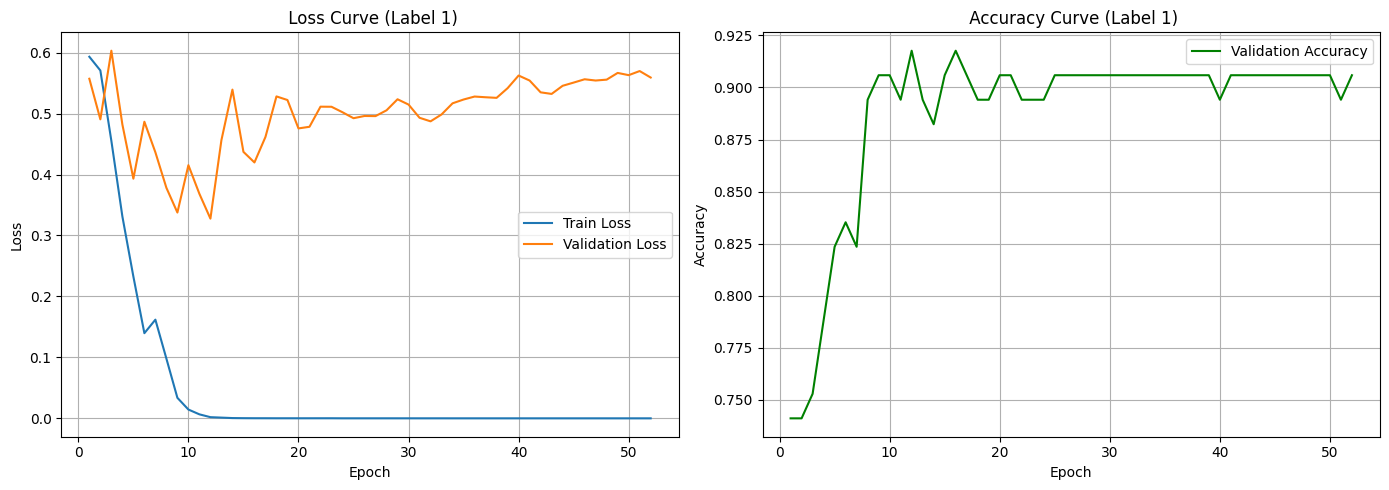

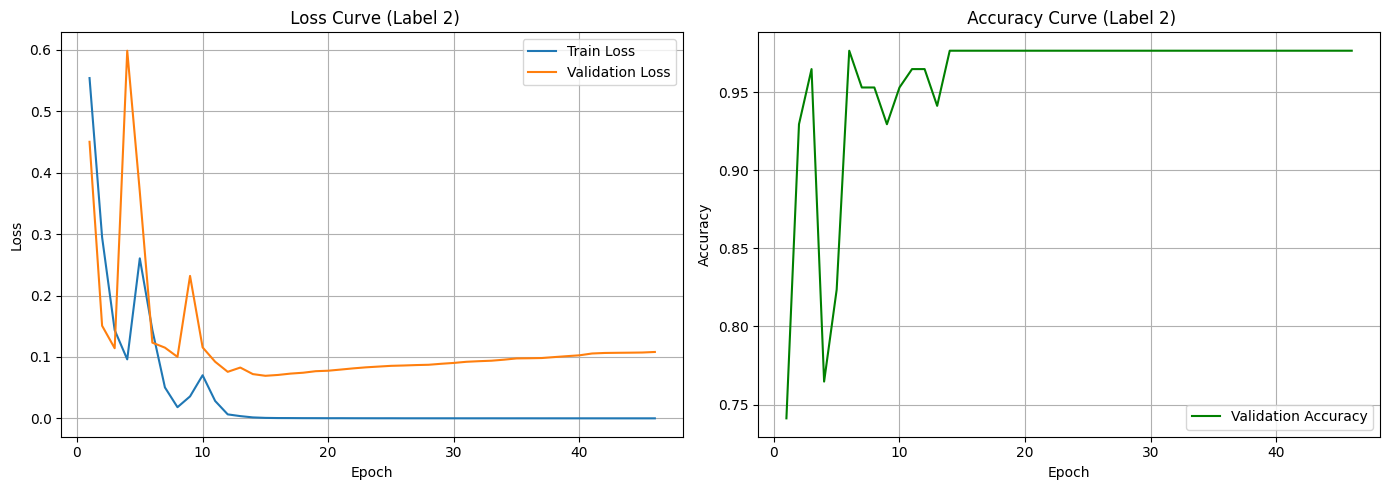

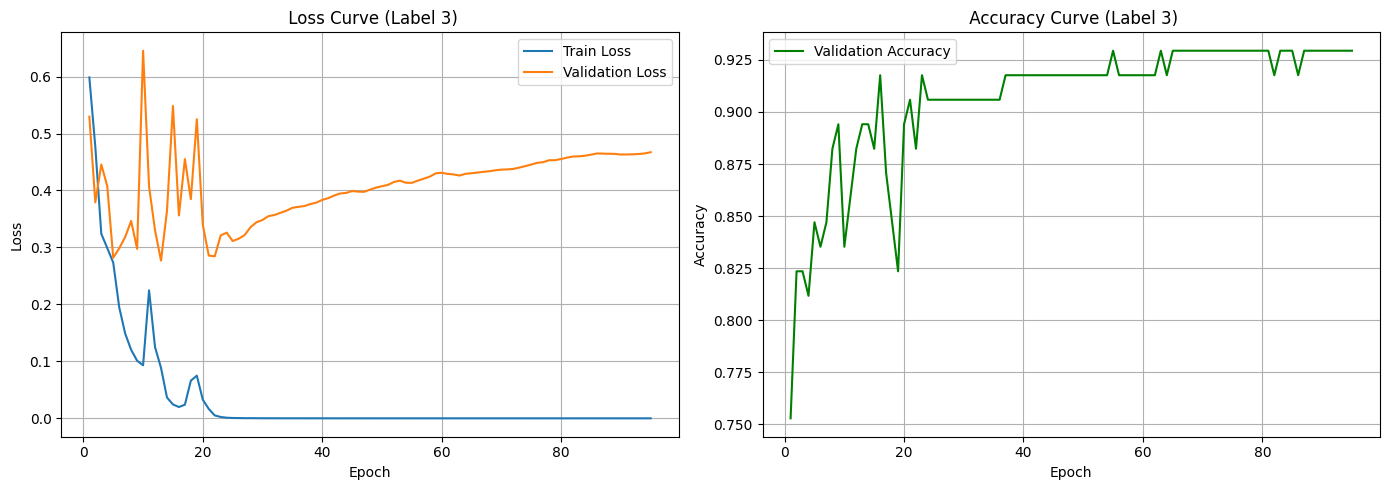

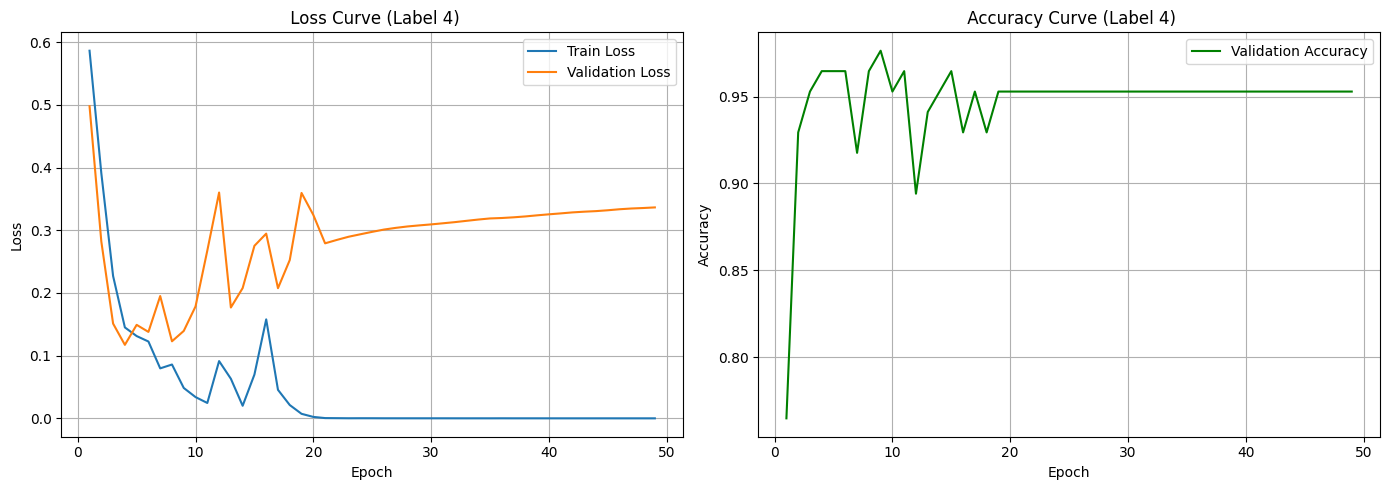

In [149]:
plot_training_history_for_fuse1(history_lstmv2)

In [141]:
results_lstmv3, history_lstmv3 = train_fuse_model('lstm_improvedv3', dataset_list, dataset_labels, epochs=100, patience=40, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])



Training for Label 1 with model type: LSTM_IMPROVEDV3
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 0.5967, Val Loss 0.5614, Acc 0.7412
Epoch 2: Train Loss 0.5282, Val Loss 0.4979, Acc 0.7412
Epoch 3: Train Loss 0.3673, Val Loss 0.7768, Acc 0.8000
Epoch 4: Train Loss 0.2453, Val Loss 0.6397, Acc 0.6706
Epoch 5: Train Loss 0.3314, Val Loss 0.3128, Acc 0.8824
Epoch 6: Train Loss 0.1470, Val Loss 0.4143, Acc 0.8471
Epoch 7: Train Loss 0.0777, Val Loss 0.4530, Acc 0.9059
Epoch 8: Train Loss 0.0400, Val Loss 0.6956, Acc 0.8706
Epoch 9: Train Loss 0.0462, Val Loss 0.3870, Acc 0.8941
Epoch 10: Train Loss 0.0236, Val Loss 0.5609, Acc 0.8941
Epoch 11: Train Loss 0.0164, Val Loss 0.5554, Acc 0.9294
Epoch 12: Train Loss 0.0957, Val Loss 2.2886, Acc 0.7647
Epoch 13: Train Loss 0.1051, Val Loss 0.6096, Acc 0.8588
Epoch 14: Train Loss 0.0344, Val Loss 0.6785, Acc 0.8235
Epoch 15: Train Loss 0.0199, Val Loss 0.5444, Acc 0.8824
Epoch 1

In [ ]:
plot_training_history_for_fuse1(history_lstm)

In [ ]:
plot_training_history_for_fuse1(history_lstm_im)

In [66]:
results_trans, history_trans = train_fuse_model('transformer', dataset_list, dataset_labels, epochs=100, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: TRANSFORMER
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63


c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Train Loss 0.5990, Val Loss 0.5735, Acc 0.7412
Epoch 2: Train Loss 0.5758, Val Loss 0.5737, Acc 0.7412
Epoch 3: Train Loss 0.5842, Val Loss 0.5781, Acc 0.7412
Epoch 4: Train Loss 0.5471, Val Loss 0.5912, Acc 0.7412
Epoch 5: Train Loss 0.5564, Val Loss 0.4981, Acc 0.7412
Epoch 6: Train Loss 0.5325, Val Loss 0.4880, Acc 0.7412
Epoch 7: Train Loss 0.5702, Val Loss 0.5811, Acc 0.7412
Epoch 8: Train Loss 0.5764, Val Loss 0.5655, Acc 0.7412
Epoch 9: Train Loss 0.5762, Val Loss 0.5563, Acc 0.7412
Epoch 10: Train Loss 0.5659, Val Loss 0.5071, Acc 0.7412
Epoch 11: Train Loss 0.5280, Val Loss 0.4742, Acc 0.7882
Epoch 12: Train Loss 0.5245, Val Loss 0.4967, Acc 0.7412
Epoch 13: Train Loss 0.4839, Val Loss 0.4177, Acc 0.8000
Epoch 14: Train Loss 0.4916, Val Loss 0.4632, Acc 0.7294
Epoch 15: Train Loss 0.4604, Val Loss 0.3951, Acc 0.8000
Epoch 16: Train Loss 0.4316, Val Loss 0.5039, Acc 0.7412
Epoch 17: Train Loss 0.4618, Val Loss 0.4111, Acc 0.7882
Epoch 18: Train Loss 0.4534, Val Loss 0.

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2: Train Loss 0.5729, Val Loss 0.5870, Acc 0.7412
Epoch 3: Train Loss 0.5664, Val Loss 0.5752, Acc 0.7412
Epoch 4: Train Loss 0.5847, Val Loss 0.5754, Acc 0.7412
Epoch 5: Train Loss 0.5815, Val Loss 0.5464, Acc 0.7412
Epoch 6: Train Loss 0.5467, Val Loss 0.4875, Acc 0.7412
Epoch 7: Train Loss 0.5157, Val Loss 0.5083, Acc 0.7647
Epoch 8: Train Loss 0.5319, Val Loss 0.5979, Acc 0.7412
Epoch 9: Train Loss 0.5716, Val Loss 0.5459, Acc 0.7412
Epoch 10: Train Loss 0.5203, Val Loss 0.4521, Acc 0.7529
Epoch 11: Train Loss 0.4746, Val Loss 0.3932, Acc 0.8824
Epoch 12: Train Loss 0.4402, Val Loss 0.4271, Acc 0.7882
Epoch 13: Train Loss 0.5206, Val Loss 0.4314, Acc 0.7647
Epoch 14: Train Loss 0.4479, Val Loss 0.3985, Acc 0.8706
Epoch 15: Train Loss 0.4076, Val Loss 0.3663, Acc 0.8824
Epoch 16: Train Loss 0.3720, Val Loss 0.3910, Acc 0.8706
Epoch 17: Train Loss 0.4116, Val Loss 0.3936, Acc 0.8235
Epoch 18: Train Loss 0.3739, Val Loss 0.3773, Acc 0.8706
Epoch 19: Train Loss 0.3341, Val Loss 0

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 2: Train Loss 0.5774, Val Loss 0.5607, Acc 0.7529
Epoch 3: Train Loss 0.5834, Val Loss 0.5633, Acc 0.7529
Epoch 4: Train Loss 0.5504, Val Loss 0.5283, Acc 0.7529
Epoch 5: Train Loss 0.5206, Val Loss 0.5774, Acc 0.7529
Epoch 6: Train Loss 0.4576, Val Loss 0.4541, Acc 0.7647
Epoch 7: Train Loss 0.4358, Val Loss 0.5733, Acc 0.7529
Epoch 8: Train Loss 0.4712, Val Loss 0.4502, Acc 0.7647
Epoch 9: Train Loss 0.4060, Val Loss 0.5252, Acc 0.7059
Epoch 10: Train Loss 0.4164, Val Loss 0.3764, Acc 0.8235
Epoch 11: Train Loss 0.4356, Val Loss 0.4643, Acc 0.7059
Epoch 12: Train Loss 0.4631, Val Loss 0.4814, Acc 0.7529
Epoch 13: Train Loss 0.4289, Val Loss 0.4464, Acc 0.7294
Epoch 14: Train Loss 0.4370, Val Loss 0.4264, Acc 0.7412
Epoch 15: Train Loss 0.4261, Val Loss 0.3853, Acc 0.8000
Epoch 16: Train Loss 0.3750, Val Loss 0.3913, Acc 0.8235
Epoch 17: Train Loss 0.3531, Val Loss 0.3489, Acc 0.8588
Epoch 18: Train Loss 0.3432, Val Loss 0.3124, Acc 0.8706
Epoch 19: Train Loss 0.3169, Val Loss 0

c:\Users\lycaz\.conda\envs\pyds\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 3: Train Loss 0.5544, Val Loss 0.5493, Acc 0.7647
Epoch 4: Train Loss 0.5382, Val Loss 0.5419, Acc 0.7647
Epoch 5: Train Loss 0.5090, Val Loss 0.4567, Acc 0.7647
Epoch 6: Train Loss 0.4118, Val Loss 0.4137, Acc 0.8471
Epoch 7: Train Loss 0.3437, Val Loss 0.3222, Acc 0.8941
Epoch 8: Train Loss 0.3499, Val Loss 0.2735, Acc 0.8941
Epoch 9: Train Loss 0.3264, Val Loss 0.3814, Acc 0.8588
Epoch 10: Train Loss 0.2554, Val Loss 0.2082, Acc 0.9294
Epoch 11: Train Loss 0.2539, Val Loss 0.3022, Acc 0.8941
Epoch 12: Train Loss 0.2311, Val Loss 0.1613, Acc 0.9294
Epoch 13: Train Loss 0.2490, Val Loss 0.2049, Acc 0.9412
Epoch 14: Train Loss 0.2905, Val Loss 0.2643, Acc 0.8941
Epoch 15: Train Loss 0.2888, Val Loss 0.3016, Acc 0.8471
Epoch 16: Train Loss 0.2954, Val Loss 0.2565, Acc 0.9294
Epoch 17: Train Loss 0.2615, Val Loss 0.2390, Acc 0.9294
Epoch 18: Train Loss 0.2405, Val Loss 0.1972, Acc 0.9294
Epoch 19: Train Loss 0.2182, Val Loss 0.1444, Acc 0.9529
Epoch 20: Train Loss 0.2161, Val Loss 

In [86]:
results_trans_im, history_trans_im = train_fuse_model('transformer_improved', dataset_list, dataset_labels, epochs=100, patience=40, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: TRANFORMER_IMPROVED
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 2.6899, Val Loss 0.6702, Acc 0.7412
Epoch 2: Train Loss 1.3188, Val Loss 0.5145, Acc 0.7412
Epoch 3: Train Loss 0.6465, Val Loss 0.4715, Acc 0.8118
Epoch 4: Train Loss 0.5959, Val Loss 0.4496, Acc 0.7765
Epoch 5: Train Loss 0.6540, Val Loss 0.4943, Acc 0.8235
Epoch 6: Train Loss 0.5533, Val Loss 0.4620, Acc 0.8588
Epoch 7: Train Loss 0.4670, Val Loss 0.4411, Acc 0.8235
Epoch 8: Train Loss 0.4674, Val Loss 0.4503, Acc 0.8471
Epoch 9: Train Loss 0.4326, Val Loss 0.4583, Acc 0.7882
Epoch 10: Train Loss 0.3885, Val Loss 0.4484, Acc 0.8235
Epoch 11: Train Loss 0.4032, Val Loss 0.4393, Acc 0.8353
Epoch 12: Train Loss 0.3603, Val Loss 0.4294, Acc 0.8353
Epoch 13: Train Loss 0.3496, Val Loss 0.4292, Acc 0.8471
Epoch 14: Train Loss 0.3566, Val Loss 0.5543, Acc 0.7647
Epoch 15: Train Loss 0.3383, Val Loss 0.4284, Acc 0.8588
Epo

In [ ]:
# not good as the lstm 
results_trans_imv2, history_trans_imv2 = train_fuse_model('transformer_improvedv2', dataset_list, dataset_labels, epochs=200, patience=40, feature_keys=['press_deriv_rms', 'audio_press_mfcc'])


Training for Label 1 with model type: TRANSFORMER_IMPROVEDV2
Train Samples - Target: 88, Non-target: 250
Validation Samples - Target: 22, Non-target: 63
Epoch 1: Train Loss 4.0327, Val Loss 3.5698, Acc 0.7412
Epoch 2: Train Loss 3.1338, Val Loss 1.1069, Acc 0.5765
Epoch 3: Train Loss 1.2012, Val Loss 0.7046, Acc 0.7059
Epoch 4: Train Loss 1.1944, Val Loss 0.8388, Acc 0.6824
Epoch 5: Train Loss 0.8348, Val Loss 0.9299, Acc 0.5412
Epoch 6: Train Loss 0.6024, Val Loss 0.4985, Acc 0.7529
Epoch 7: Train Loss 0.6036, Val Loss 0.6419, Acc 0.7412
Epoch 8: Train Loss 0.4879, Val Loss 0.4600, Acc 0.8118
Epoch 9: Train Loss 0.5056, Val Loss 0.4460, Acc 0.7882
Epoch 10: Train Loss 0.4912, Val Loss 0.4982, Acc 0.8000
Epoch 11: Train Loss 0.4710, Val Loss 0.5251, Acc 0.7647
Epoch 12: Train Loss 0.4677, Val Loss 0.4610, Acc 0.8235
Epoch 13: Train Loss 0.4582, Val Loss 0.4763, Acc 0.8000
Epoch 14: Train Loss 0.4134, Val Loss 0.4663, Acc 0.8000
Epoch 15: Train Loss 0.4025, Val Loss 0.5484, Acc 0.7412


# Model for fuse 2 press + haptic ( 4 features )